# Seasonal Crops Time Series Analysis for Agriculture Commodities in Kenya

#### Author: Edward Njiru
#### Date: September 2024

---

### Introduction
This notebook analyzes the trends in volumes and prices of seasonal crops in Kenya for the last three years (July 2021 - June 2024). The primary goals of the analysis include:

1. Understanding changes in crop volumes and prices on a monthly and quarterly basis.
2. Identifying high-demand crops based on supplied volumes and market prices.
3. Evaluating the most profitable crops by analyzing the margins between wholesale and retail prices.
4. Identifying the commodities that have significant demand AND significant profit margins.

---

### Table of Contents
1. Data Loading and Exploration
2. Time Series Analysis of Crop Prices and Volumes
3. Monthly and Quarterly Trend Analysis
4. Crop Demand and Supply Analysis
5. Profitability Analysis: Wholesale vs. Retail Prices
6. Conclusions and Future Work

---

### Section 1: Data Loading and Initial Exploration

In this section, we will:
- Load the dataset containing information on seasonal crops.
- Conduct an initial exploration to understand its structure and contents.
- Check for missing values and the data types of each column.


In [1]:
# Importing necessary libraries for data analysis and visualization

import pandas as pd  # For data manipulation
import numpy as np   # For numerical computations
import matplotlib.pyplot as plt  # For basic plotting
import seaborn as sns  # For advanced visualizations

# To manage time series data
from datetime import datetime

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings for pandas
pd.set_option('display.max_columns', None)  # Show all columns in output
pd.set_option('display.max_rows', 150)      # Limit display of rows to 150 for clarity


In [2]:
# Load the dataset from the provided CSV file path
file_path = r"H:\Datasets\Agriculture Kenya\Food Prices\KAMIS 2009-2024\Clean Datasets\seasonal_crops_data.csv"

# Reading the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

# Display the first 5 rows of the dataset to get an overview
data.head()

date   commodity classification     county   market  \
0  2024-09-16  Arrow Root              -     Vihiga    Mbale   
1  2024-09-16  Arrow Root              -      Kitui   Kisasi   
2  2024-09-16  Arrow Root              -      Kitui  Kalundu   
3  2024-09-16  Arrow Root              -  Kirinyaga    Kutus   
4  2024-09-16  Arrow Root              -     Nakuru     Molo   

   volume_supplied_tonnes  wholesale_price_ksh  retail_price_ksh  
0                  0.5000                125.0            166.67  
1                  0.8500                 80.0            130.00  
2                  0.4415                 90.0            150.00  
3                  0.7500                 80.0            100.00  
4                  0.7500                 42.0            150.00

In [3]:
# Check the data types of each column and for missing values
data.info()

# Check for any missing values in the dataset
missing_values = data.isnull().sum()
print("Missing values per column:\n", missing_values)

# Summary statistics for numeric columns (volume, wholesale price, retail price)
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412400 entries, 0 to 412399
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   date                    412400 non-null  object 
 1   commodity               412400 non-null  object 
 2   classification          412400 non-null  object 
 3   county                  412400 non-null  object 
 4   market                  412400 non-null  object 
 5   volume_supplied_tonnes  412400 non-null  float64
 6   wholesale_price_ksh     412400 non-null  float64
 7   retail_price_ksh        412400 non-null  float64
dtypes: float64(3), object(5)
memory usage: 25.2+ MB
Missing values per column:
 date                      0
commodity                 0
classification            0
county                    0
market                    0
volume_supplied_tonnes    0
wholesale_price_ksh       0
retail_price_ksh          0
dtype: int64


volume_supplied_tonnes  wholesale_price_ksh  retail_price_ksh
count           412400.000000        412400.000000     412400.000000
mean                 1.863542            69.039739        768.746684
std                  3.658987            55.668904       6750.377796
min                  0.000100             0.010000          0.010000
25%                  0.240000            33.330000         70.000000
50%                  0.630000            55.835000        100.000000
75%                  2.000000            90.000000        150.000000
max                 48.000000           650.000000      75000.000000

1. **Date Correction**: 
   The `date` column needs to be converted from an `object` data type to a `datetime` data type. This is essential for proper time-series analysis.

2. **Price Anomalies**:
   Given that these are food market commodities, some of the prices are suspicious. Specifically:
   - There are **minimum values** as low as Ksh. 0.01, which is likely an error or a reporting issue.
   - There are **maximum values** as high as Ksh. 75,000, which could be an outlier or a high-end commodity, but requires further exploration.
   
   We will explore the distribution of prices and handle these outliers accordingly to ensure they don't distort the analysis.


Given that prices can vary significantly between different commodities, we will perform a commodity-specific analysis. This involves:

1. **Grouping by commodity**: Analyzing wholesale and retail prices for each commodity separately.
2. **Visualizing the distribution of prices**: Boxplots will help in identifying price variations and outliers for each commodity.
3. **Summary statistics for each commodity**: Calculating mean, median, and other statistics to understand the price trends and to detect outliers that may need further handling.


In [4]:
# Define a function to calculate detailed percentiles and counts, with a price_type column
def calculate_percentile_counts_with_type(df, price_column, price_type):
    
    # Calculate percentiles
    summary = df.groupby('commodity')[price_column].quantile([0, 0.25, 0.5, 0.75, 1.0]).unstack()
    summary.columns = ['min', '25%', '50%', '75%', 'max']
    
    # Count the number of records between each percentile range
    counts = df.groupby('commodity')[price_column].agg(['count'])
    counts['min_to_25%'] = df.groupby('commodity').apply(lambda x: ((x[price_column] >= summary.loc[x.name, 'min']) & 
                                                                    (x[price_column] < summary.loc[x.name, '25%'])).sum())
    counts['25%_to_50%'] = df.groupby('commodity').apply(lambda x: ((x[price_column] >= summary.loc[x.name, '25%']) & 
                                                                    (x[price_column] < summary.loc[x.name, '50%'])).sum())
    counts['50%_to_75%'] = df.groupby('commodity').apply(lambda x: ((x[price_column] >= summary.loc[x.name, '50%']) & 
                                                                    (x[price_column] < summary.loc[x.name, '75%'])).sum())
    counts['75%_to_max'] = df.groupby('commodity').apply(lambda x: ((x[price_column] >= summary.loc[x.name, '75%']) & 
                                                                    (x[price_column] <= summary.loc[x.name, 'max'])).sum())

    # Merge percentiles and counts
    full_summary = pd.concat([summary, counts], axis=1)
    
    # Add the price_type column
    full_summary['price_type'] = price_type
    
    return full_summary

# Apply the function to wholesale prices
wholesale_percentiles = calculate_percentile_counts_with_type(data, 'wholesale_price_ksh', 'wholesale')

# Apply the function to retail prices
retail_percentiles = calculate_percentile_counts_with_type(data, 'retail_price_ksh', 'retail')

# Combine the two DataFrames (wholesale and retail)
combined_percentiles = pd.concat([wholesale_percentiles, retail_percentiles]).reset_index()

# Sort the combined DataFrame by 'commodity' and 'price_type' to ensure they are ordered correctly
combined_percentiles = combined_percentiles.sort_values(by=['commodity', 'price_type']).reset_index(drop=True)

# Reorder columns to ensure 'price_type' comes after 'commodity' and 'count' comes last
cols = ['commodity', 'price_type', 'min', '25%', '50%', '75%', 'max', 
        'min_to_25%', '25%_to_50%', '50%_to_75%', '75%_to_max', 'count']

# Reassign the DataFrame with the new column order
combined_percentiles = combined_percentiles[cols]

# Display the combined DataFrame without cutting it off
pd.set_option('display.max_rows', None)  # Set max rows to None to display all rows
pd.set_option('display.max_columns', None)  # Ensure all columns are displayed
combined_percentiles


commodity price_type      min       25%  \
0                  Amaranthus (Terere)     retail    0.080   35.0000   
1                  Amaranthus (Terere)  wholesale    0.010   23.3300   
2                           Arrow Root     retail   25.000  100.0000   
3                           Arrow Root  wholesale   18.000   70.0000   
4              Beans (Canadian wonder)     retail   44.440  120.0000   
5              Beans (Canadian wonder)  wholesale    0.010   53.3300   
6                   Beans (Mwezi Moja)     retail   37.500  100.0000   
7                   Beans (Mwezi Moja)  wholesale    0.010   60.0000   
8          Beans Red Haricot (Wairimu)     retail   25.000  100.0000   
9          Beans Red Haricot (Wairimu)  wholesale    4.400   76.6650   
10              Beans Rosecoco (Nyayo)     retail   10.000  112.5000   
11              Beans Rosecoco (Nyayo)  wholesale    0.010   80.0000   
12    Black nightshade (Managu/ Osuga)     retail    0.050   50.0000   
13    Black nightshade (Managu/ Osuga)  wholesale    0.010   30.0000   
14                            Broccoli     retail    0.250   90.0000   
15                            Broccoli  wholesale    0.010   60.0000   
16                          Butternuts     retail    1.000   60.0000   
17                          Butternuts  wholesale    0.010   40.0000   
18                           Capsicums     retail    0.200   80.0000   
19                           Capsicums  wholesale    0.020   40.0000   
20                 Cassava Chips (dry)     retail   19.980   60.0000   
21                 Cassava Chips (dry)  wholesale    0.280   40.0000   
22                       Cassava Fresh     retail    0.080   66.6700   
23                       Cassava Fresh  wholesale    0.010   15.1800   
24                         Cauliflower     retail    2.000  150.0000   
25                         Cauliflower  wholesale    0.010   50.0000   
26                            Chillies     retail    0.100  100.0000   
27                            Chillies  wholesale    0.010   47.3700   
28                  Coriander (Dhania)     retail    0.040   80.0000   
29                  Coriander (Dhania)  wholesale    0.010   50.0000   
30                           Courgette     retail    0.150   80.0000   
31                           Courgette  wholesale    0.010   50.0000   
32               Cowpea leaves (Kunde)     retail    0.160   40.0000   
33               Cowpea leaves (Kunde)  wholesale    0.010   30.0000   
34                             Cowpeas     retail    0.200   92.0000   
35                             Cowpeas  wholesale    0.010   55.0000   
36                            Cucumber     retail   40.000   80.0000   
37                            Cucumber  wholesale    0.010   30.0000   
38                           Dry Maize     retail    0.030   50.7600   
39                           Dry Maize  wholesale    0.010   28.8900   
40                          Dry Onions     retail    0.010   70.0000   
41                          Dry Onions  wholesale    0.010   46.1500   
42                            Dry Peas     retail   60.000  130.0000   
43                            Dry Peas  wholesale    0.010  106.6700   
44                Egg plant (Brinjals)     retail    2.500   60.0000   
45                Egg plant (Brinjals)  wholesale    0.010   25.0000   
46           Ethiopian Kales - Kanzira     retail   12.860   60.0000   
47           Ethiopian Kales - Kanzira  wholesale    3.330   40.0000   
48                        French beans     retail   20.000   70.0000   
49                        French beans  wholesale    0.020   50.0000   
50                          Fresh Peas     retail    0.010  100.0000   
51                          Fresh Peas  wholesale    0.010   40.0000   
52                              Garlic     retail   50.000  350.0000   
53                              Garlic  wholesale   25.000  280.0000   
54                              Ginger     retail   30.000  134.8300 

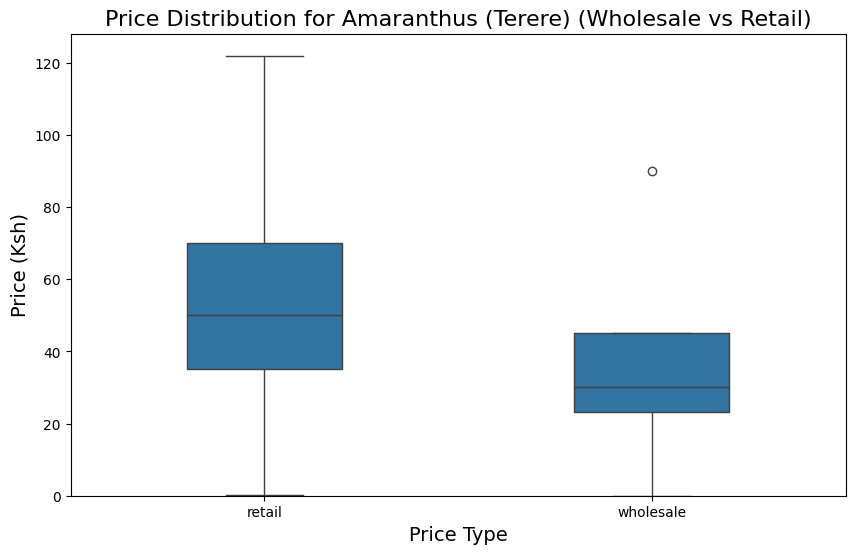

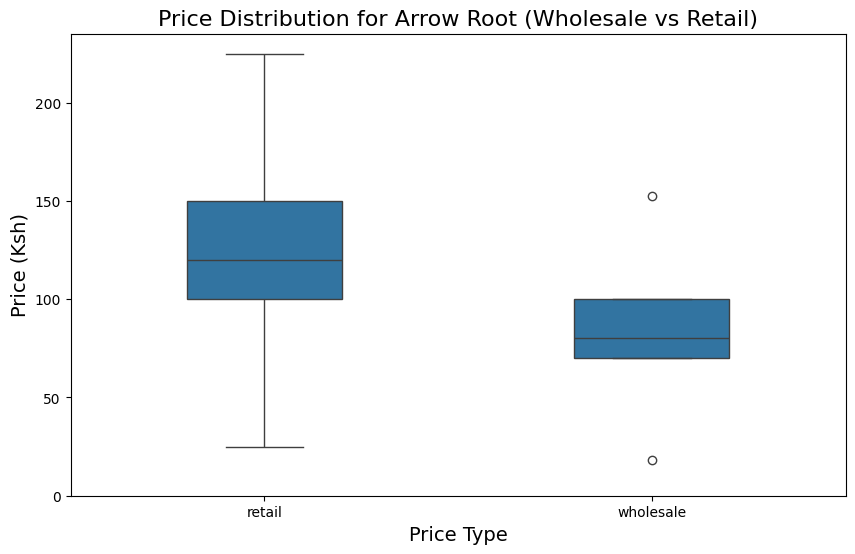

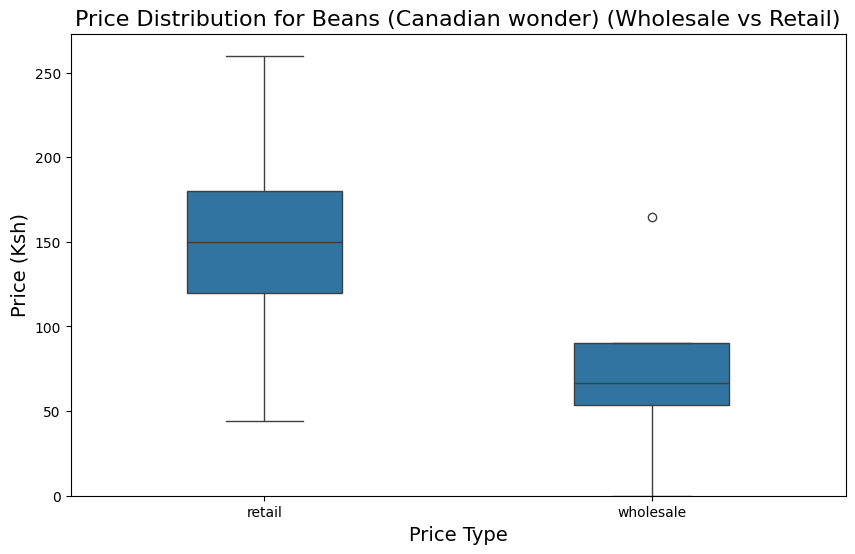

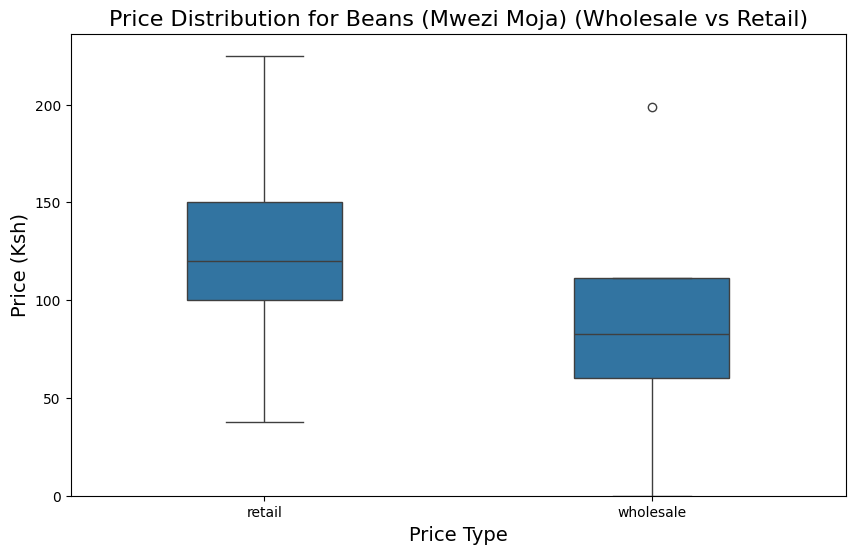

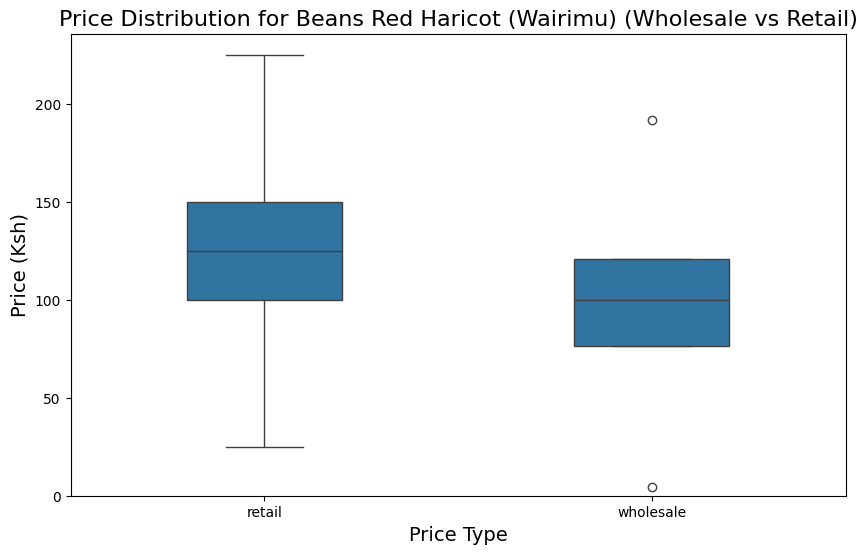

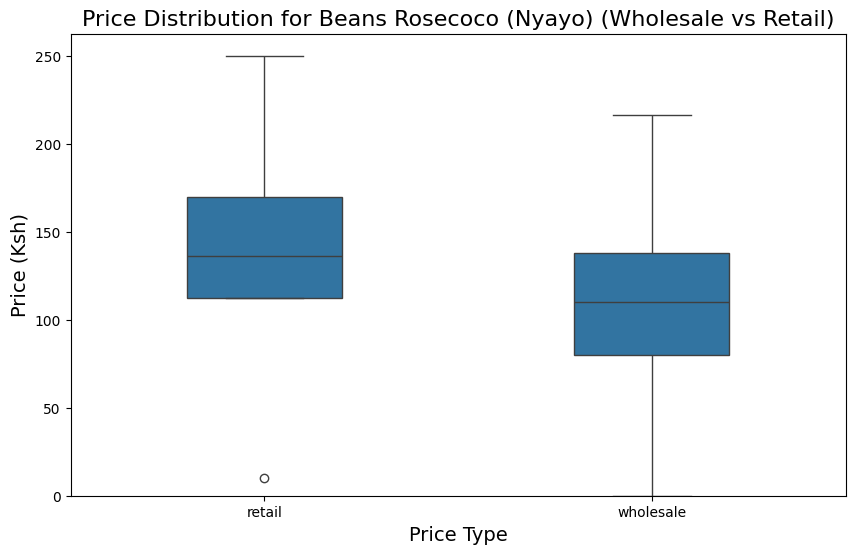

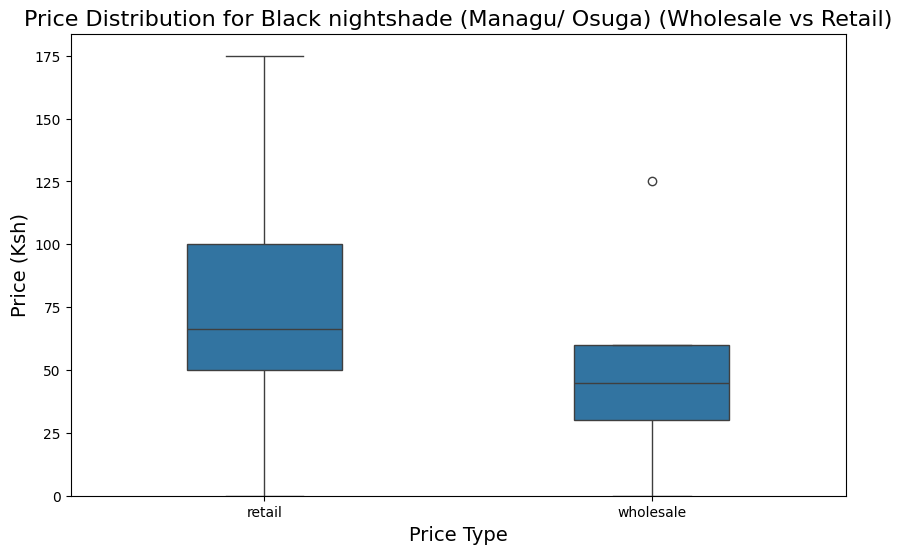

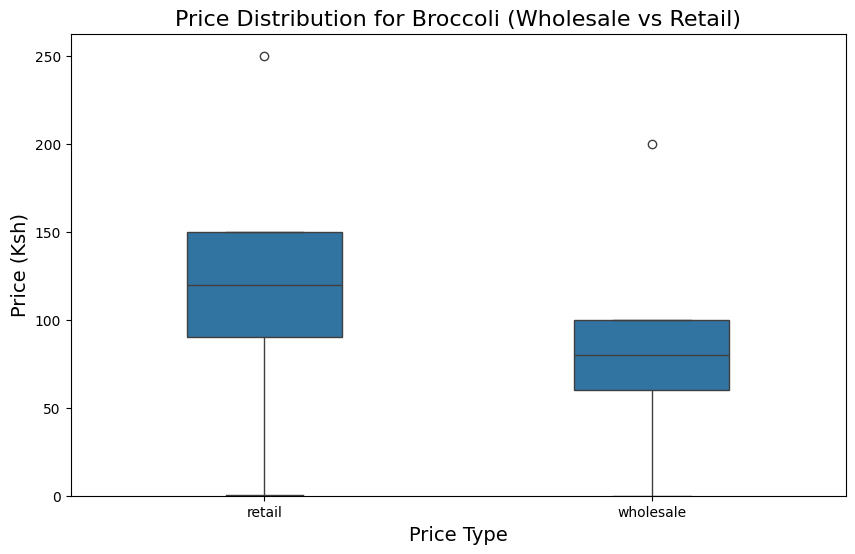

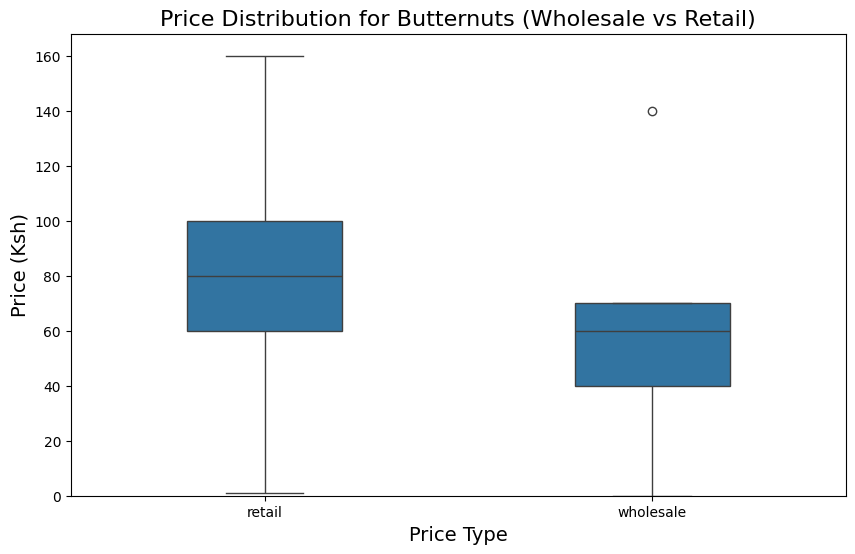

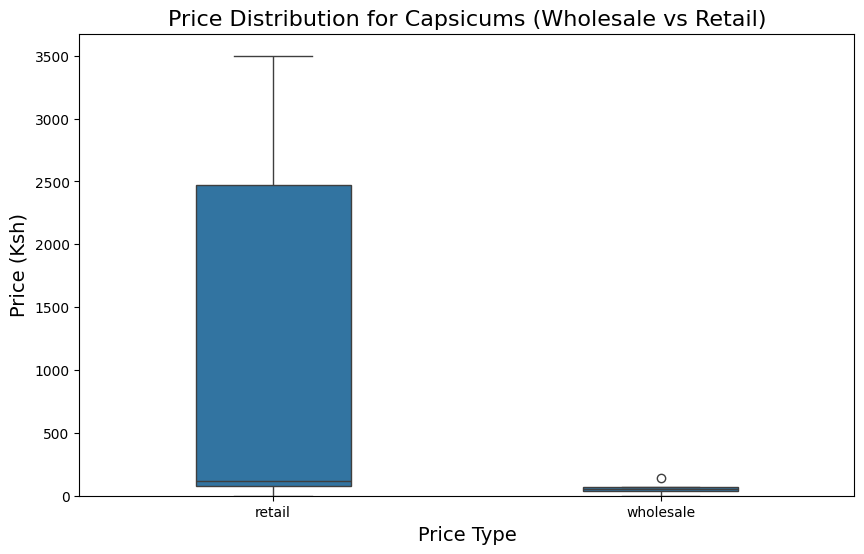

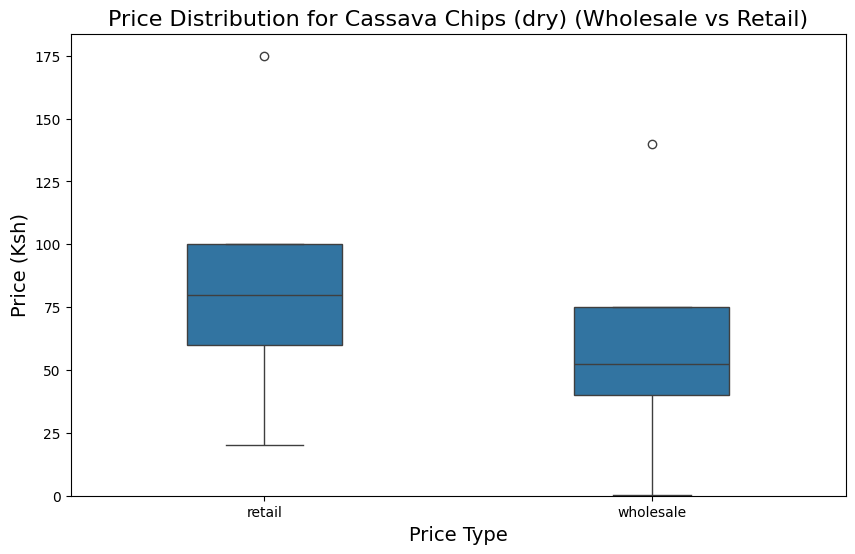

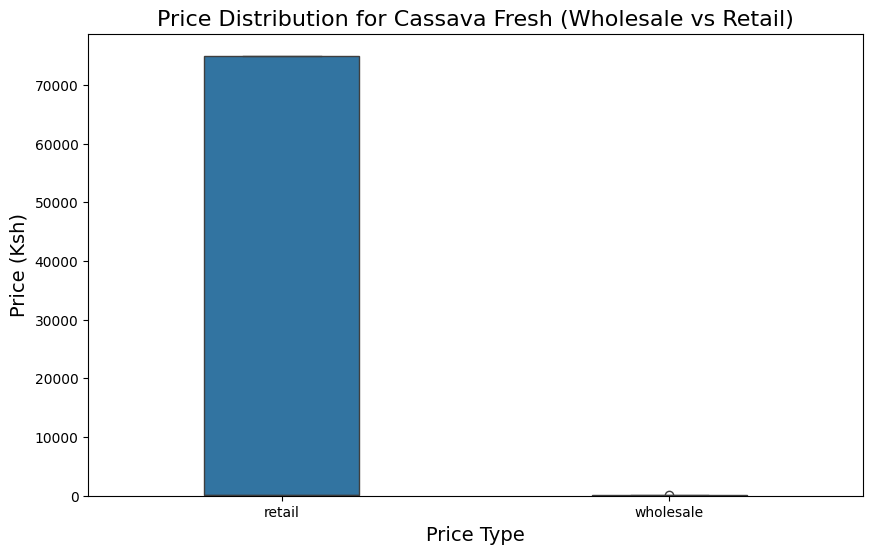

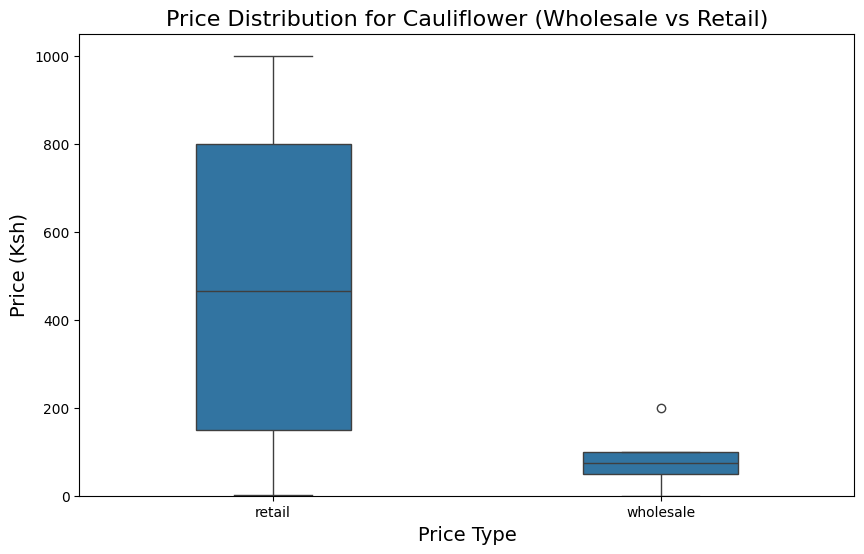

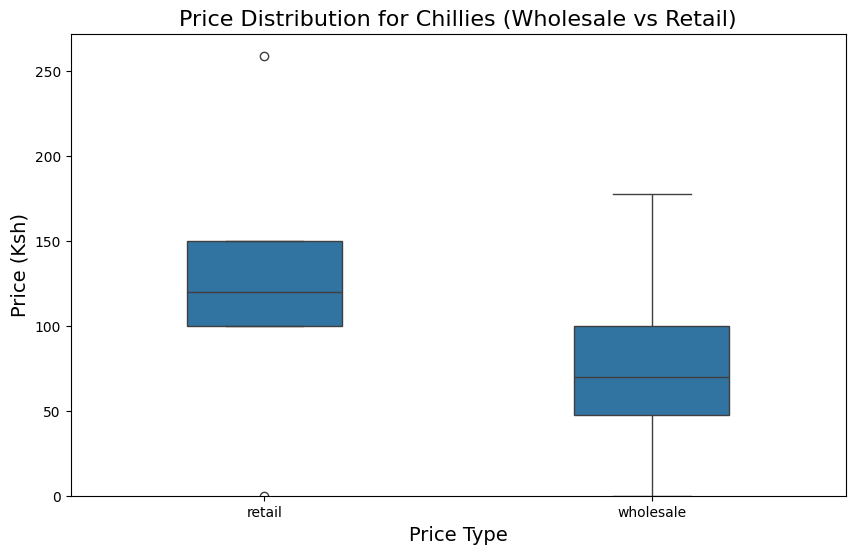

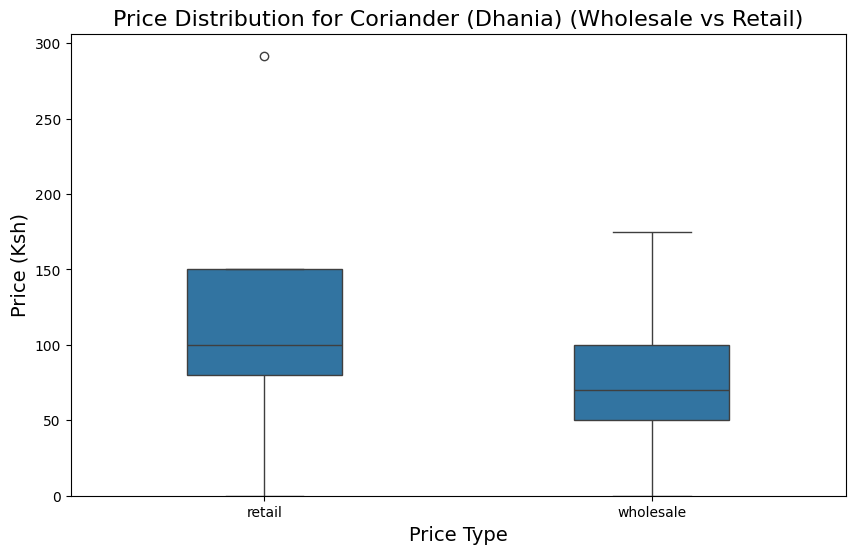

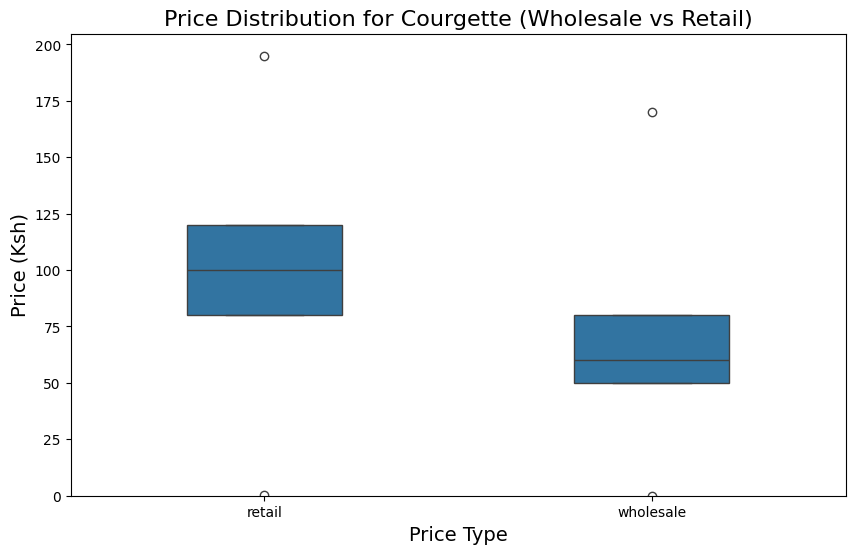

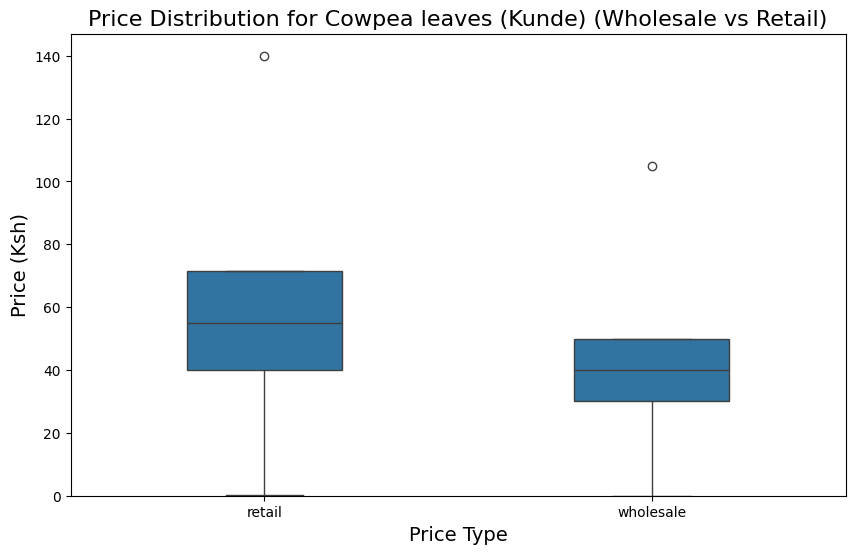

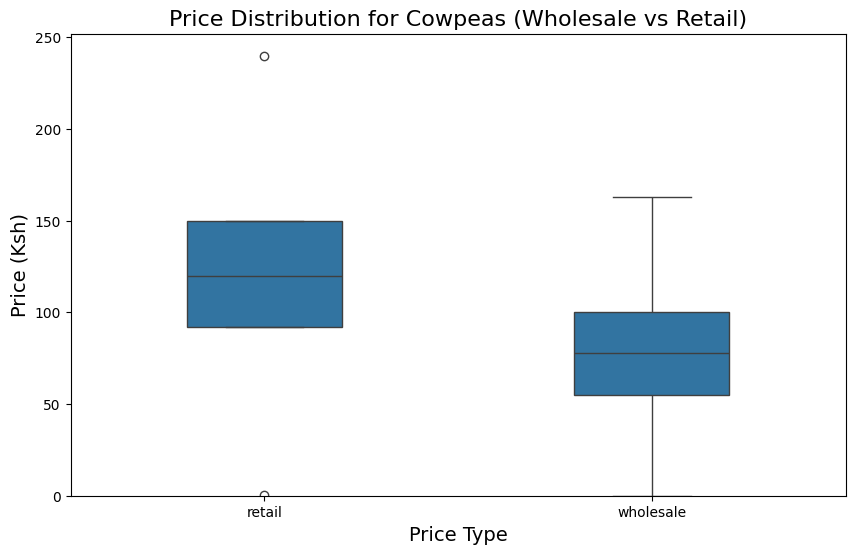

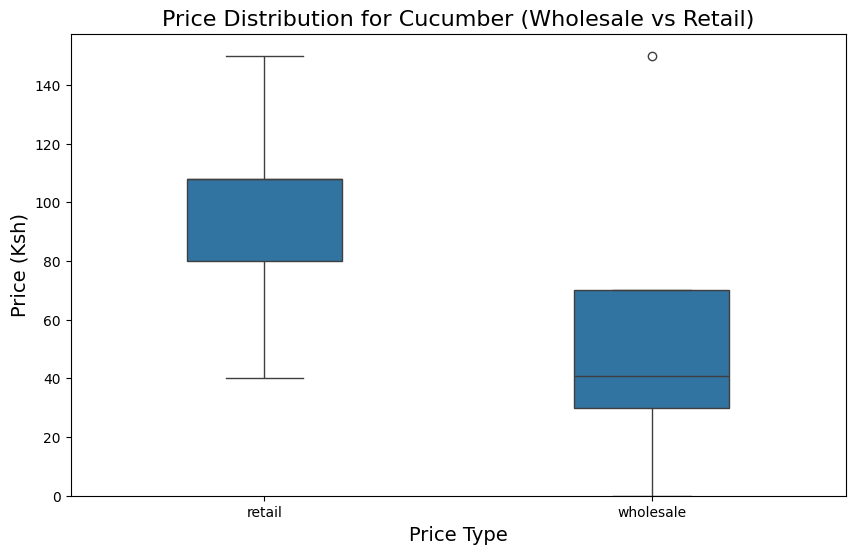

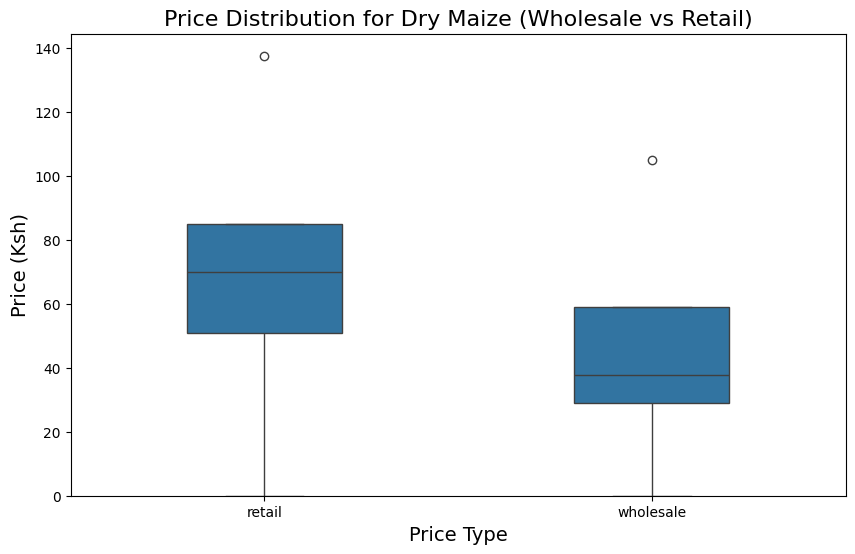

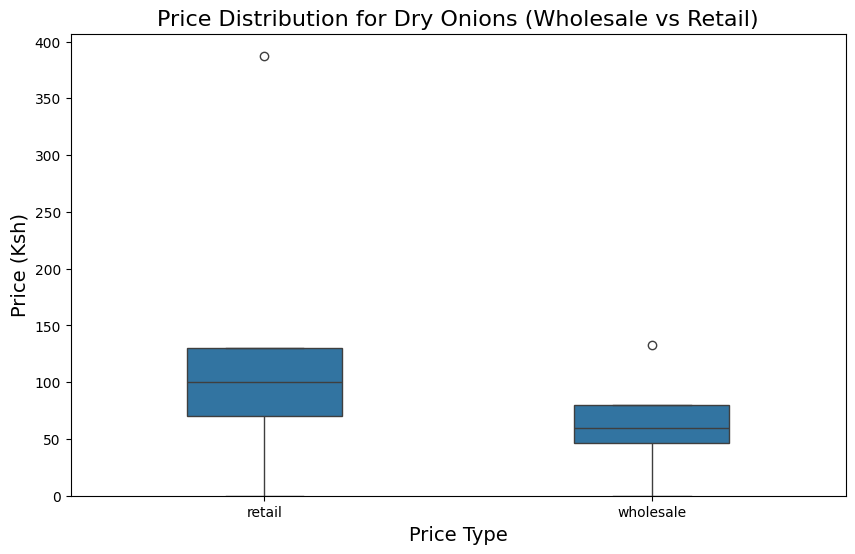

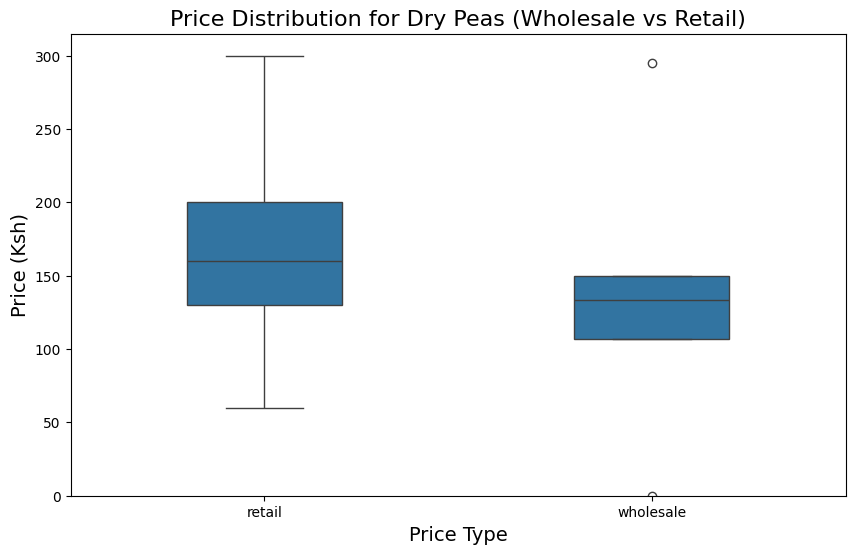

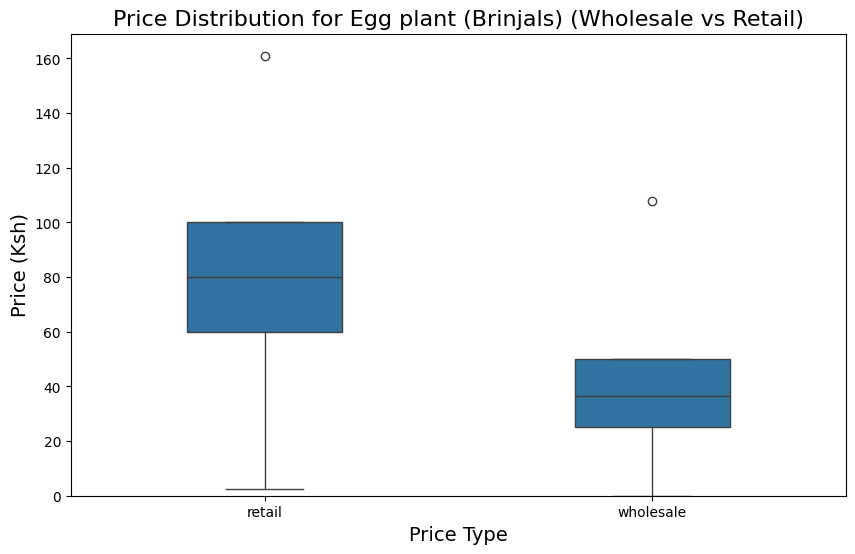

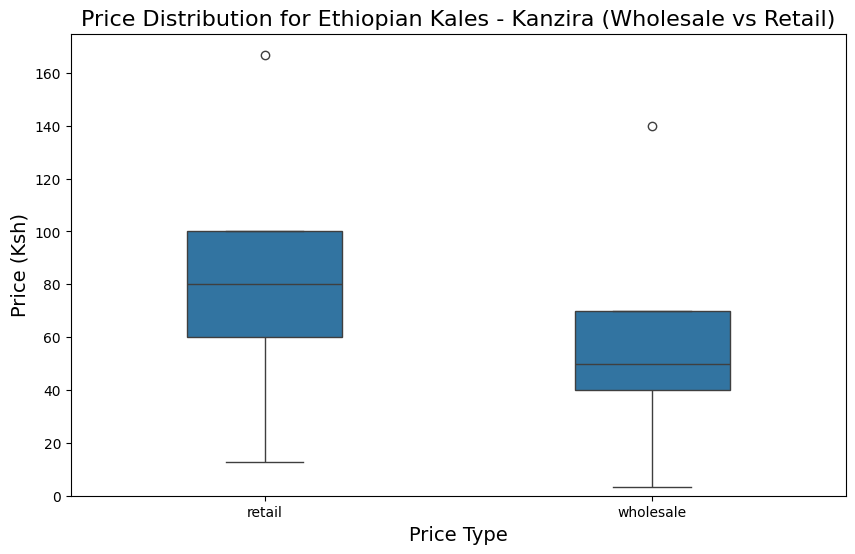

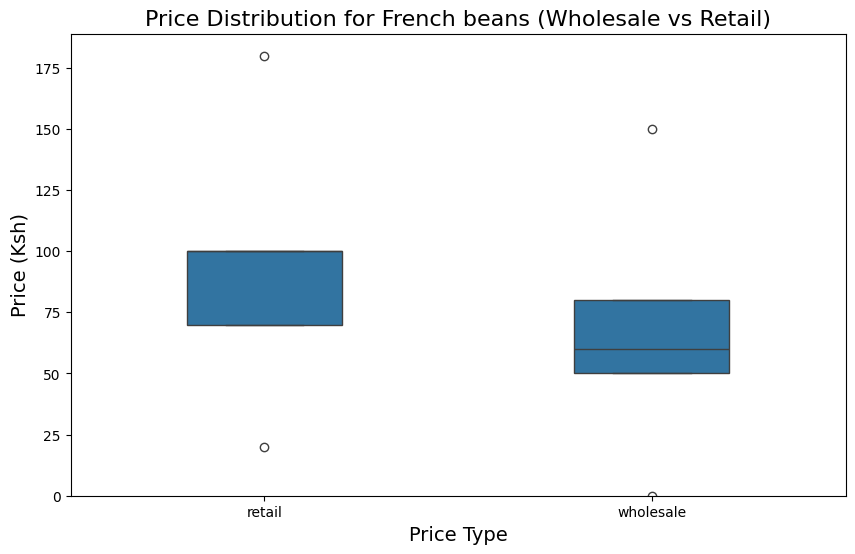

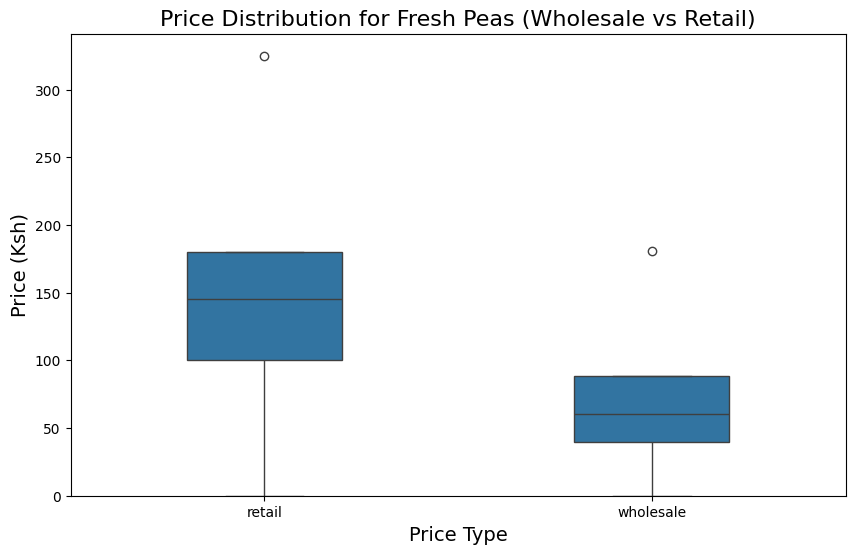

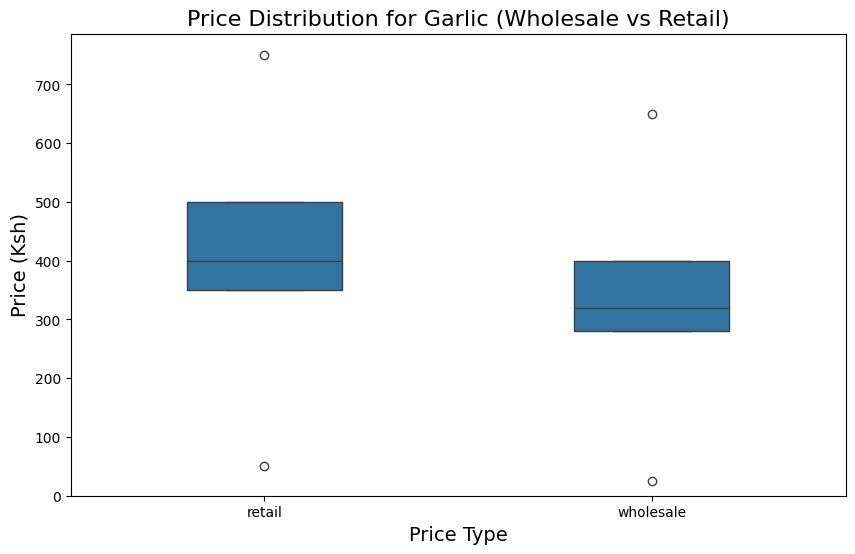

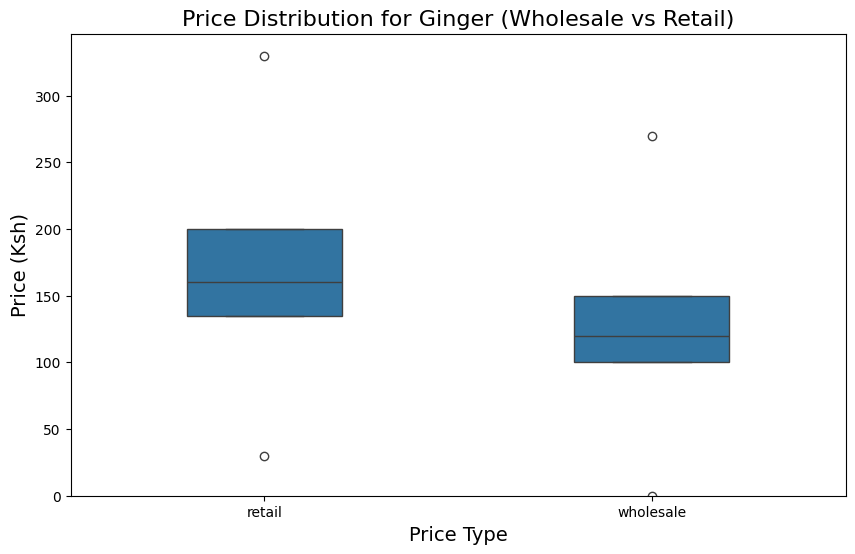

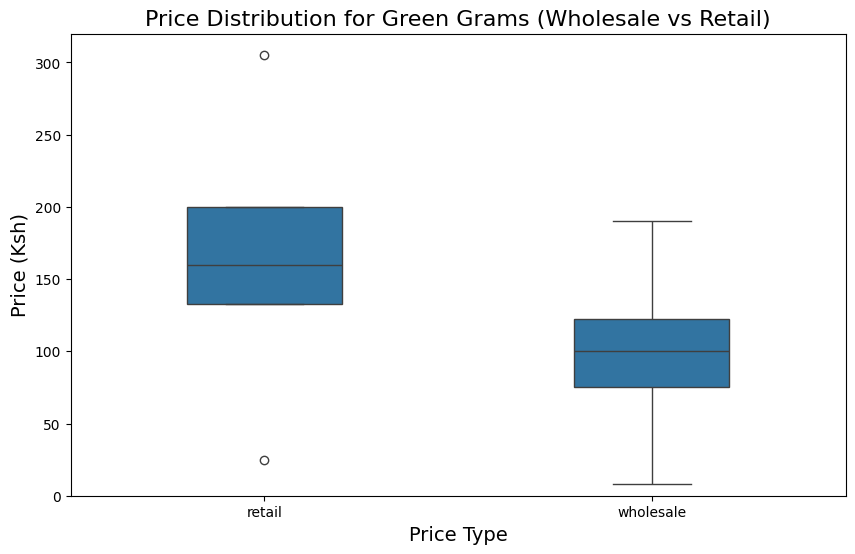

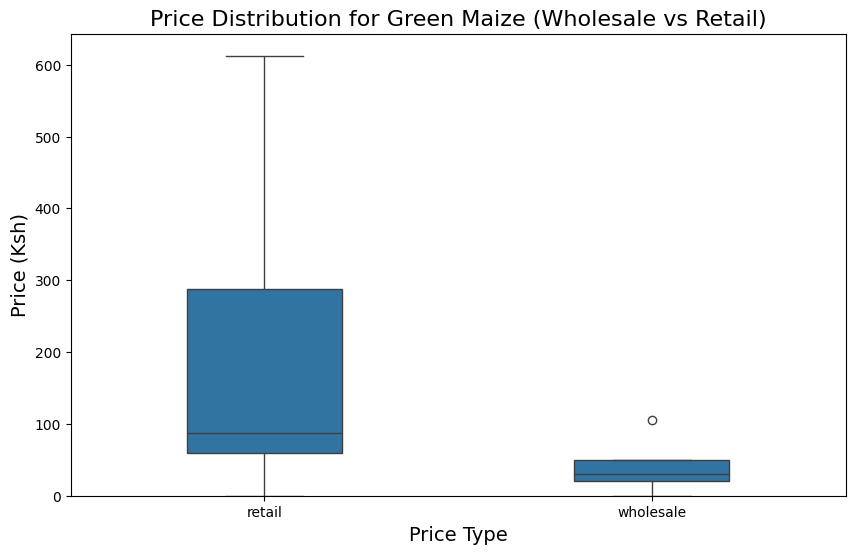

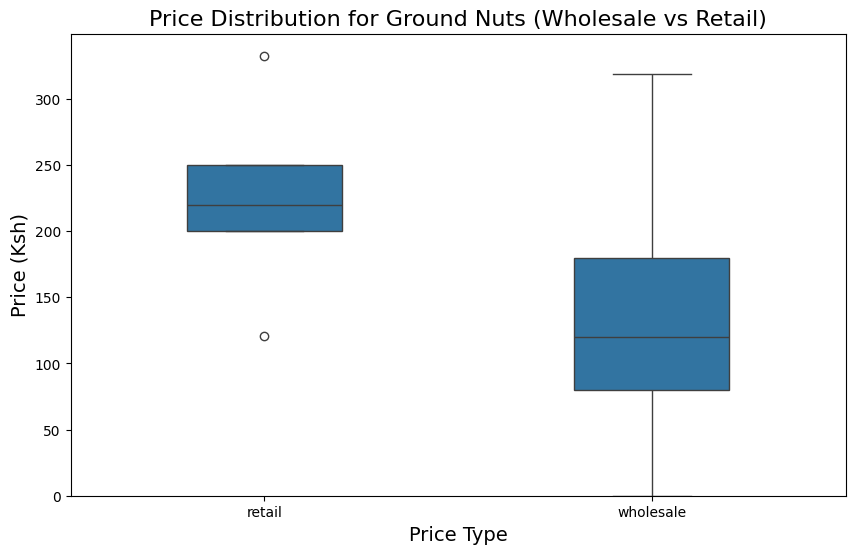

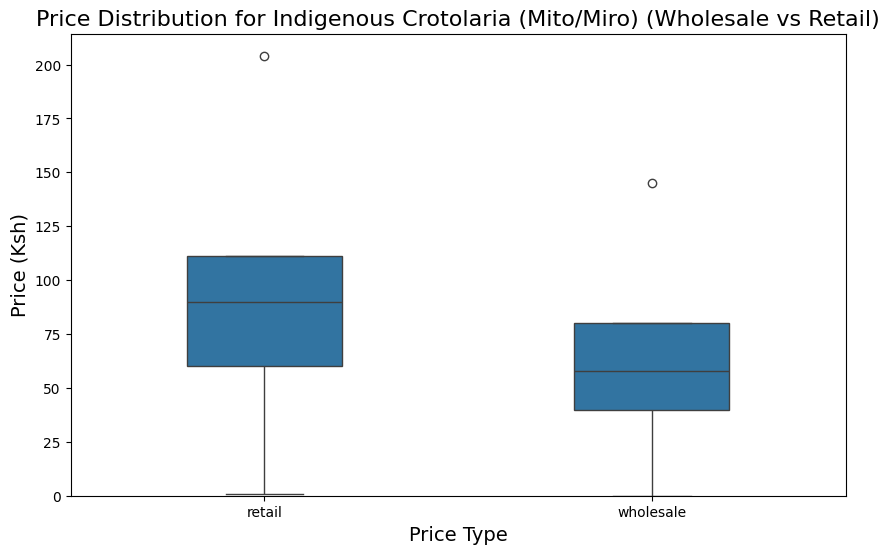

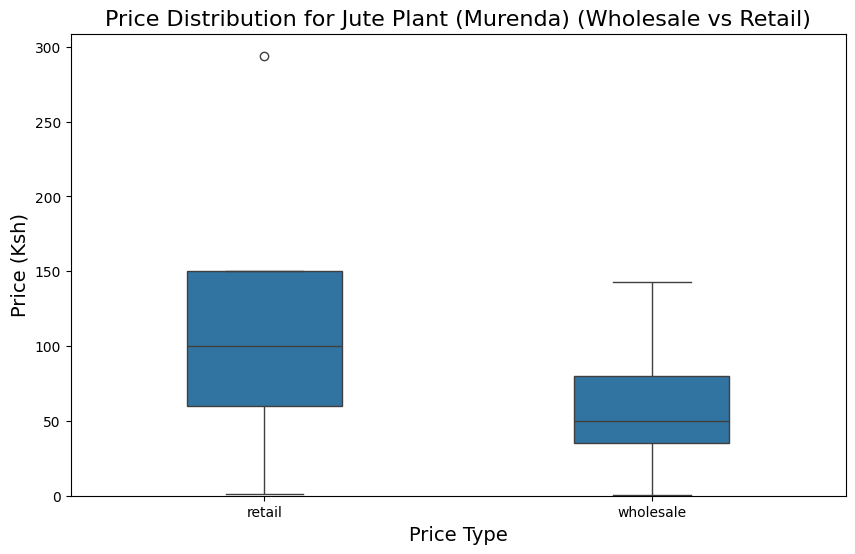

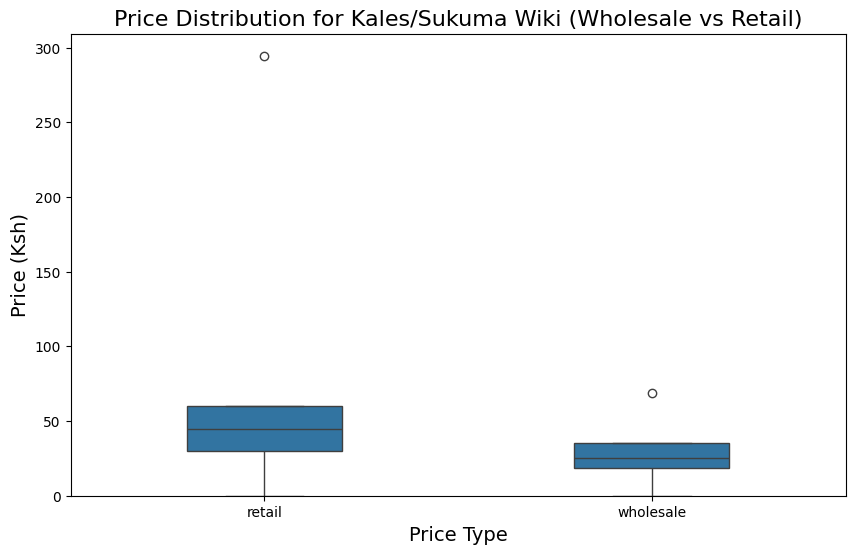

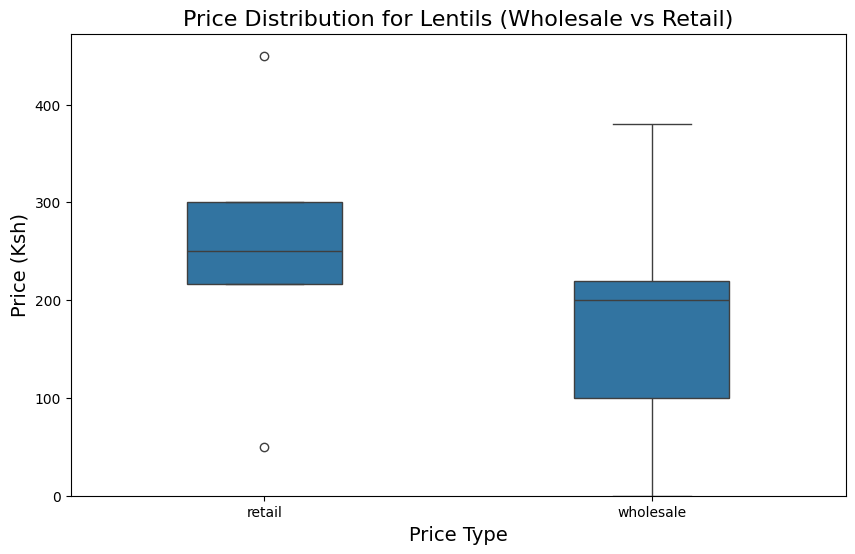

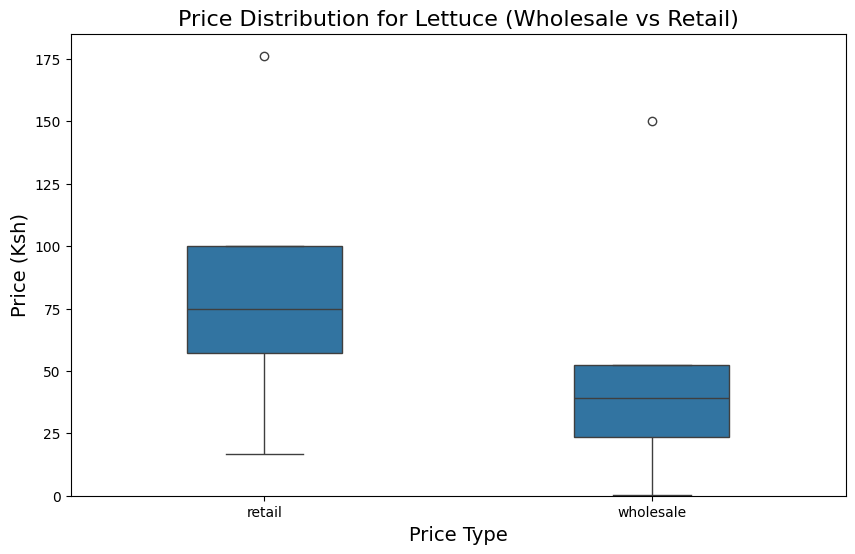

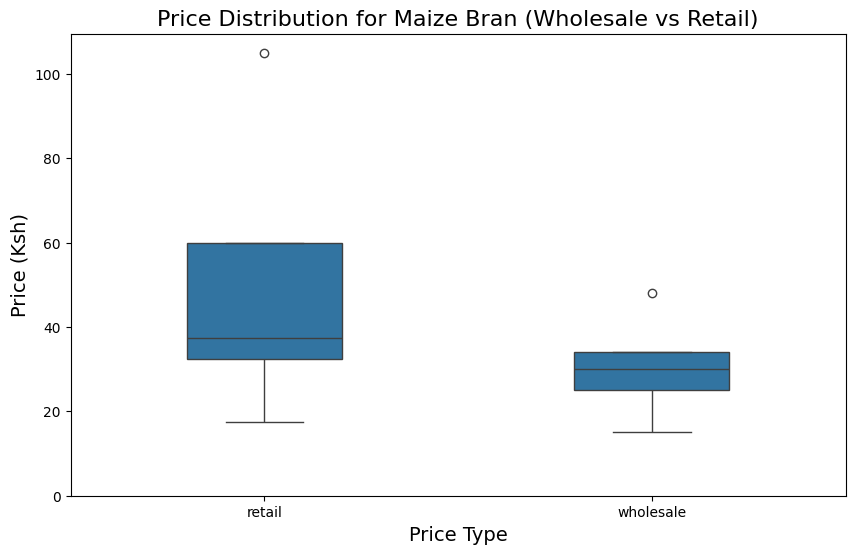

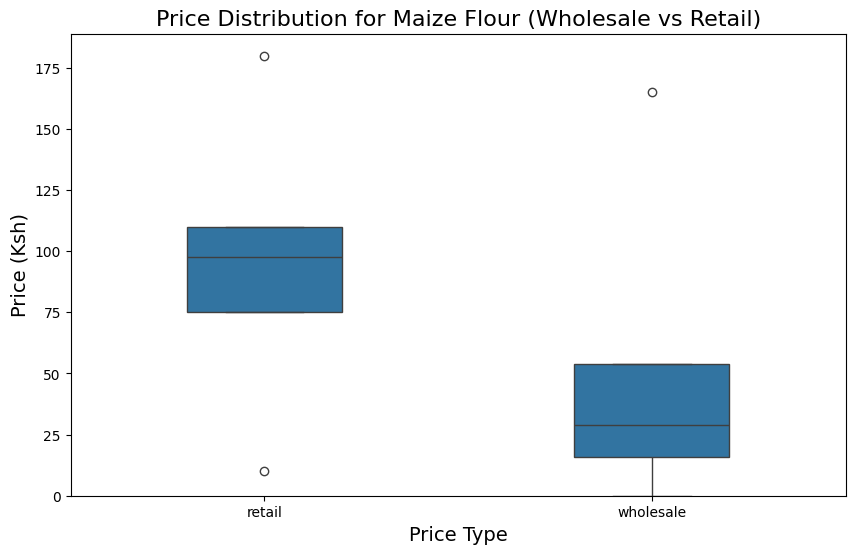

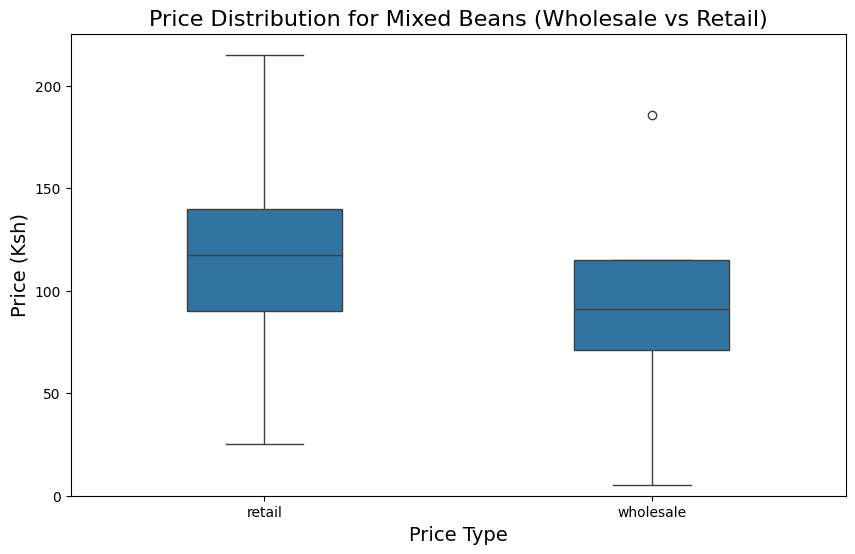

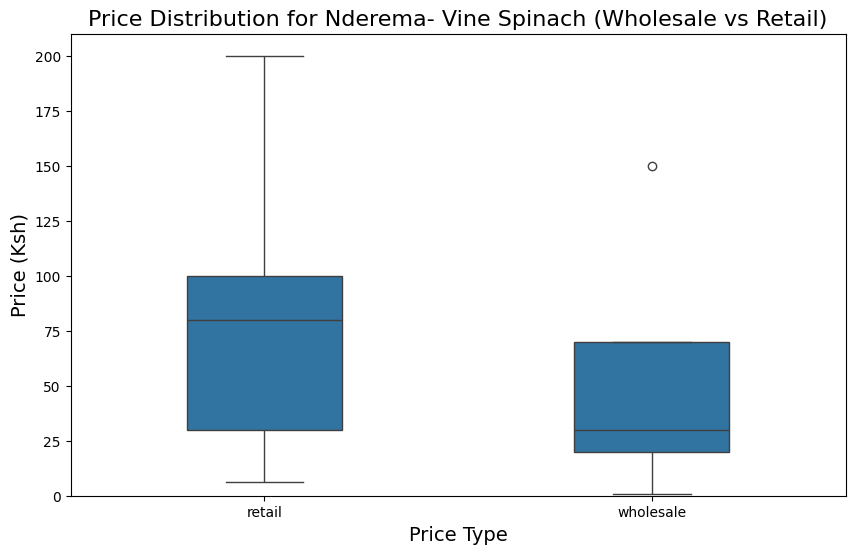

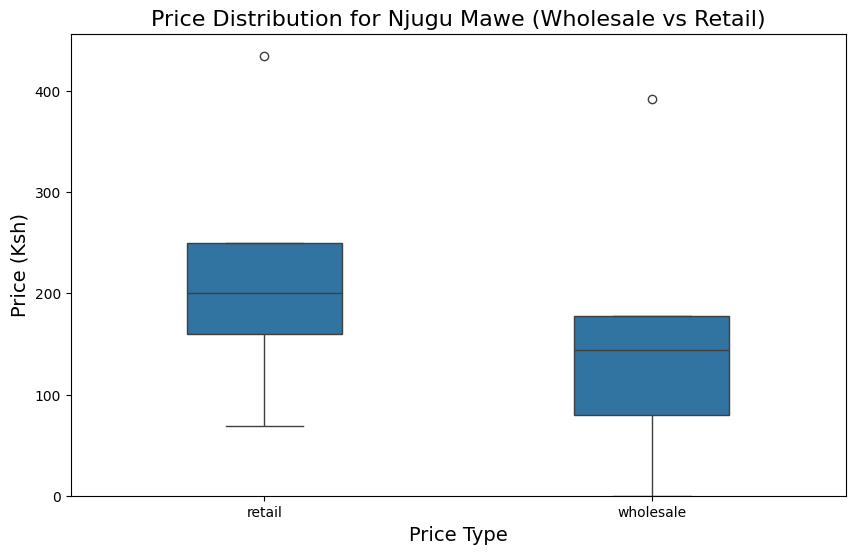

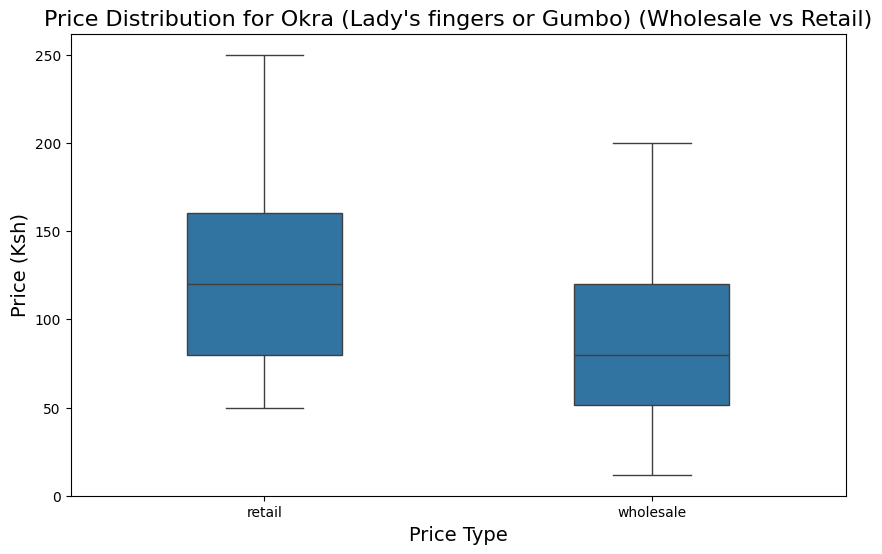

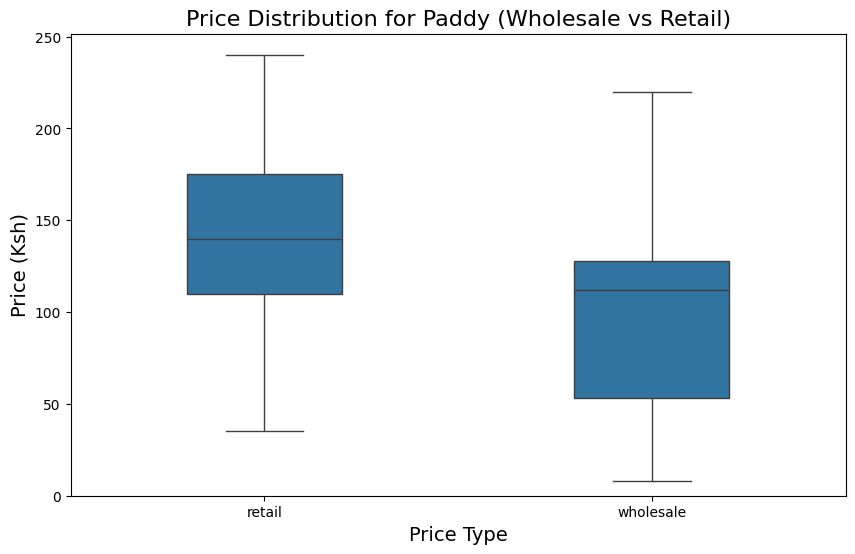

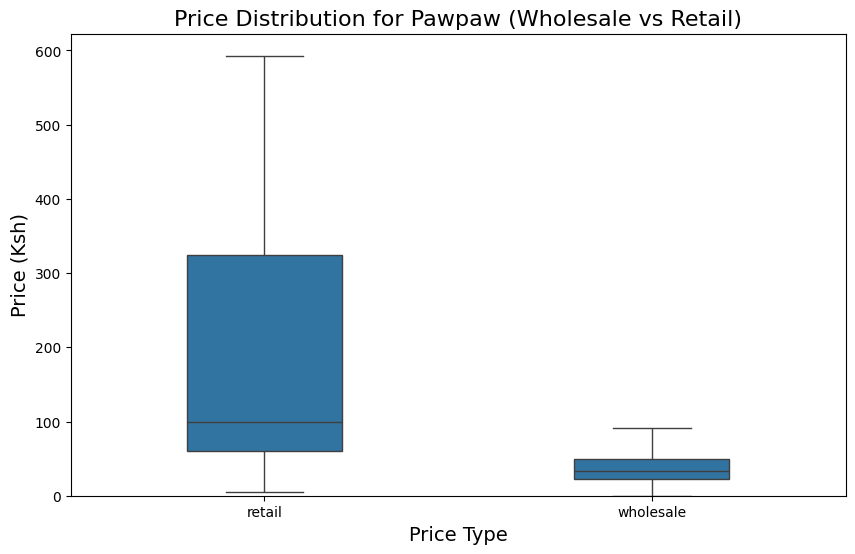

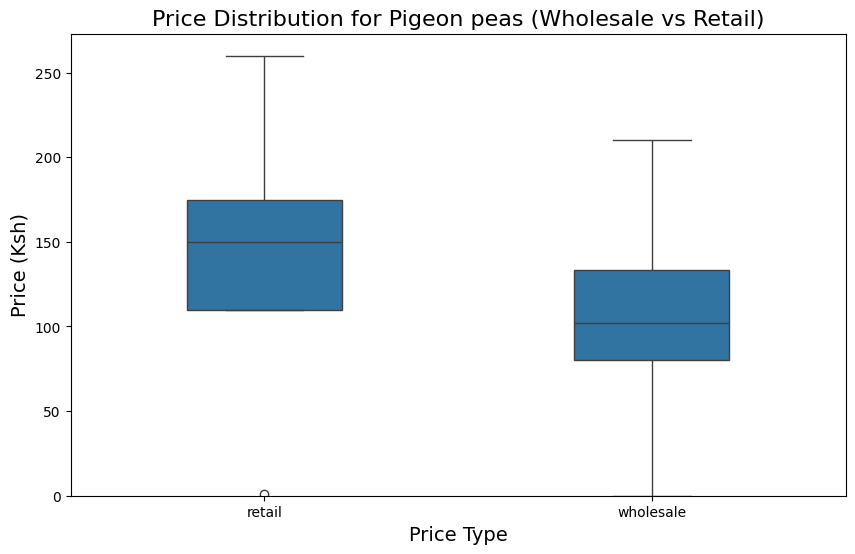

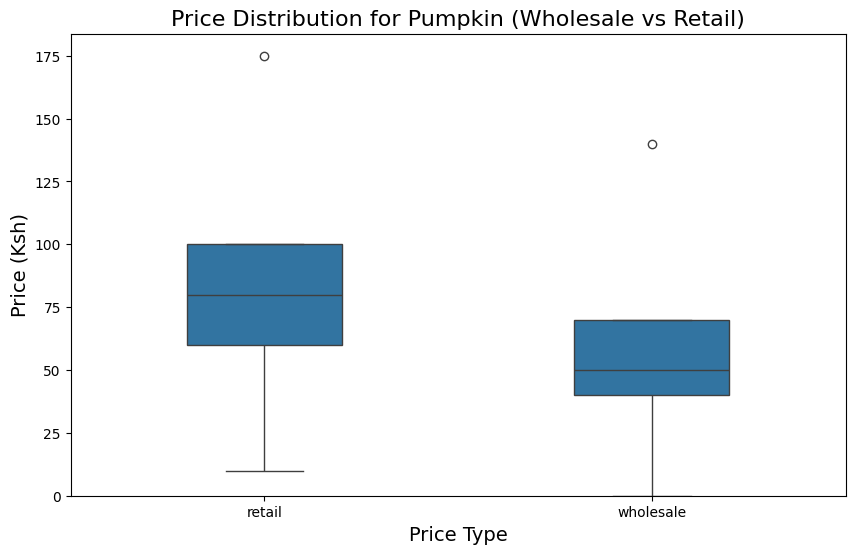

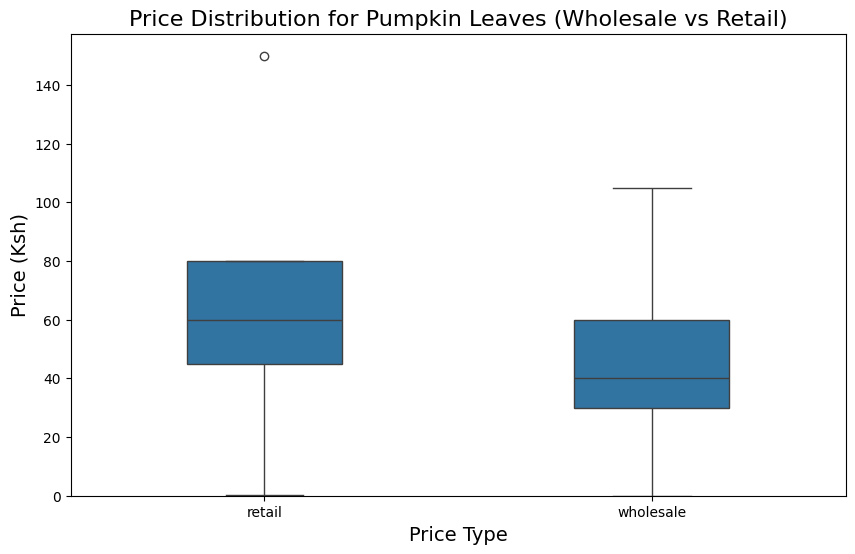

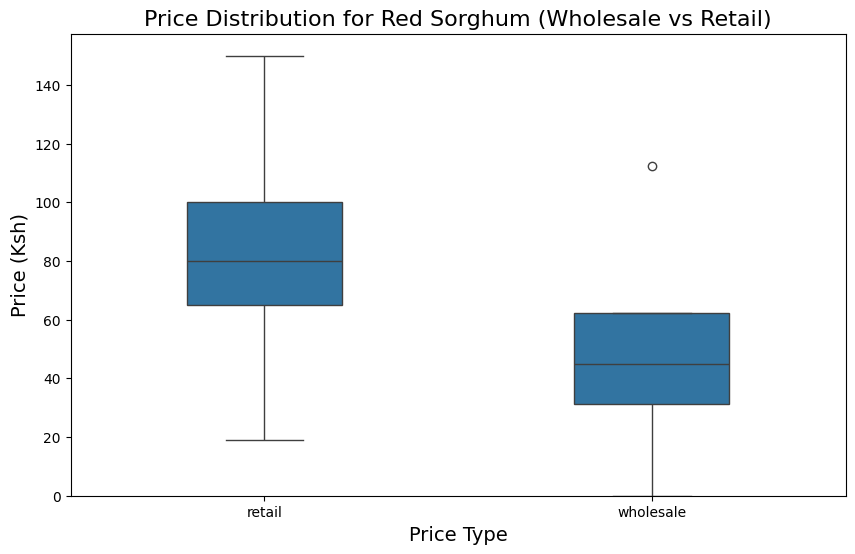

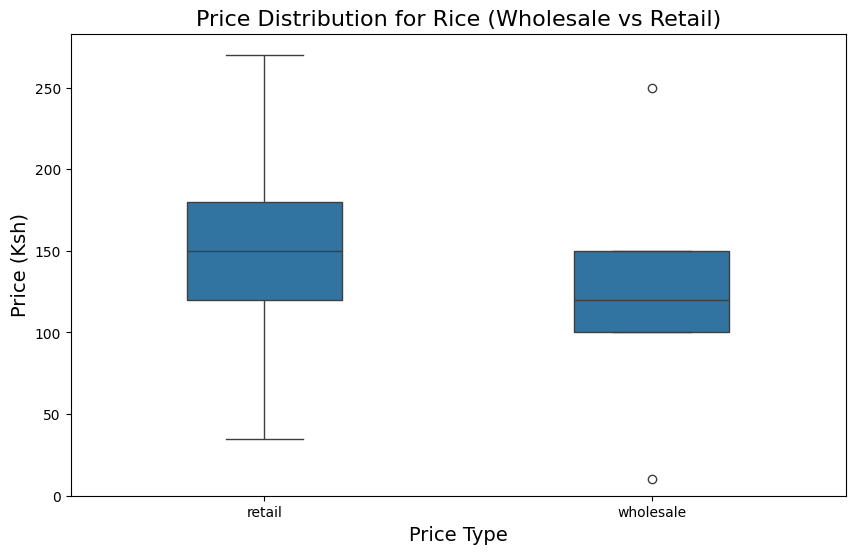

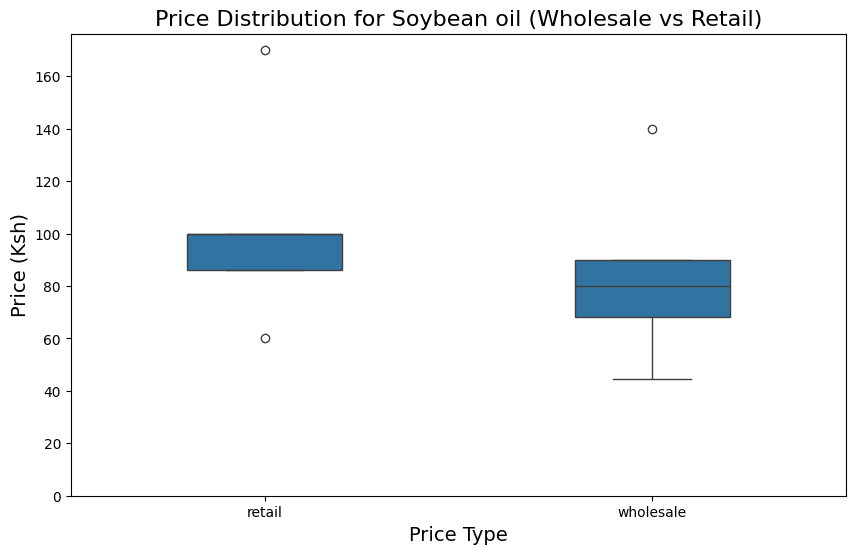

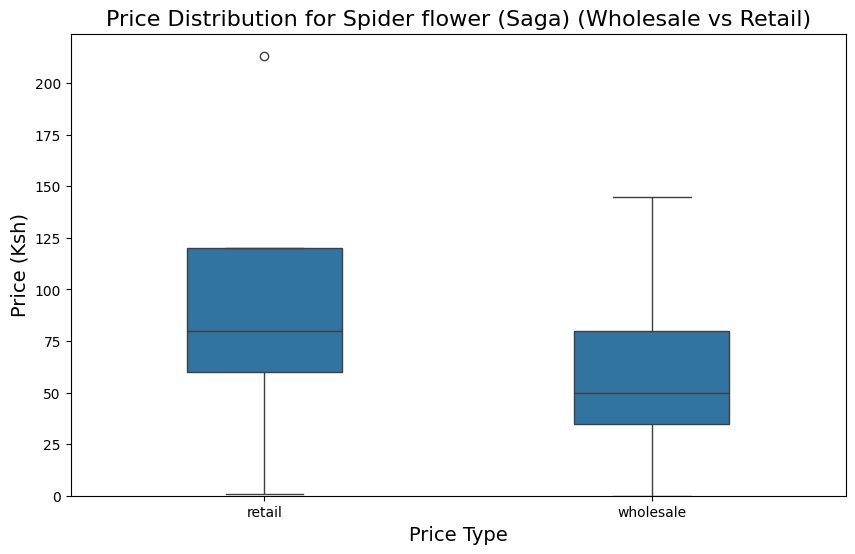

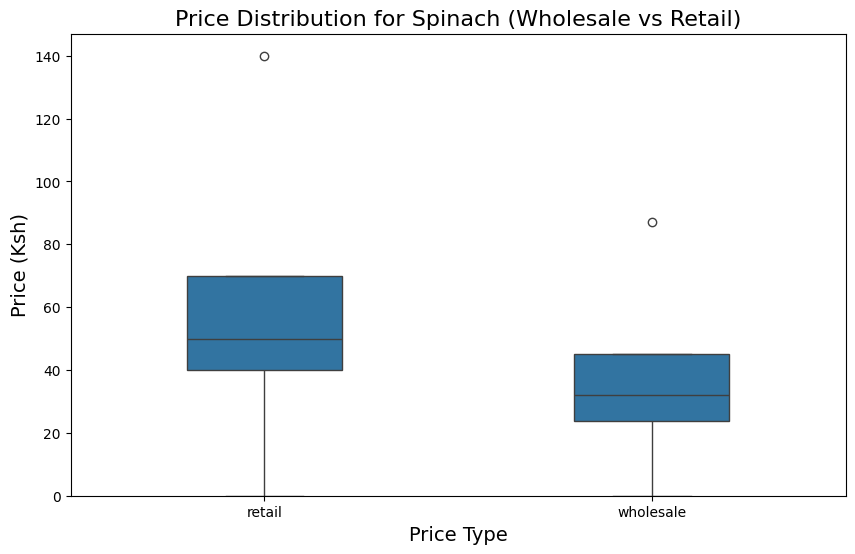

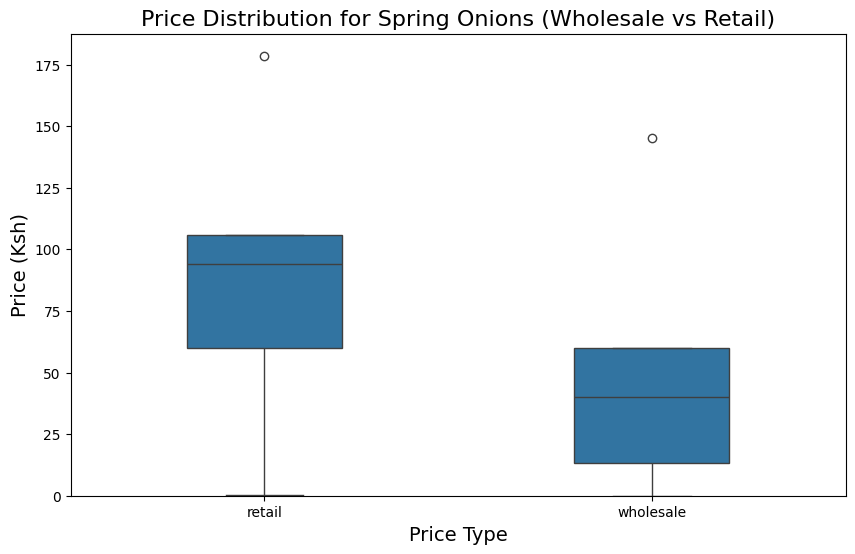

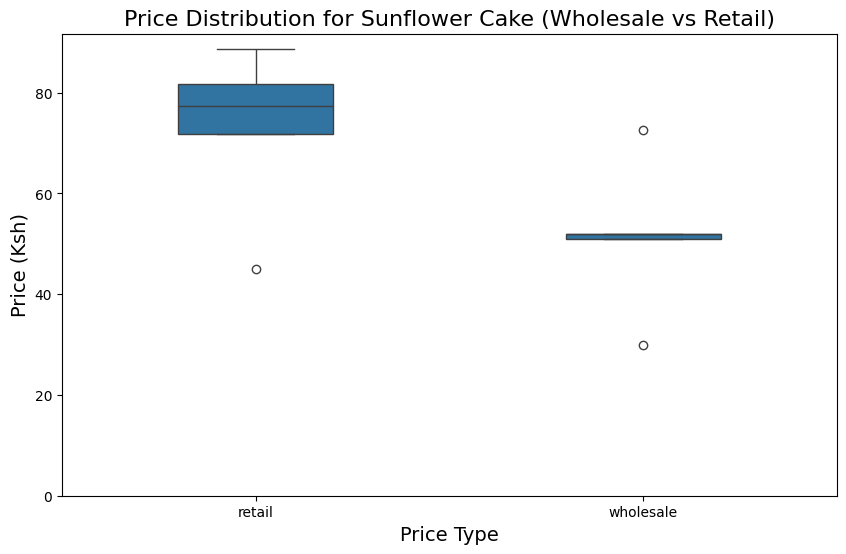

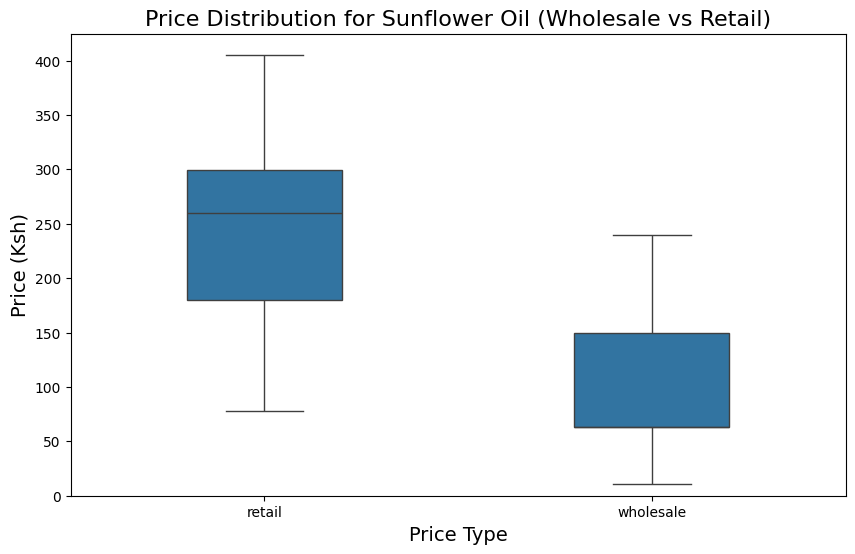

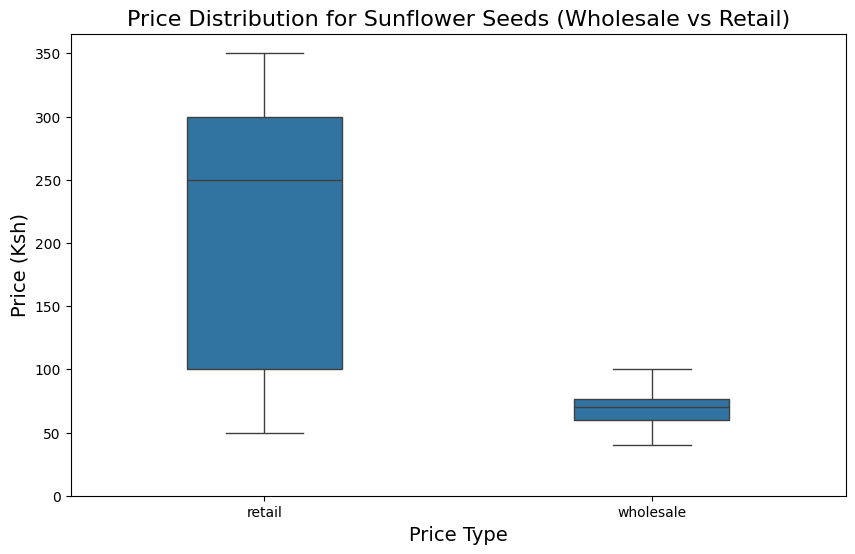

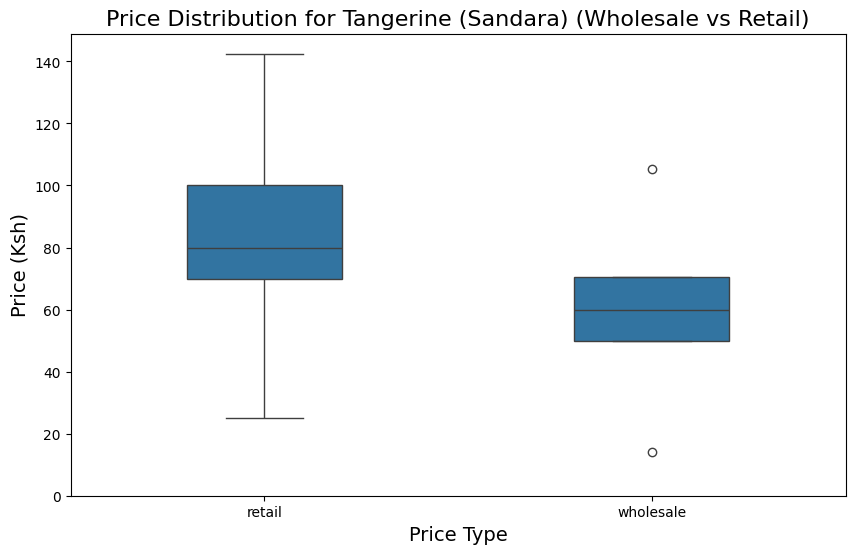

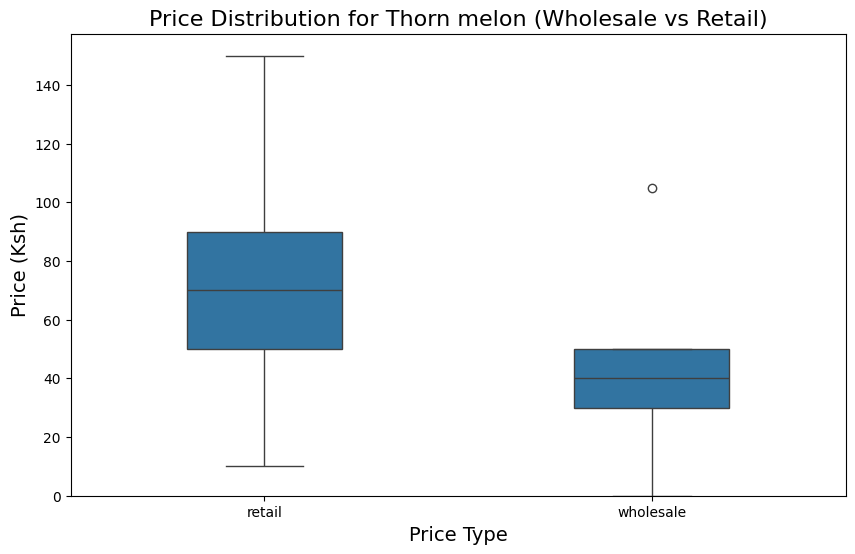

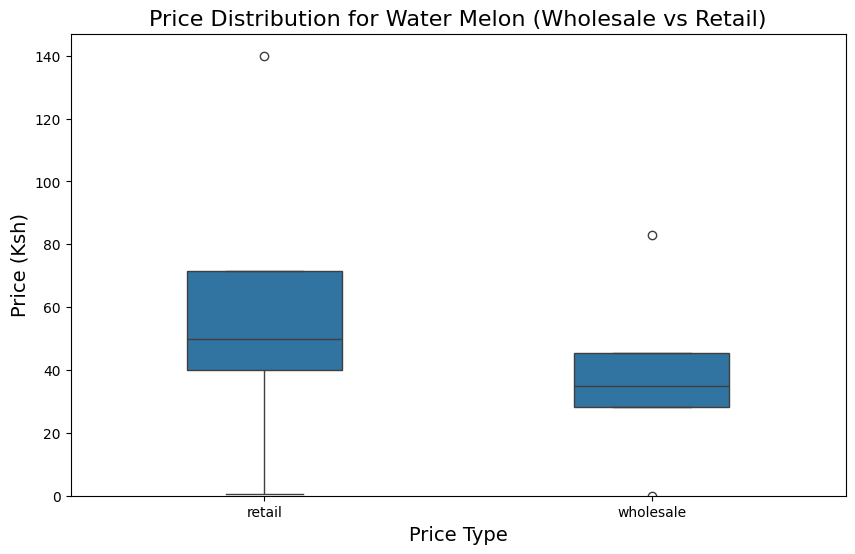

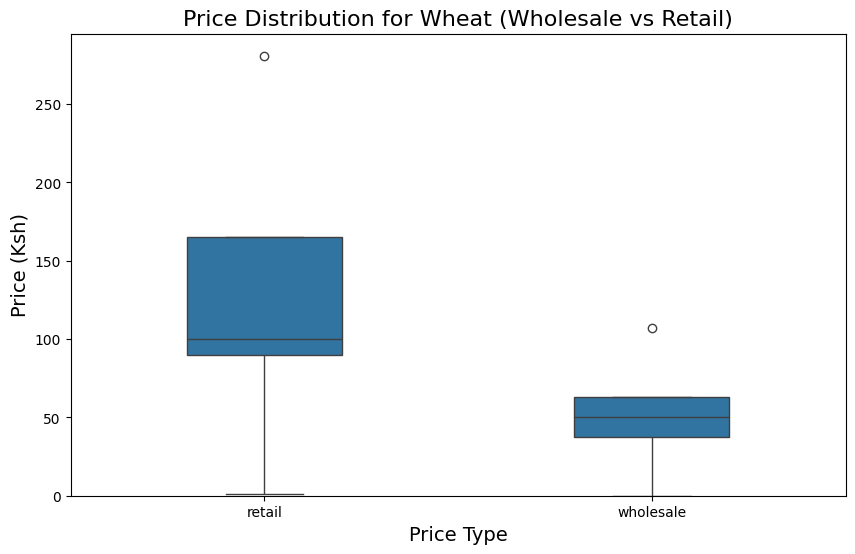

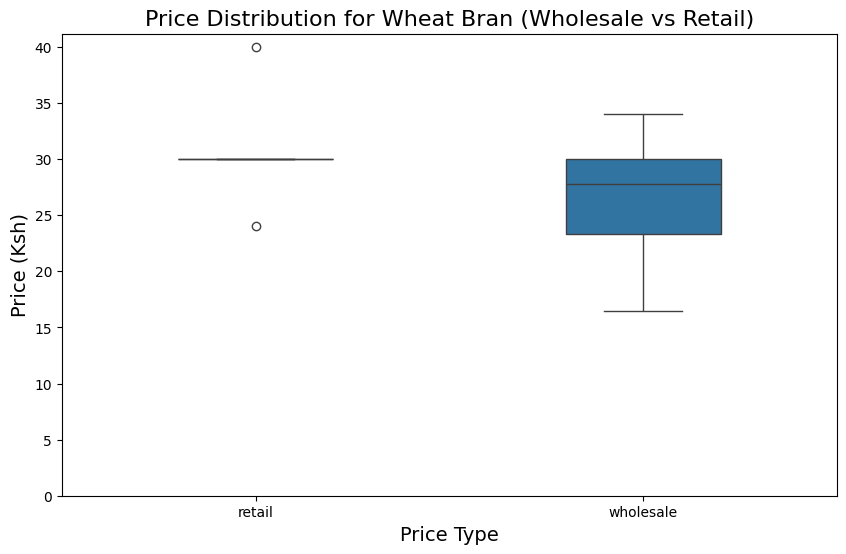

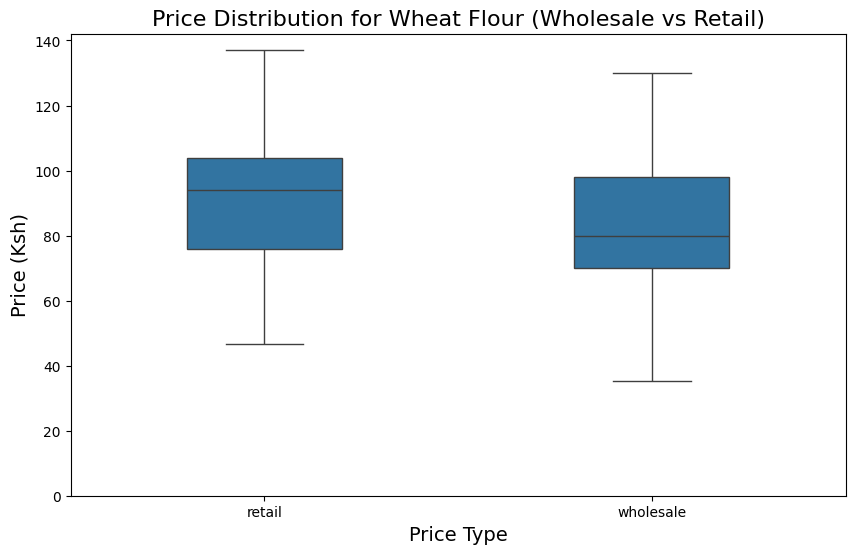

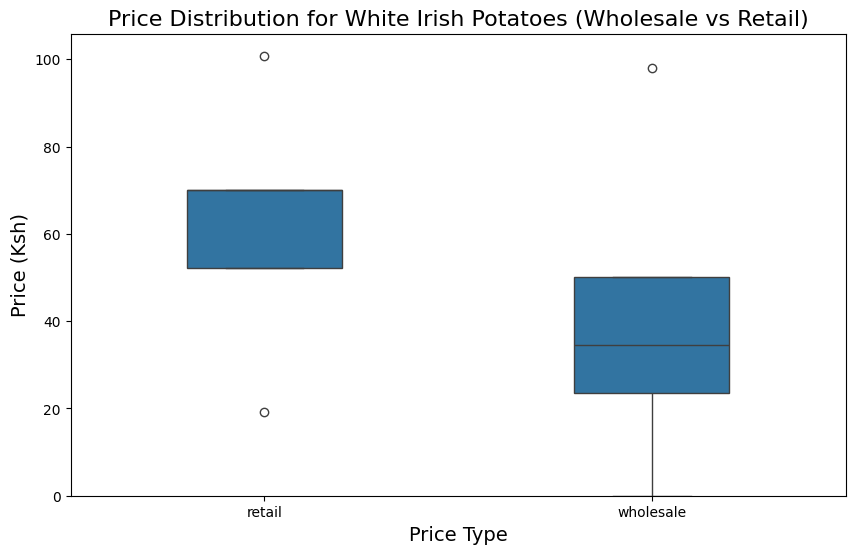

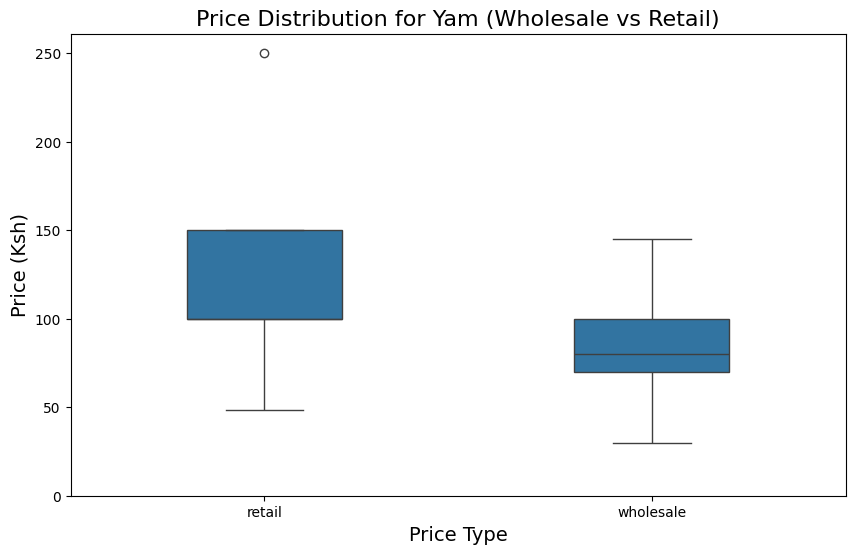

In [5]:
# Create a new DataFrame with long format for plotting all percentiles
long_format = combined_percentiles.melt(
    id_vars=['commodity', 'price_type'],
    value_vars=['min', '25%', '50%', '75%', 'max'],
    var_name='Percentile',
    value_name='Price'
)

# Loop through each commodity and create a box plot with adjusted settings
for commodity in combined_percentiles['commodity'].unique():
    # Filter data for the specific commodity
    data_filtered = long_format[long_format['commodity'] == commodity]
    
    # Create a new figure for each commodity
    plt.figure(figsize=(10, 6))
    
    # Create the box plot
    sns.boxplot(data=data_filtered, x='price_type', y='Price', width=0.4)
    
    # Set plot title and labels
    plt.title(f"Price Distribution for {commodity} (Wholesale vs Retail)", fontsize=16)
    plt.xlabel("Price Type", fontsize=14)
    plt.ylabel("Price (Ksh)", fontsize=14)
    
    # Adjust y-axis limit or scale (if necessary, depending on data distribution)
    plt.ylim(bottom=0)  # Ensure the lower limit is 0 for clarity
    
    # Display the plot
    plt.show()


### Data Quality Considerations

1. **Suspicious Price Ranges**: Certain commodities, such as *Capsicums* and *Cassava Fresh*, exhibit unrealistic price ranges that suggest errors in the data collection process. These products have extreme or implausible values and should be excluded from further analysis to avoid skewing results.

2. **Inconsistent Retail and Wholesale Pricing**: For several commodities, the retail prices are observed to be lower than the corresponding wholesale prices. This is an anomaly that warrants further investigation, as retail prices are typically expected to be higher than wholesale prices. Identifying the source of this discrepancy will be crucial for ensuring the accuracy of the dataset.

3. **Near-Zero Prices**: Some commodities have prices that are close to or equal to zero. These values likely represent missing or incorrectly entered data and need to be addressed. Such prices can distort summary statistics and visualizations, so they should either be corrected or removed.

4. **Uniform Price Bounds**: In some cases, the 25th and 75th percentile values are identical, suggesting that the data may contain repeated values or lack sufficient variability. Outliers can be effectively identified and removed in these instances to clean up the data.

5. **Reasonable Interquartile Ranges (IQR)**: A majority of the commodities show reasonable interquartile ranges (IQRs), indicating that the IQR is a better representation of the data's variability than the absolute minimum and maximum values. In these cases, focusing on the IQR for analysis and treating values outside this range as potential outliers may provide a more reliable understanding of price distributions.


In [6]:
# Make a copy of the original dataset
data_original = data.copy()

In [7]:
# Filter by date (July 1st, 2021 to June 30th, 2024) without dropping columns
data = data[(data['date'] >= '2021-07-01') & (data['date'] <= '2024-06-30')]

# Drop only suspicious commodities: Capsicums and Cassava Fresh
# No other columns should be dropped yet
data = data[~data['commodity'].isin(['Capsicums', 'Cassava Fresh'])]

In [9]:
# Function to calculate IQR and count records inside/outside IQR and identify outliers
def calculate_iqr_and_outliers(df, price_column):
    # Calculate 25th and 75th percentiles (IQR bounds)
    Q1 = df[price_column].quantile(0.25)
    Q3 = df[price_column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Total number of records
    total_count = df.shape[0]
    
    # Count records inside the IQR (between 25% and 75%)
    inside_iqr_count = df[(df[price_column] >= Q1) & (df[price_column] <= Q3)].shape[0]
    
    # Count records outside the IQR but within the lower and upper bounds
    outside_iqr_inside_bounds_count = df[((df[price_column] < Q1) | (df[price_column] > Q3)) & 
                                         (df[price_column] >= lower_bound) & (df[price_column] <= upper_bound)].shape[0]
    
    # Count of outliers (below lower bound or above upper bound)
    outliers_count = df[(df[price_column] < lower_bound) | (df[price_column] > upper_bound)].shape[0]
    
    return total_count, inside_iqr_count, outside_iqr_inside_bounds_count, outliers_count, Q1, Q3, lower_bound, upper_bound

# Initialize lists to store results
commodity_names = []
price_type_list = []
total_counts = []
inside_iqr_counts = []
outside_iqr_counts = []
outliers_counts = []
iqr_min_list = []
iqr_max_list = []
lower_bound_list = []
upper_bound_list = []

# Loop through all unique commodities and calculate for wholesale and retail prices
for commodity in data['commodity'].unique():
    # Filter the data for the current commodity
    commodity_data = data[data['commodity'] == commodity]
    
    # Calculate for Wholesale Prices
    total_count, inside_iqr_count, outside_iqr_inside_bounds_count, outliers_count, Q1, Q3, lower_bound, upper_bound = calculate_iqr_and_outliers(commodity_data, 'wholesale_price_ksh')
    commodity_names.append(commodity)
    price_type_list.append("wholesale")
    total_counts.append(total_count)
    inside_iqr_counts.append(inside_iqr_count)
    outside_iqr_counts.append(outside_iqr_inside_bounds_count)
    outliers_counts.append(outliers_count)
    iqr_min_list.append(Q1)
    iqr_max_list.append(Q3)
    lower_bound_list.append(lower_bound)
    upper_bound_list.append(upper_bound)
    
    # Calculate for Retail Prices
    total_count, inside_iqr_count, outside_iqr_inside_bounds_count, outliers_count, Q1, Q3, lower_bound, upper_bound = calculate_iqr_and_outliers(commodity_data, 'retail_price_ksh')
    commodity_names.append(commodity)
    price_type_list.append("retail")
    total_counts.append(total_count)
    inside_iqr_counts.append(inside_iqr_count)
    outside_iqr_counts.append(outside_iqr_inside_bounds_count)
    outliers_counts.append(outliers_count)
    iqr_min_list.append(Q1)
    iqr_max_list.append(Q3)
    lower_bound_list.append(lower_bound)
    upper_bound_list.append(upper_bound)

# Combine results into a DataFrame for review
result_df = pd.DataFrame({
    'Commodity': commodity_names,
    'Price Type': price_type_list,
    'Total Records': total_counts,
    'Inside IQR Count': inside_iqr_counts,
    'Outside IQR Count': outside_iqr_counts,
    'Outliers Count': outliers_counts,
    'IQR Min': iqr_min_list,
    'IQR Max': iqr_max_list,
    'Lower Bound': lower_bound_list,
    'Upper Bound': upper_bound_list
})

# Display the final DataFrame
import IPython.display as display
display.display(result_df)


Commodity Price Type  Total Records  \
0                           Arrow Root  wholesale           7550   
1                           Arrow Root     retail           7550   
2              Beans (Canadian wonder)  wholesale           2038   
3              Beans (Canadian wonder)     retail           2038   
4                   Beans (Mwezi Moja)  wholesale           4231   
5                   Beans (Mwezi Moja)     retail           4231   
6                             Broccoli  wholesale           2244   
7                             Broccoli     retail           2244   
8                           Butternuts  wholesale           5449   
9                           Butternuts     retail           5449   
10                 Cassava Chips (dry)  wholesale           3200   
11                 Cassava Chips (dry)     retail           3200   
12                         Cauliflower  wholesale           1701   
13                         Cauliflower     retail           1701   
14                            Chillies  wholesale           5901   
15                            Chillies     retail           5901   
16                  Coriander (Dhania)  wholesale           7365   
17                  Coriander (Dhania)     retail           7365   
18                           Courgette  wholesale           3935   
19                           Courgette     retail           3935   
20                             Cowpeas  wholesale           6525   
21                             Cowpeas     retail           6525   
22               Cowpea leaves (Kunde)  wholesale           4999   
23               Cowpea leaves (Kunde)     retail           4999   
24                           Dry Maize  wholesale          13863   
25                           Dry Maize     retail          13863   
26                          Dry Onions  wholesale          13110   
27                          Dry Onions     retail          13110   
28                            Dry Peas  wholesale           1994   
29                            Dry Peas     retail           1994   
30                Egg plant (Brinjals)  wholesale           4361   
31                Egg plant (Brinjals)     retail           4361   
32           Ethiopian Kales - Kanzira  wholesale           1100   
33           Ethiopian Kales - Kanzira     retail           1100   
34                        French beans  wholesale           2018   
35                        French beans     retail           2018   
36                          Fresh Peas  wholesale           4589   
37                          Fresh Peas     retail           4589   
38                              Garlic  wholesale           5726   
39                              Garlic     retail           5726   
40                              Ginger  wholesale           5321   
41                              Ginger     retail           5321   
42                         Green Grams  wholesale          13028   
43                         Green Grams     retail          13028   
44                         Green Maize  wholesale           6367   
45                         Green Maize     retail           6367   
46                         Ground Nuts  wholesale           8470   
47                         Ground Nuts     retail           8470   
48   Indigenous Crotolaria (Mito/Miro)  wholesale           2141   
49   Indigenous Crotolaria (Mito/Miro)     retail           2141   
50                             Lentils  wholesale           4076   
51                             Lentils     retail           4076   
52                             Lettuce  wholesale            985   
53                             Lettuce     retail            985   
54                          Maize Bran  wholesale            200   
55                          Maize Bran     retail            200   
56                         Maize Flour  wholesale           8873   
57                         Maize Flour     retail           8873   
58               

As we proceed to make decisions about handling outliers in the data, there are a few key points to consider:

1. Objective: Since the goal is to provide meaningful, typical price ranges for smallholder farmers and market players, we must decide whether to cap values outside the IQR or drop them entirely. Both approaches have advantages and challenges: Capping values ensures that we retain most of the data while fitting them within typical price ranges. This may help when we have significant records outside the IQR, but it also smooths out extremes. Dropping values ensures that we only keep records that truly reflect typical prices. However, this could lead to data loss, especially when the counts of values within and without the IQR are almost equal. The best approach would be to approach each commodity appropriately, capping according to the IQR or the upper and lower bounds based on the values, or dropping extreme erroneous case outliers. This will also be determined using domain knowledge on reasonable ranges per commodity.

2. For a meaningful time-series analysis, I will retain commodities with a minimum of 500 records and above.

3. After inspection, commodities to be capped by upper and lower bounds are: Ginger, Garlic, Soybean Oil and Sunflower Cake. The rest will be capped with the IQR.

In [10]:
# Filter out commodities with fewer than 500 records
data_filtered = data.groupby('commodity').filter(lambda x: len(x) >= 500)

# Check the number of remaining records and commodities
print("Filtered Data Shape:", data_filtered.shape)
print("Unique Commodities Remaining:", data_filtered['commodity'].nunique())

Filtered Data Shape: (295259, 8)
Unique Commodities Remaining: 55


In [11]:
# Function to cap values based on bounds
def cap_values_by_bounds(df, price_column, lower_bound, upper_bound):
    df[price_column] = df[price_column].apply(lambda x: max(min(x, upper_bound), lower_bound))
    return df

# List of commodities to cap by upper and lower bounds
cap_by_bounds = ['Ginger', 'Garlic', 'Soybean Oil', 'Sunflower Cake']

# Loop through each commodity to cap wholesale and retail prices
for commodity in cap_by_bounds:
    commodity_data = data_filtered[data_filtered['commodity'] == commodity]
    
    # Calculate IQR, bounds for wholesale prices
    _, _, _, _, Q1_wholesale, Q3_wholesale, lower_bound_wholesale, upper_bound_wholesale = calculate_iqr_and_outliers(commodity_data, 'wholesale_price_ksh')
    # Calculate IQR, bounds for retail prices
    _, _, _, _, Q1_retail, Q3_retail, lower_bound_retail, upper_bound_retail = calculate_iqr_and_outliers(commodity_data, 'retail_price_ksh')
    
    # Apply capping by bounds for wholesale and retail prices
    data_filtered.loc[data_filtered['commodity'] == commodity, 'wholesale_price_ksh'] = cap_values_by_bounds(
        commodity_data, 'wholesale_price_ksh', lower_bound_wholesale, upper_bound_wholesale
    )
    data_filtered.loc[data_filtered['commodity'] == commodity, 'retail_price_ksh'] = cap_values_by_bounds(
        commodity_data, 'retail_price_ksh', lower_bound_retail, upper_bound_retail
    )

print("Capping by bounds completed for selected commodities.")

Capping by bounds completed for selected commodities.


In [12]:
# Function to cap values based on IQR
def cap_values_by_iqr(df, price_column, Q1, Q3):
    df[price_column] = df[price_column].apply(lambda x: max(min(x, Q3), Q1))
    return df

# Loop through remaining commodities to cap wholesale and retail prices using IQR
for commodity in data_filtered['commodity'].unique():
    if commodity not in cap_by_bounds:
        commodity_data = data_filtered[data_filtered['commodity'] == commodity]
        
        # Calculate IQR for wholesale prices
        _, _, _, _, Q1_wholesale, Q3_wholesale, _, _ = calculate_iqr_and_outliers(commodity_data, 'wholesale_price_ksh')
        # Calculate IQR for retail prices
        _, _, _, _, Q1_retail, Q3_retail, _, _ = calculate_iqr_and_outliers(commodity_data, 'retail_price_ksh')
        
        # Apply capping by IQR for wholesale and retail prices
        data_filtered.loc[data_filtered['commodity'] == commodity, 'wholesale_price_ksh'] = cap_values_by_iqr(
            commodity_data, 'wholesale_price_ksh', Q1_wholesale, Q3_wholesale
        )
        data_filtered.loc[data_filtered['commodity'] == commodity, 'retail_price_ksh'] = cap_values_by_iqr(
            commodity_data, 'retail_price_ksh', Q1_retail, Q3_retail
        )

print("Capping by IQR completed for the remaining commodities.")

Capping by IQR completed for the remaining commodities.


In [13]:
# Initialize an empty list to store the results
describe_stats = []

# Loop through all unique commodities
for commodity in data_filtered['commodity'].unique():
    # Filter the data for the current commodity
    commodity_data = data_filtered[data_filtered['commodity'] == commodity]
    
    # Describe wholesale prices
    wholesale_stats = commodity_data['wholesale_price_ksh'].describe().to_frame().T
    wholesale_stats['Commodity'] = commodity
    wholesale_stats['Price Type'] = 'wholesale'
    
    # Describe retail prices
    retail_stats = commodity_data['retail_price_ksh'].describe().to_frame().T
    retail_stats['Commodity'] = commodity
    retail_stats['Price Type'] = 'retail'
    
    # Append both wholesale and retail stats to the list
    describe_stats.append(wholesale_stats)
    describe_stats.append(retail_stats)

# Combine all the stats into a single DataFrame
describe_df = pd.concat(describe_stats)

# Reorder the columns to have 'Commodity' and 'Price Type' at the front
describe_df = describe_df[['Commodity', 'Price Type'] + list(wholesale_stats.columns[:-2])]

# Reset the index for a clean output
describe_df.reset_index(drop=True, inplace=True)

# Output the final DataFrame to inspect
describe_df

Commodity Price Type    count        mean  \
0                           Arrow Root  wholesale   7550.0   85.183376   
1                           Arrow Root     retail   7550.0  121.858026   
2              Beans (Canadian wonder)  wholesale   2038.0   99.858408   
3              Beans (Canadian wonder)     retail   2038.0  125.215704   
4                   Beans (Mwezi Moja)  wholesale   4231.0  102.143999   
5                   Beans (Mwezi Moja)     retail   4231.0  126.234576   
6                             Broccoli  wholesale   2244.0   80.843282   
7                             Broccoli     retail   2244.0  118.450644   
8                           Butternuts  wholesale   5449.0   56.922957   
9                           Butternuts     retail   5449.0   81.738979   
10                 Cassava Chips (dry)  wholesale   3200.0   56.885362   
11                 Cassava Chips (dry)     retail   3200.0   81.372553   
12                         Cauliflower  wholesale   1701.0   95.557513   
13                         Cauliflower     retail   1701.0  145.068907   
14                            Chillies  wholesale   5901.0   79.804370   
15                            Chillies     retail   5901.0  122.508565   
16                  Coriander (Dhania)  wholesale   7365.0   72.488407   
17                  Coriander (Dhania)     retail   7365.0  110.967566   
18                           Courgette  wholesale   3935.0   65.145860   
19                           Courgette     retail   3935.0   96.154325   
20                             Cowpeas  wholesale   6525.0   94.171293   
21                             Cowpeas     retail   6525.0  128.332761   
22               Cowpea leaves (Kunde)  wholesale   4999.0   38.488116   
23               Cowpea leaves (Kunde)     retail   4999.0   55.120805   
24                           Dry Maize  wholesale  13863.0   50.062712   
25                           Dry Maize     retail  13863.0   64.155495   
26                          Dry Onions  wholesale  13110.0   64.273180   
27                          Dry Onions     retail  13110.0   92.627817   
28                            Dry Peas  wholesale   1994.0  129.288611   
29                            Dry Peas     retail   1994.0  165.146555   
30                Egg plant (Brinjals)  wholesale   4361.0   44.711762   
31                Egg plant (Brinjals)     retail   4361.0   70.589346   
32           Ethiopian Kales - Kanzira  wholesale   1100.0   53.748736   
33           Ethiopian Kales - Kanzira     retail   1100.0   79.641764   
34                        French beans  wholesale   2018.0   63.459425   
35                        French beans     retail   2018.0   88.030471   
36                          Fresh Peas  wholesale   4589.0   80.402806   
37                          Fresh Peas     retail   4589.0  112.206424   
38                              Garlic  wholesale   5726.0  329.470534   
39                              Garlic     retail   5726.0  417.821822   
40                              Ginger  wholesale   5321.0  122.537316   
41                              Ginger     retail   5321.0  170.457659   
42                         Green Grams  wholesale  13028.0  110.204631   
43                         Green Grams     retail  13028.0  143.430945   
44                         Green Maize  wholesale   6367.0   44.423522   
45                         Green Maize     retail   6367.0   67.763972   
46                         Ground Nuts  wholesale   8470.0  168.841044   
47                         Ground Nuts     retail   8470.0  217.648035   
48   Indigenous Crotolaria (Mito/Miro)  wholesale   2141.0   57.877223   
49   Indigenous Crotolaria (Mito/Miro)     retail   2141.0   83.958818   
50                             Lentils  wholesale   4076.0  171.934852   
51                             Lentils     retail   4076.0  245.859009   
52                             Lettuce  wholesale    985.0   48.217264   
53                             Le

### Volumes:
I will now assess the Volumes Column.

In [14]:
# Summarize the volume supplied (tonnes) for each commodity
volume_summary = data_filtered.groupby('commodity')['volume_supplied_tonnes'].describe()

# Reset the index for easier viewing
volume_summary = volume_summary.reset_index()

# Display the summary of volumes supplied
volume_summary

commodity    count      mean       std      min  \
0                 Amaranthus (Terere)   6571.0  0.531868  0.482146  0.00010   
1                          Arrow Root   7550.0  0.682102  0.563251  0.00035   
2             Beans (Canadian wonder)   2038.0  1.208934  1.194042  0.00200   
3                  Beans (Mwezi Moja)   4231.0  1.250857  1.046708  0.00050   
4         Beans Red Haricot (Wairimu)   7104.0  1.327329  1.175537  0.00020   
5              Beans Rosecoco (Nyayo)   7510.0  1.465878  1.434411  0.00036   
6    Black nightshade (Managu/ Osuga)   7783.0  0.502838  0.384409  0.00010   
7                            Broccoli   2244.0  0.263223  0.237010  0.00300   
8                          Butternuts   5449.0  0.532182  0.492168  0.00100   
9                 Cassava Chips (dry)   3200.0  0.782700  0.705159  0.00200   
10                        Cauliflower   1701.0  0.170263  0.142331  0.00150   
11                           Chillies   5901.0  0.249214  0.236942  0.00100   
12                 Coriander (Dhania)   7365.0  0.337593  0.291359  0.00047   
13                          Courgette   3935.0  0.498542  0.448244  0.00400   
14              Cowpea leaves (Kunde)   4999.0  0.505802  0.462719  0.00100   
15                            Cowpeas   6525.0  0.858393  0.559651  0.00040   
16                           Cucumber   4124.0  0.554903  0.717962  0.00025   
17                          Dry Maize  13863.0  5.795367  5.019130  0.00100   
18                         Dry Onions  13110.0  2.721096  2.142014  0.00070   
19                           Dry Peas   1994.0  0.527368  0.398825  0.00200   
20               Egg plant (Brinjals)   4361.0  0.492420  0.552288  0.00300   
21          Ethiopian Kales - Kanzira   1100.0  0.369335  0.251473  0.00300   
22                       French beans   2018.0  0.392525  0.332956  0.00200   
23                         Fresh Peas   4589.0  0.801256  0.662298  0.00200   
24                             Garlic   5726.0  0.261669  0.268300  0.00030   
25                             Ginger   5321.0  0.306030  0.310509  0.00060   
26                        Green Grams  13028.0  1.727844  1.659859  0.00040   
27                        Green Maize   6367.0  1.684311  1.399549  0.00100   
28                        Ground Nuts   8470.0  0.907179  0.767760  0.00100   
29  Indigenous Crotolaria (Mito/Miro)   2141.0  0.364733  0.298716  0.00100   
30               Jute Plant (Murenda)   2629.0  0.276566  0.222400  0.00035   
31                  Kales/Sukuma Wiki  13045.0  1.229163  1.038769  0.00100   
32                            Lentils   4076.0  1.606719  1.561213  0.00900   
33                            Lettuce    985.0  1.016425  1.378553  0.00300   
34                        Maize Flour   8873.0  1.919906  1.340195  0.00100   
35                        Mixed Beans   2832.0  1.107690  0.840406  0.00120   
36              Nderema- Vine Spinach    879.0  0.239037  0.249440  0.00500   
37                         Njugu Mawe    567.0  0.999233  0.937310  0.01000   
38     Okra (Lady's fingers or Gumbo)    537.0  0.464731  0.446627  0.00300   
39                             Pawpaw   4923.0  0.575160  0.553708  0.00200   
40                        Pigeon peas   4007.0  1.083039  0.928075  0.00500   
41                            Pumpkin   3825.0  0.769698  0.735881  0.00200   
42                     Pumpkin Leaves   3153.0  0.278035  0.239172  0.00100   
43                        Red Sorghum   6974.0  0.877074  0.745634  0.00010   
44                               Rice  10323.0  1.979088  1.898195  0.00050   
45               Spider flower (Saga)   4318.0  0.372064  0.279405  0.00100   
46                            Spinach   9667.0  0.878040  0.832303  0.00100   
47                      Spring Onions   7772.0  1.150250  1.283903  0.00040   
48                Tangerine (Sandara)   1436.0  1.452106  1.360644  0.00100   
49                        Thorn melon   2845.0  0.412262  0.395251  0.00100   

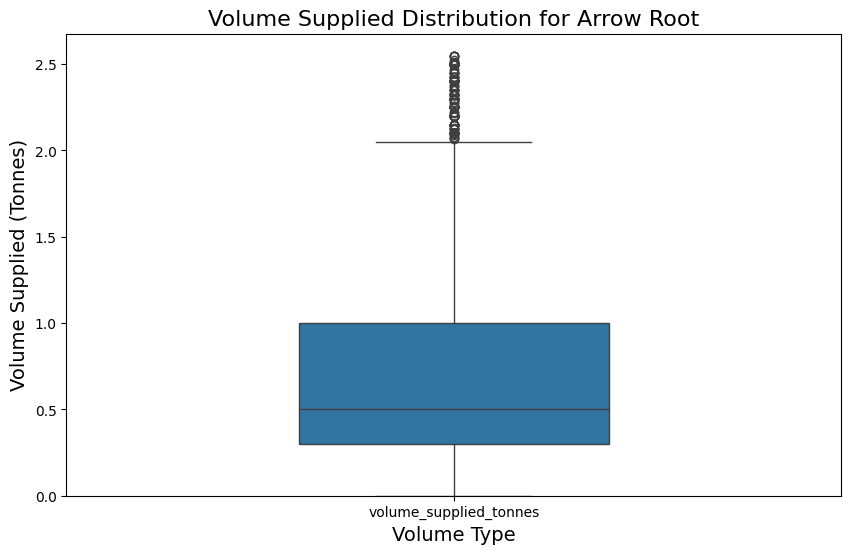

Total number of observations for Arrow Root: 7550
Total number of outliers for Arrow Root: 231 (3.1%)



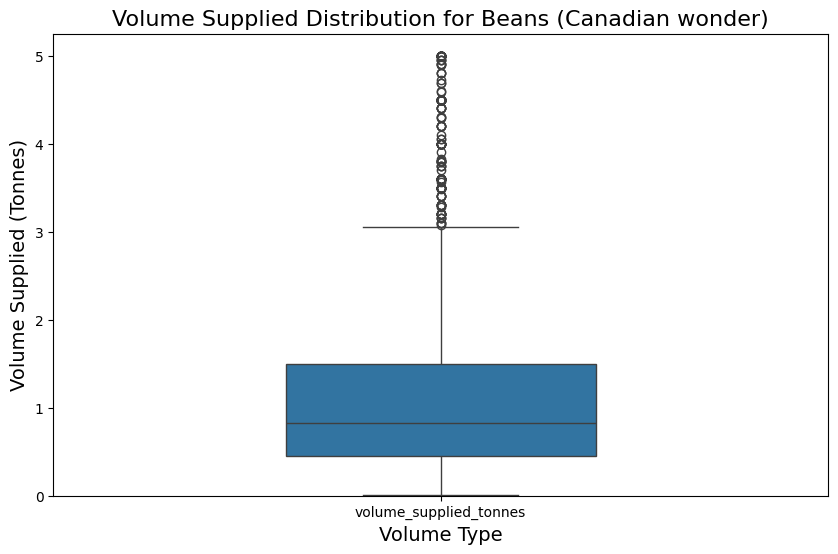

Total number of observations for Beans (Canadian wonder): 2038
Total number of outliers for Beans (Canadian wonder): 210 (10.3%)



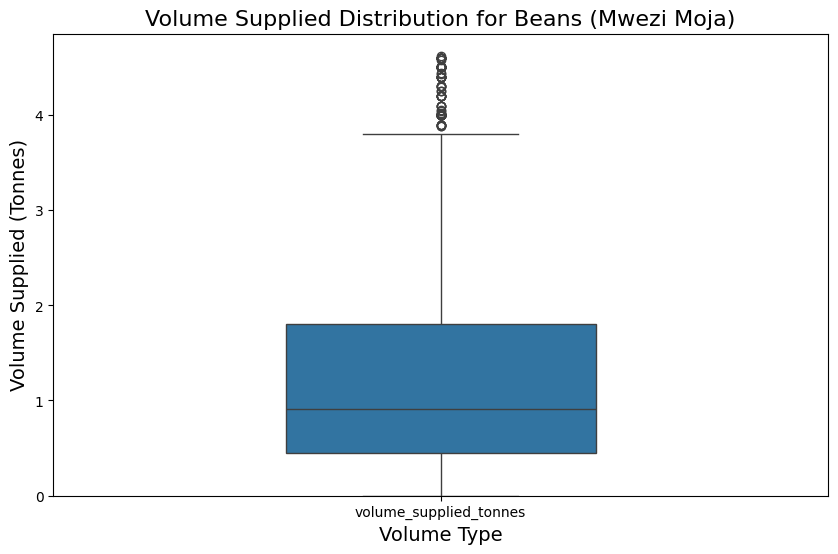

Total number of observations for Beans (Mwezi Moja): 4231
Total number of outliers for Beans (Mwezi Moja): 149 (3.5%)



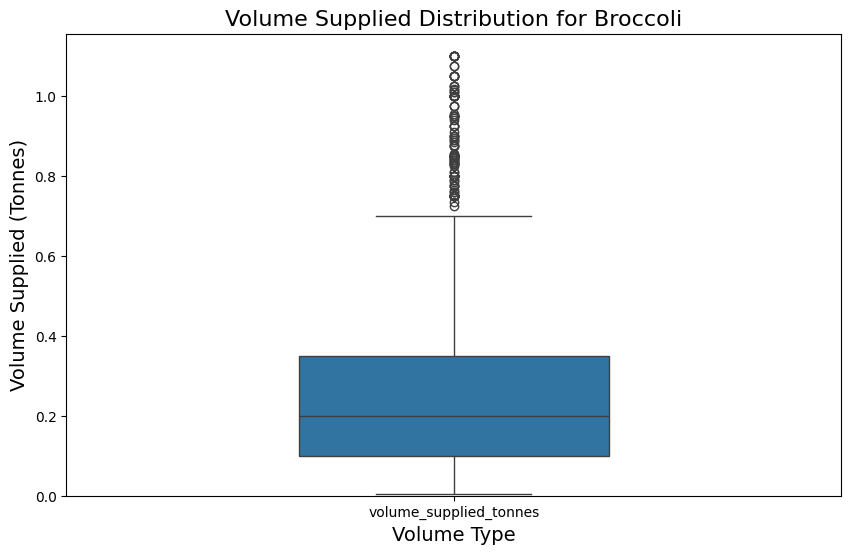

Total number of observations for Broccoli: 2244
Total number of outliers for Broccoli: 157 (7.0%)



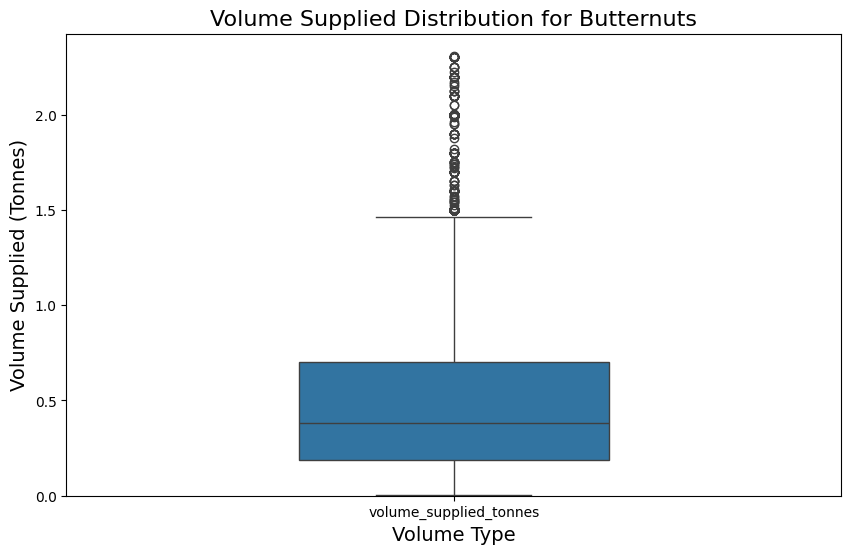

Total number of observations for Butternuts: 5449
Total number of outliers for Butternuts: 423 (7.8%)



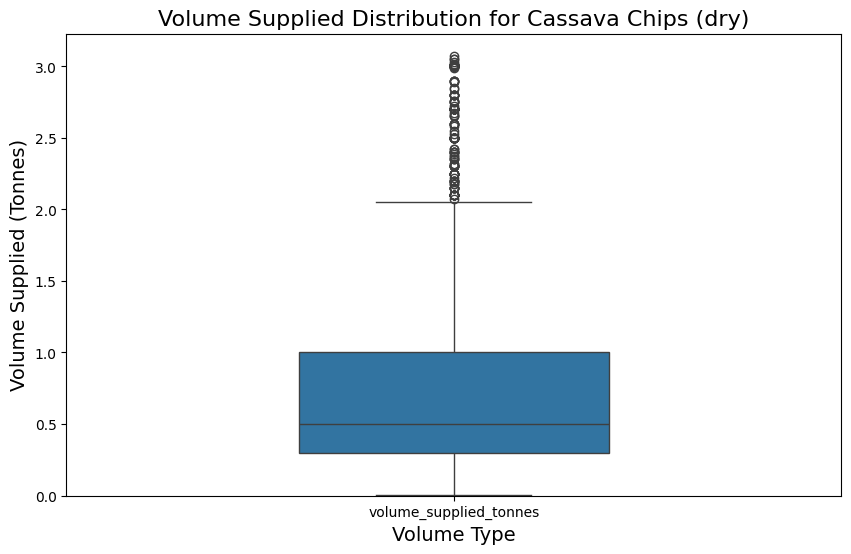

Total number of observations for Cassava Chips (dry): 3200
Total number of outliers for Cassava Chips (dry): 220 (6.9%)



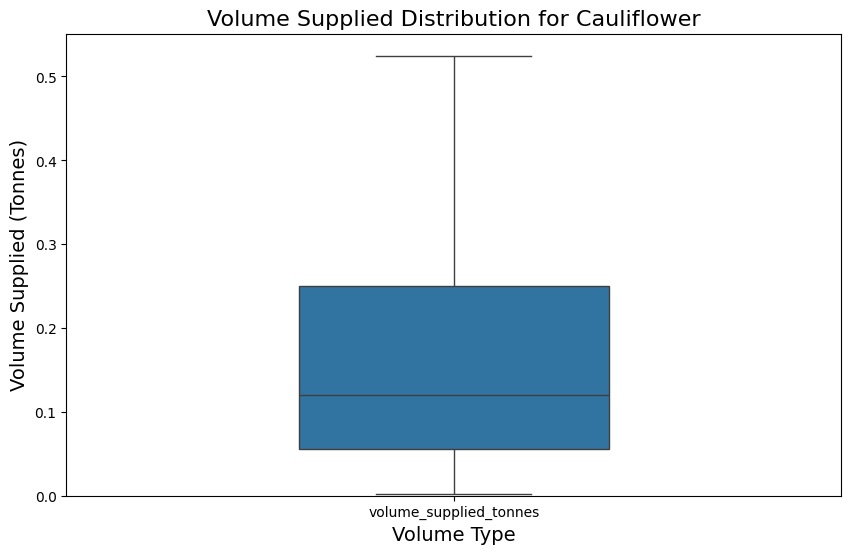

Total number of observations for Cauliflower: 1701
Total number of outliers for Cauliflower: 0 (0.0%)



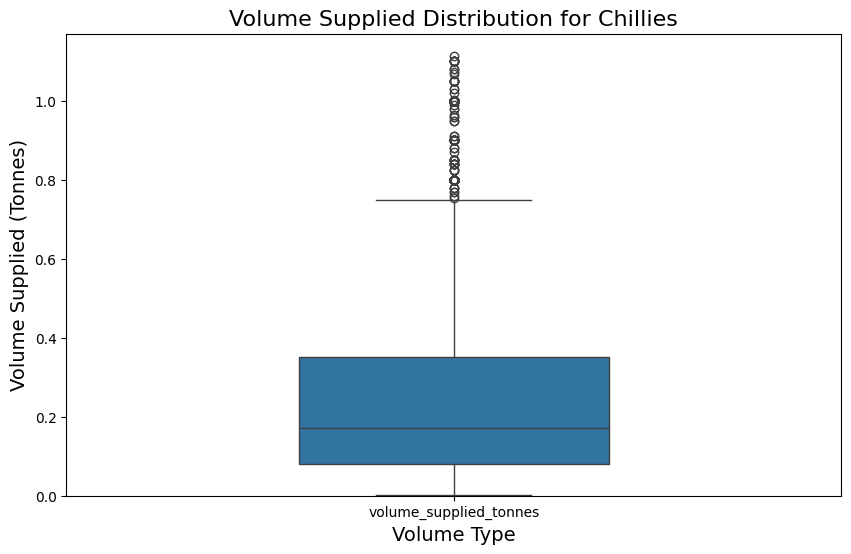

Total number of observations for Chillies: 5901
Total number of outliers for Chillies: 339 (5.7%)



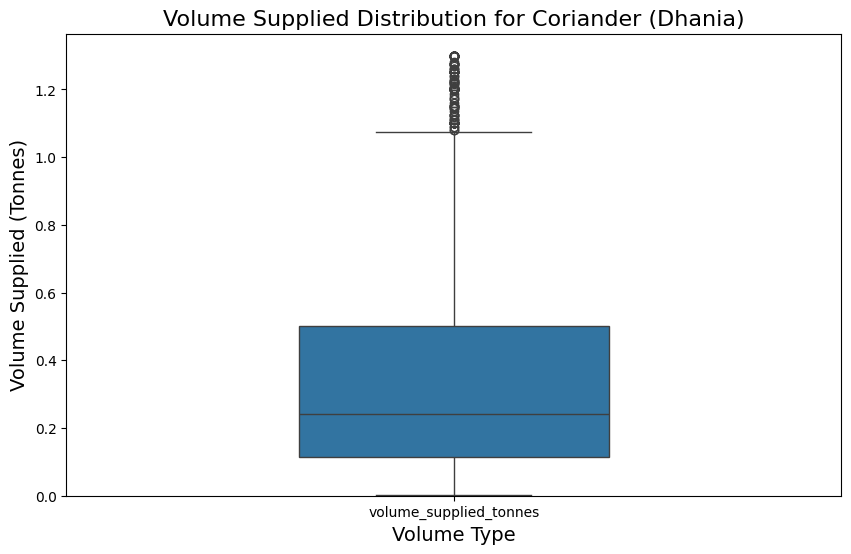

Total number of observations for Coriander (Dhania): 7365
Total number of outliers for Coriander (Dhania): 180 (2.4%)



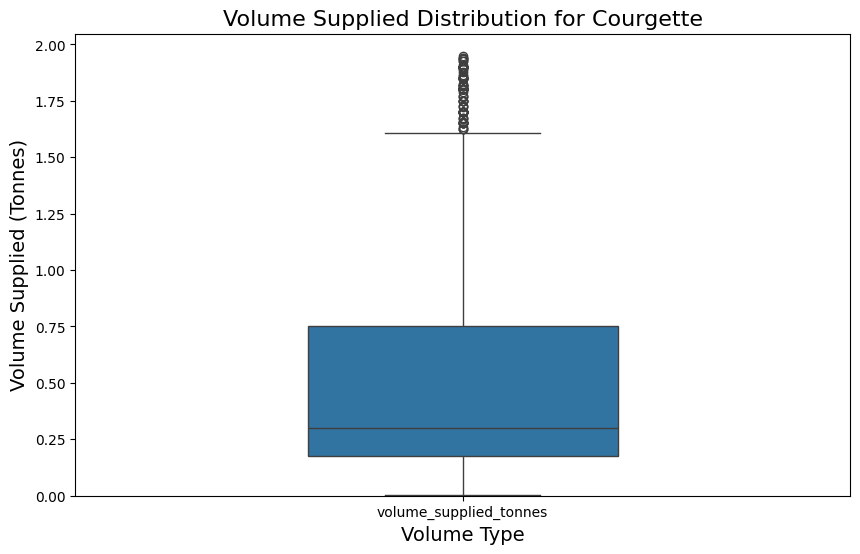

Total number of observations for Courgette: 3935
Total number of outliers for Courgette: 123 (3.1%)



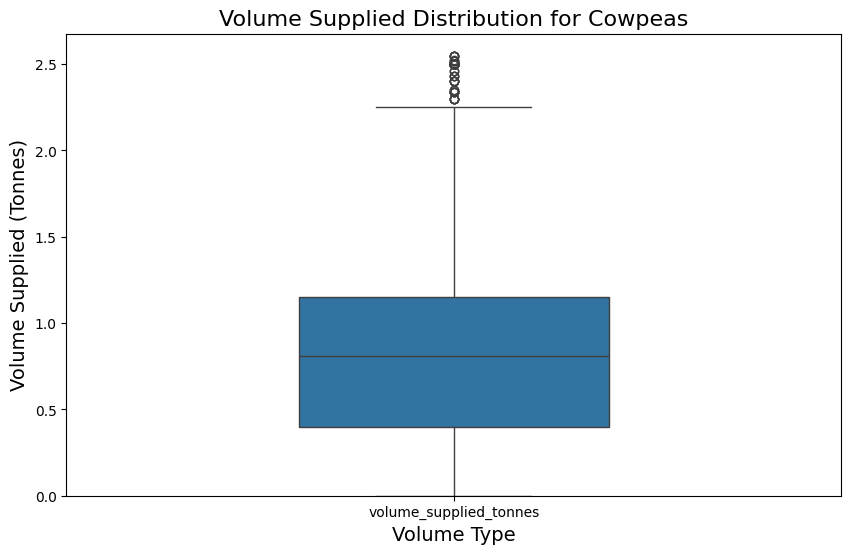

Total number of observations for Cowpeas: 6525
Total number of outliers for Cowpeas: 134 (2.1%)



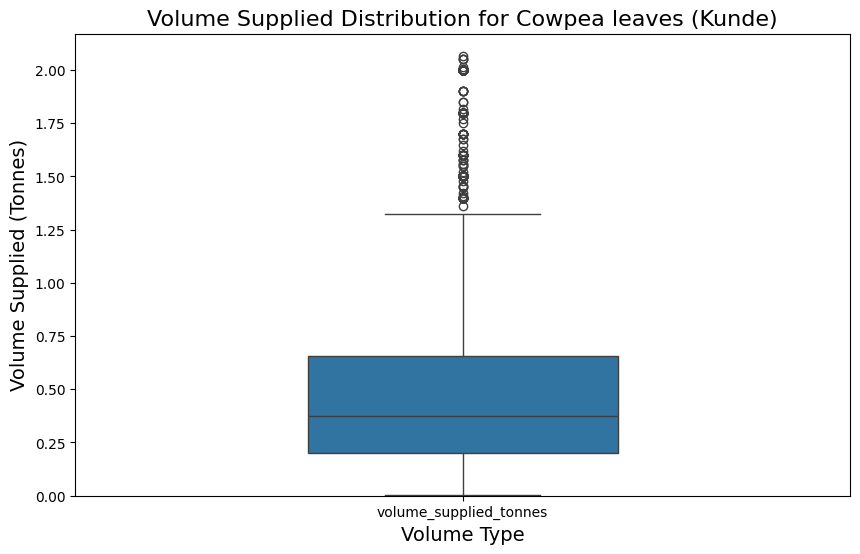

Total number of observations for Cowpea leaves (Kunde): 4999
Total number of outliers for Cowpea leaves (Kunde): 392 (7.8%)



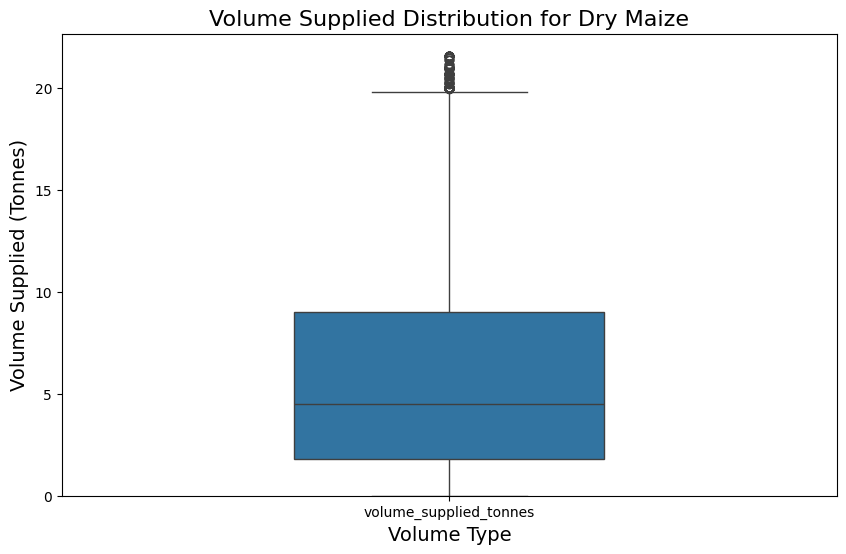

Total number of observations for Dry Maize: 13863
Total number of outliers for Dry Maize: 362 (2.6%)



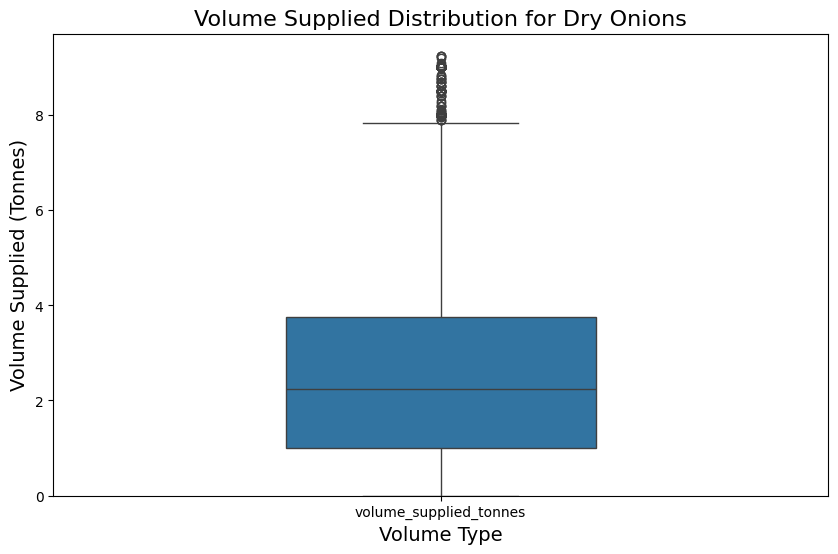

Total number of observations for Dry Onions: 13110
Total number of outliers for Dry Onions: 529 (4.0%)



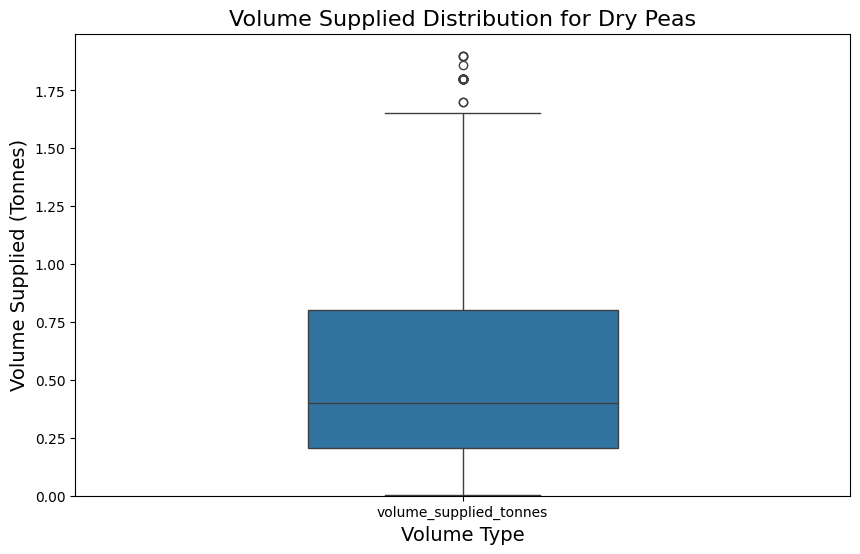

Total number of observations for Dry Peas: 1994
Total number of outliers for Dry Peas: 38 (1.9%)



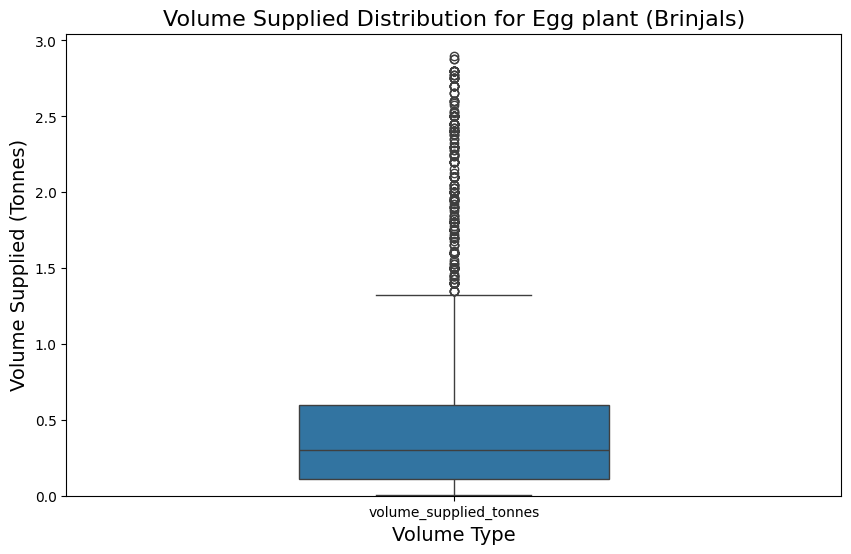

Total number of observations for Egg plant (Brinjals): 4361
Total number of outliers for Egg plant (Brinjals): 369 (8.5%)



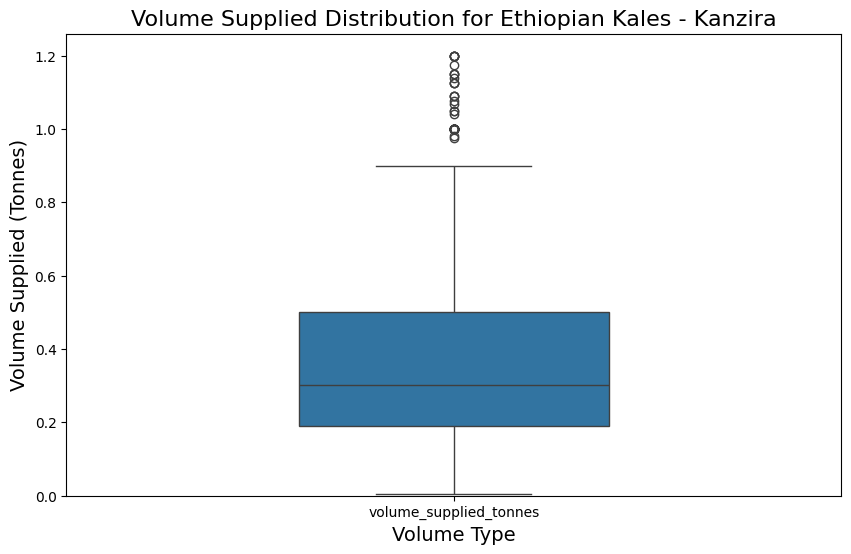

Total number of observations for Ethiopian Kales - Kanzira: 1100
Total number of outliers for Ethiopian Kales - Kanzira: 53 (4.8%)



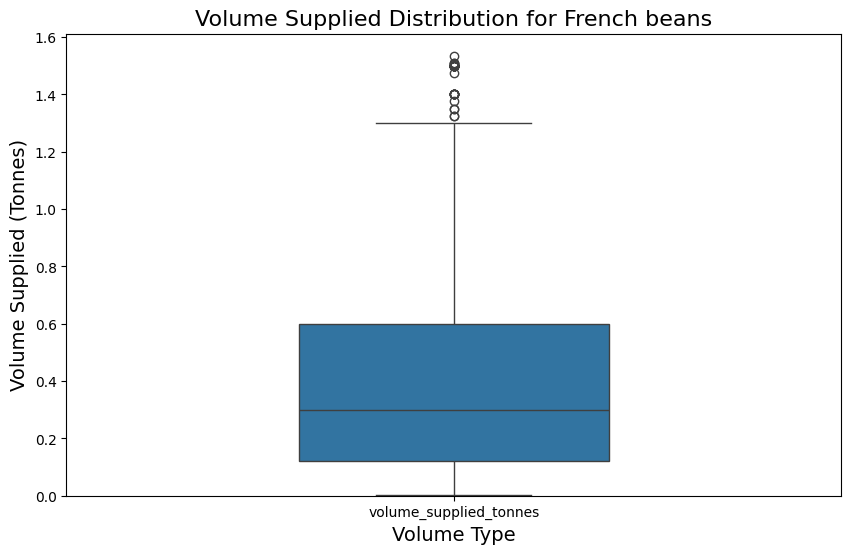

Total number of observations for French beans: 2018
Total number of outliers for French beans: 36 (1.8%)



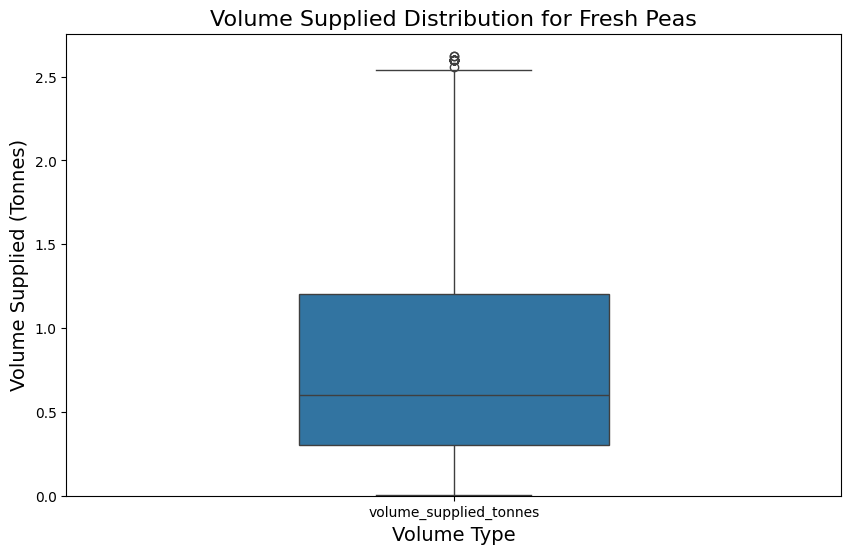

Total number of observations for Fresh Peas: 4589
Total number of outliers for Fresh Peas: 18 (0.4%)



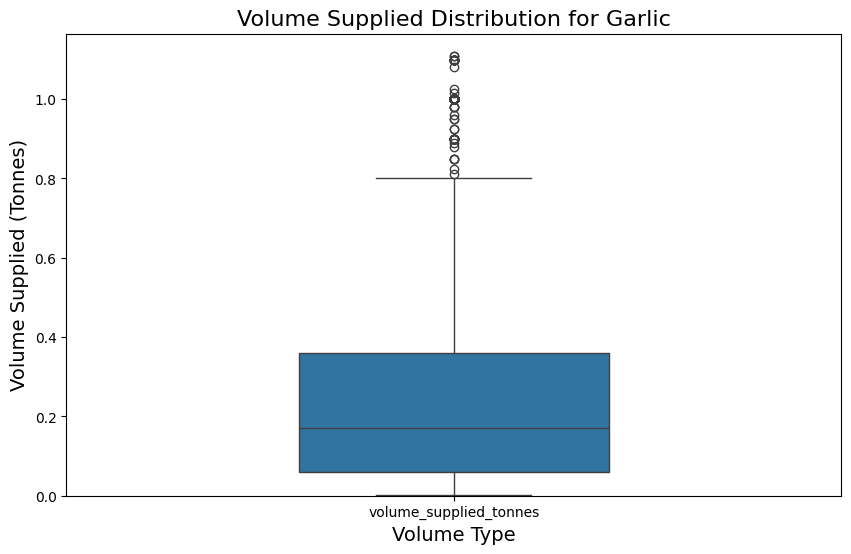

Total number of observations for Garlic: 5726
Total number of outliers for Garlic: 361 (6.3%)



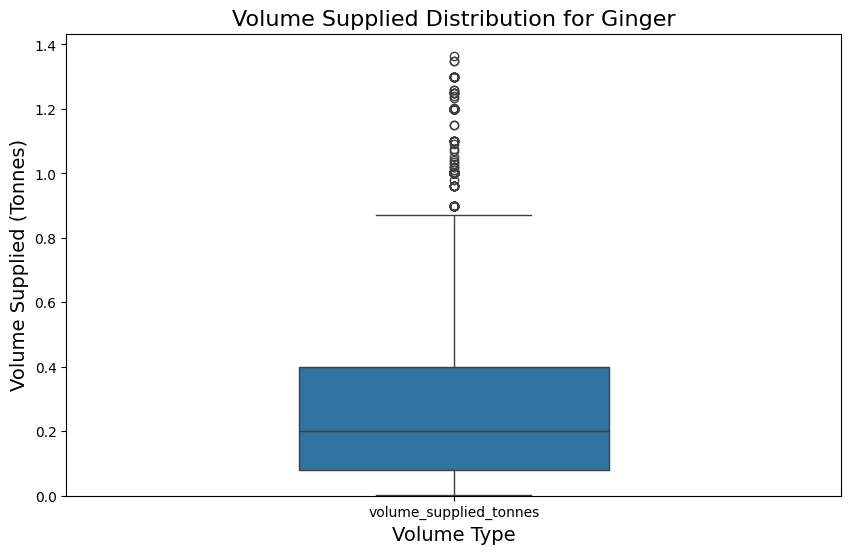

Total number of observations for Ginger: 5321
Total number of outliers for Ginger: 544 (10.2%)



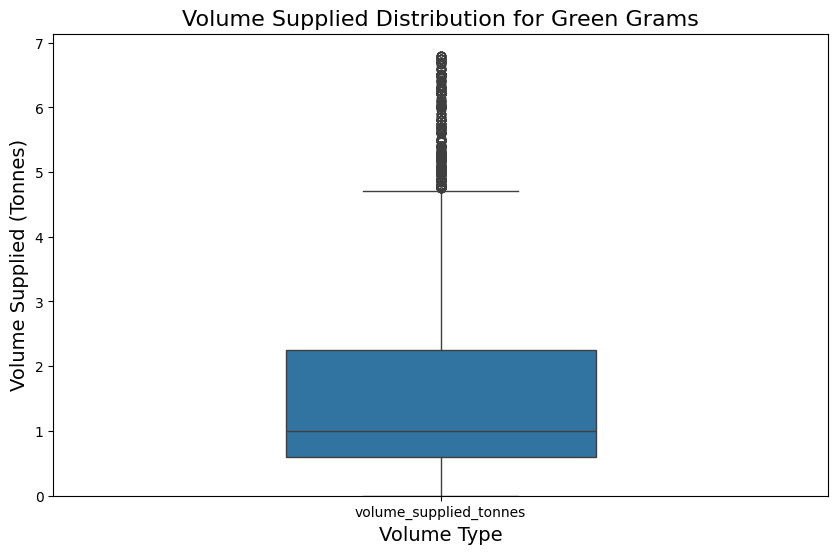

Total number of observations for Green Grams: 13028
Total number of outliers for Green Grams: 1191 (9.1%)



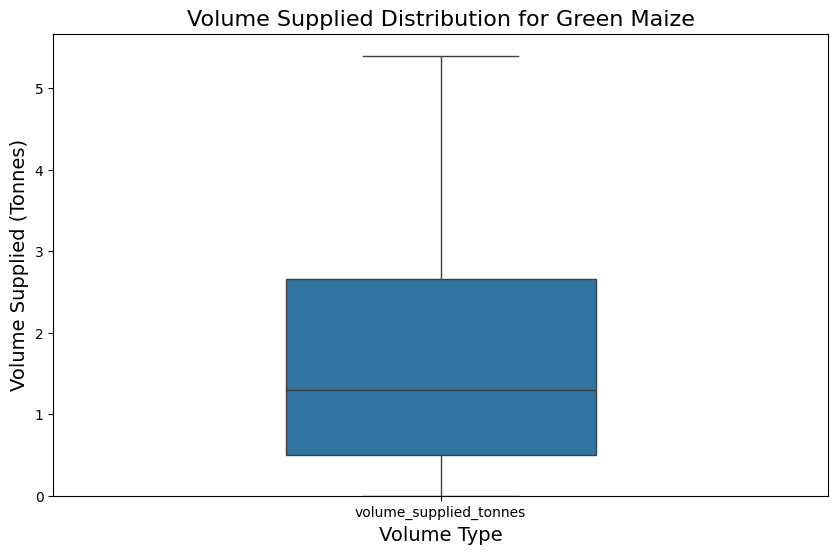

Total number of observations for Green Maize: 6367
Total number of outliers for Green Maize: 0 (0.0%)



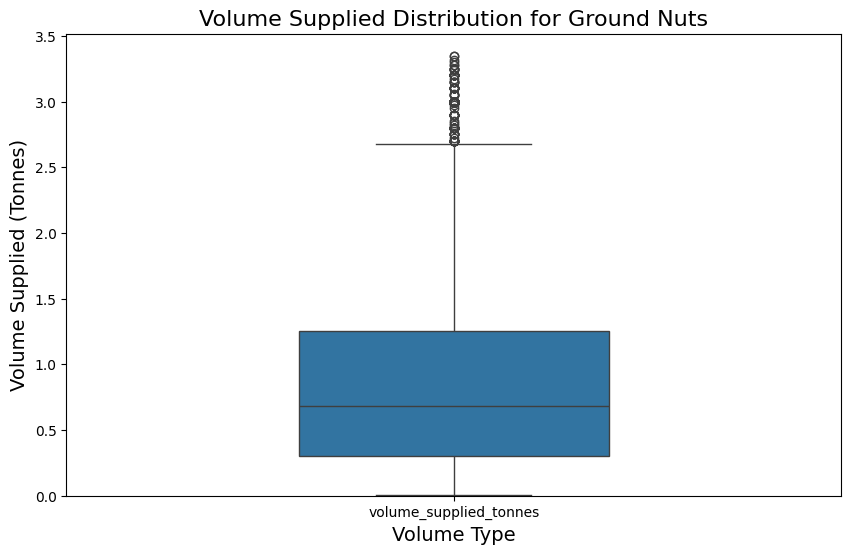

Total number of observations for Ground Nuts: 8470
Total number of outliers for Ground Nuts: 343 (4.0%)



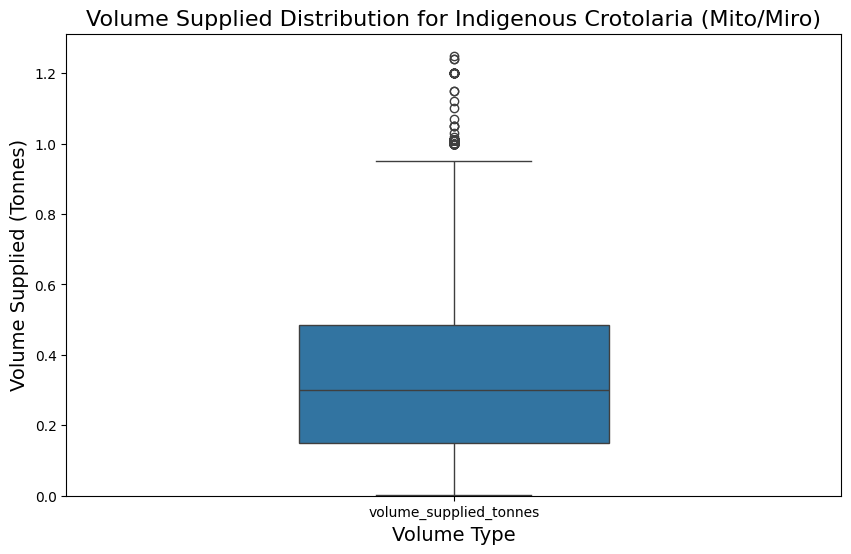

Total number of observations for Indigenous Crotolaria (Mito/Miro): 2141
Total number of outliers for Indigenous Crotolaria (Mito/Miro): 228 (10.6%)



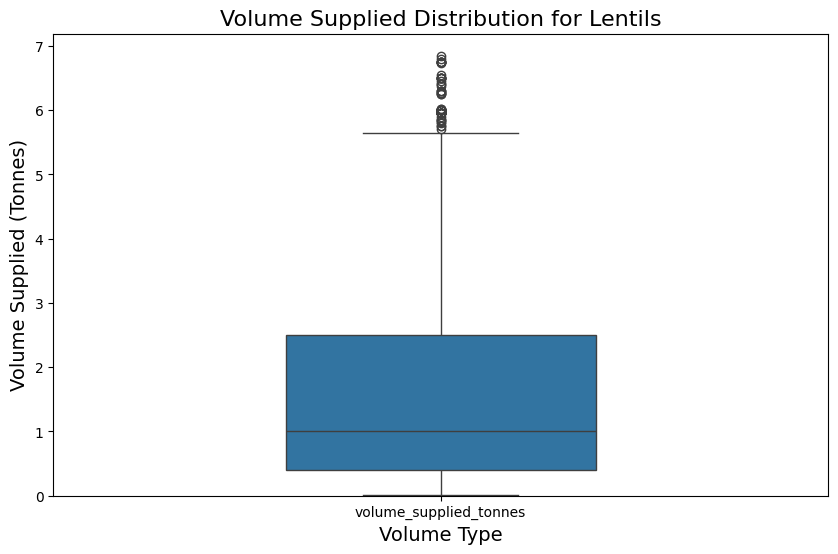

Total number of observations for Lentils: 4076
Total number of outliers for Lentils: 80 (2.0%)



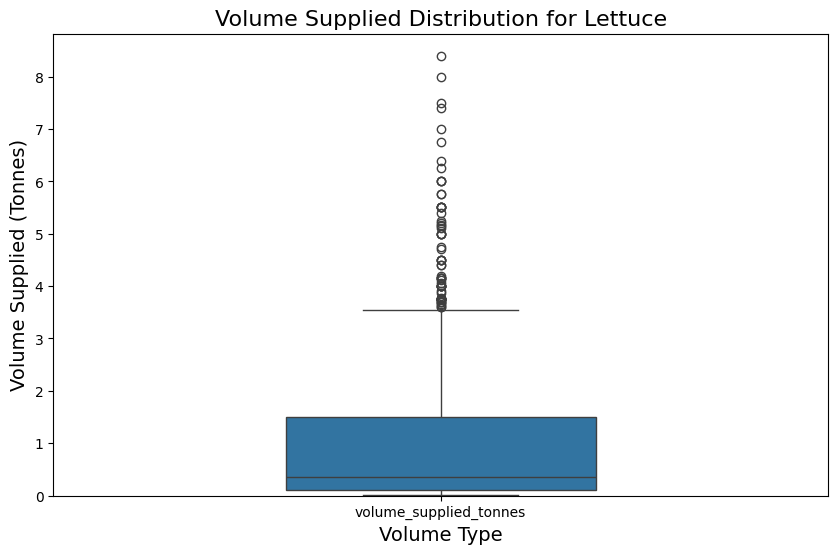

Total number of observations for Lettuce: 985
Total number of outliers for Lettuce: 68 (6.9%)



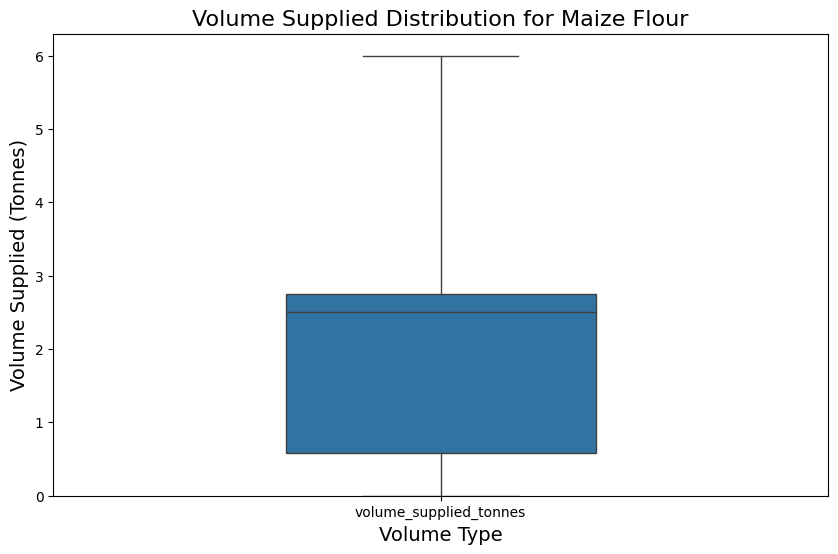

Total number of observations for Maize Flour: 8873
Total number of outliers for Maize Flour: 0 (0.0%)



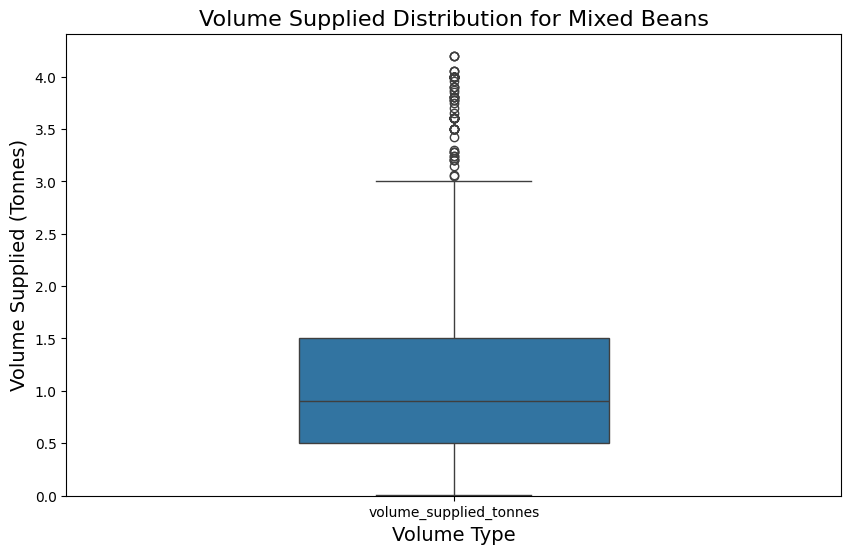

Total number of observations for Mixed Beans: 2832
Total number of outliers for Mixed Beans: 98 (3.5%)



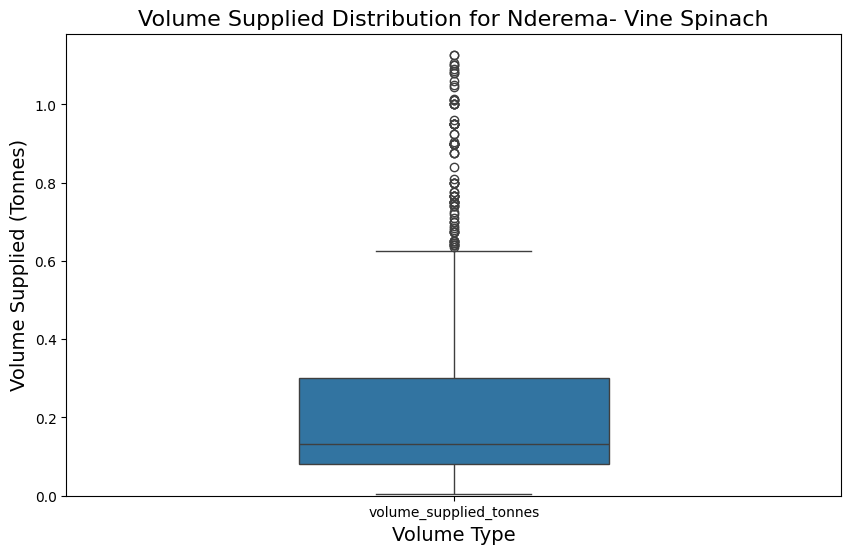

Total number of observations for Nderema- Vine Spinach: 879
Total number of outliers for Nderema- Vine Spinach: 93 (10.6%)



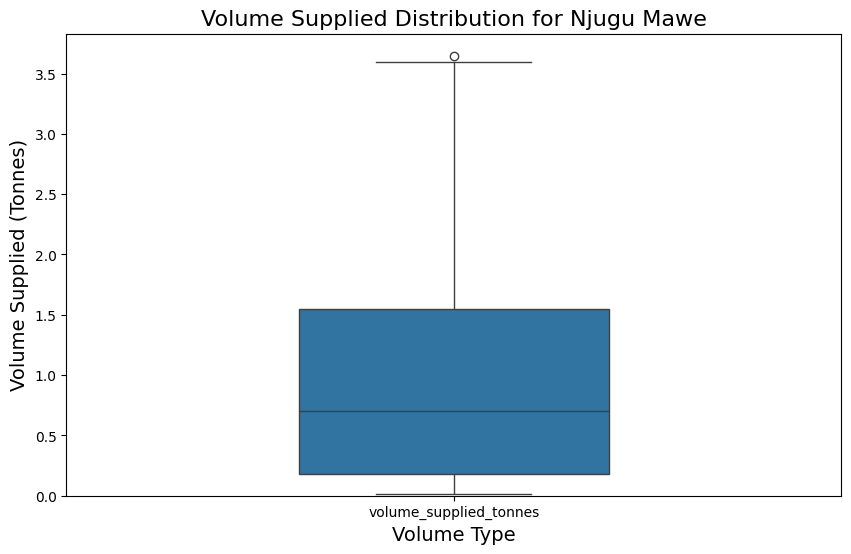

Total number of observations for Njugu Mawe: 567
Total number of outliers for Njugu Mawe: 1 (0.2%)



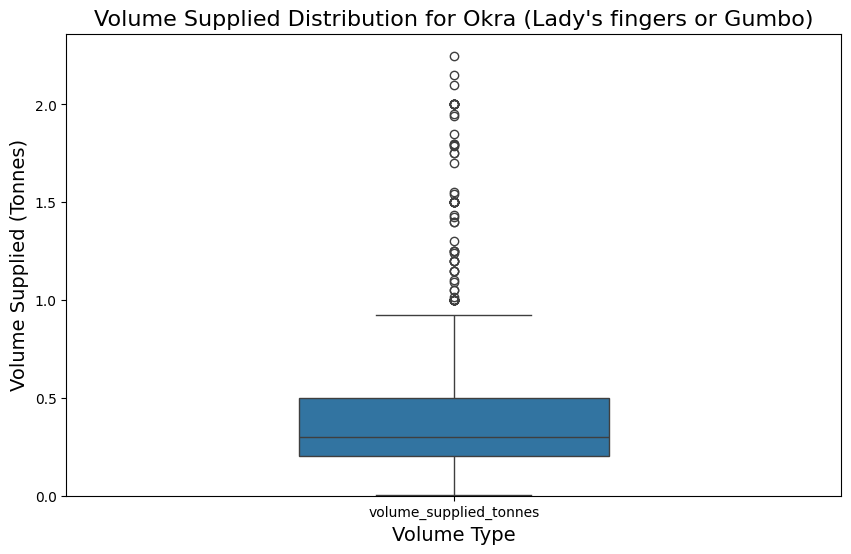

Total number of observations for Okra (Lady's fingers or Gumbo): 537
Total number of outliers for Okra (Lady's fingers or Gumbo): 72 (13.4%)



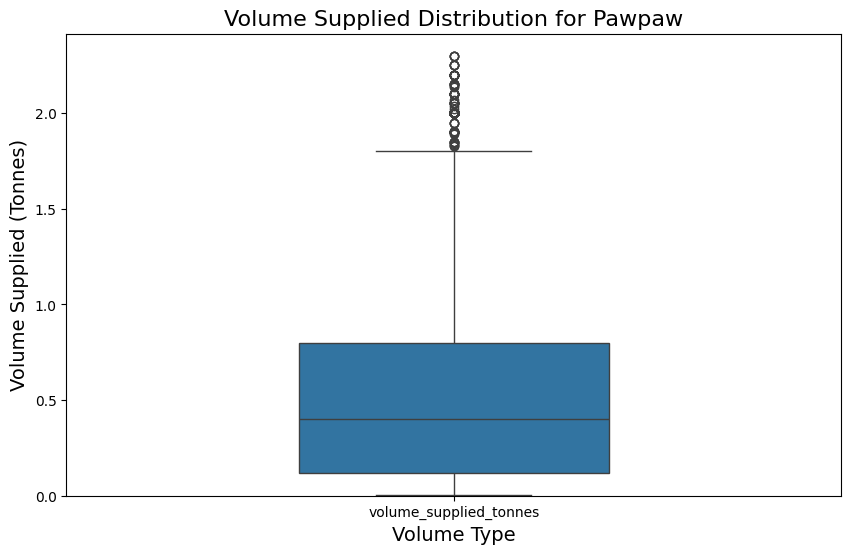

Total number of observations for Pawpaw: 4923
Total number of outliers for Pawpaw: 280 (5.7%)



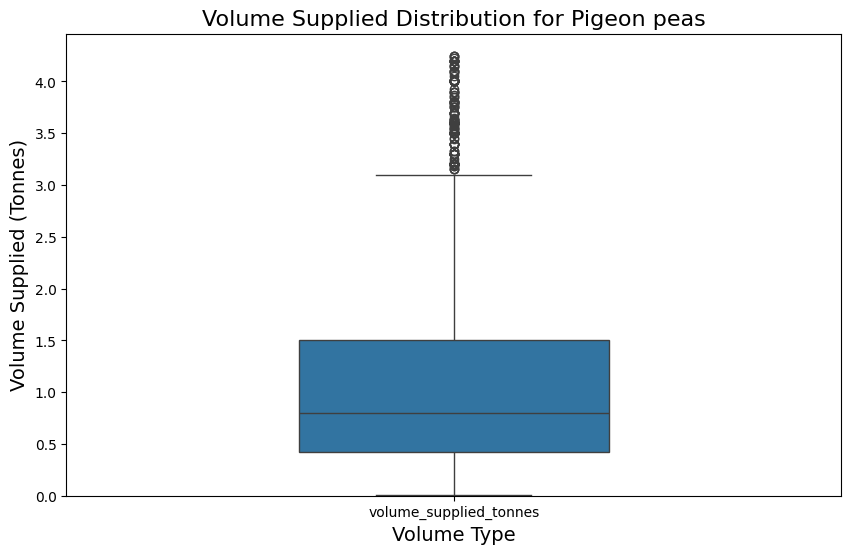

Total number of observations for Pigeon peas: 4007
Total number of outliers for Pigeon peas: 197 (4.9%)



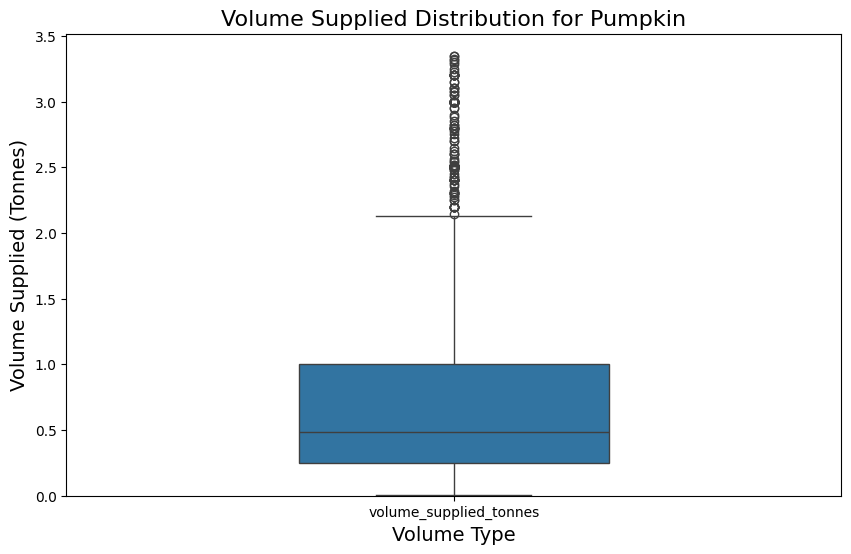

Total number of observations for Pumpkin: 3825
Total number of outliers for Pumpkin: 245 (6.4%)



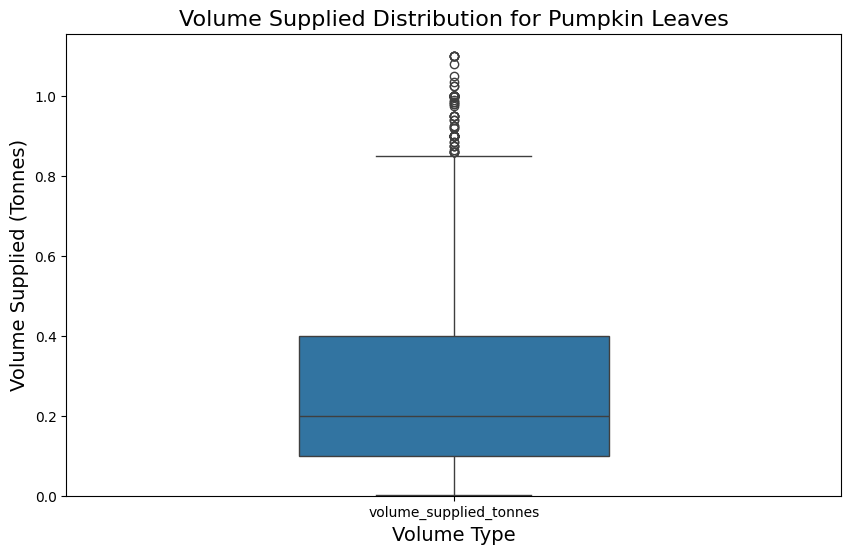

Total number of observations for Pumpkin Leaves: 3153
Total number of outliers for Pumpkin Leaves: 121 (3.8%)



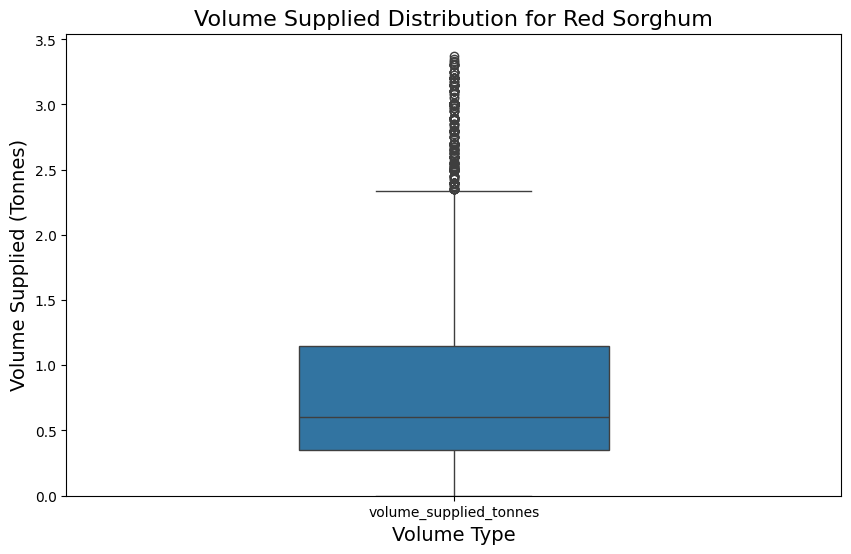

Total number of observations for Red Sorghum: 6974
Total number of outliers for Red Sorghum: 501 (7.2%)



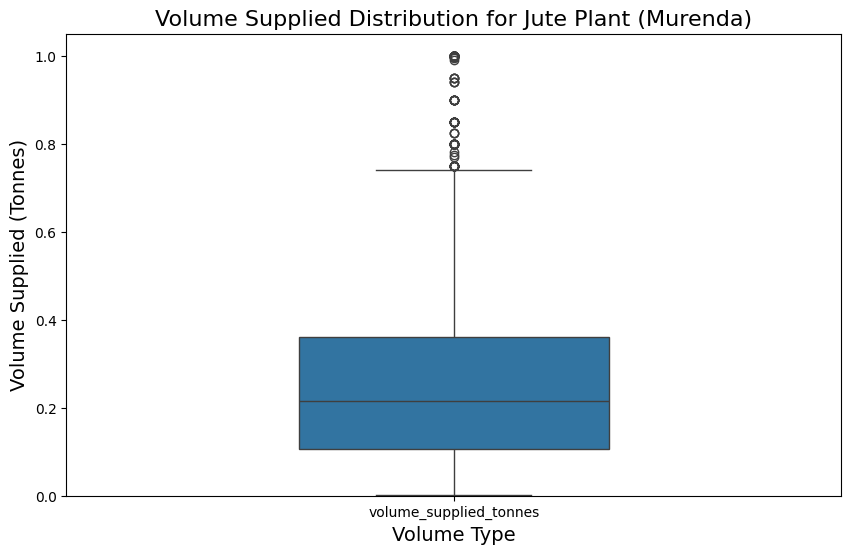

Total number of observations for Jute Plant (Murenda): 2629
Total number of outliers for Jute Plant (Murenda): 143 (5.4%)



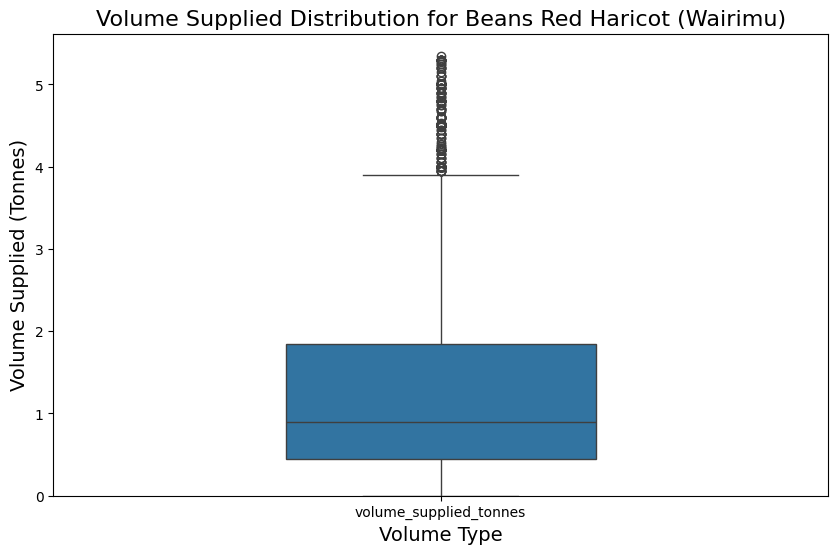

Total number of observations for Beans Red Haricot (Wairimu): 7104
Total number of outliers for Beans Red Haricot (Wairimu): 392 (5.5%)



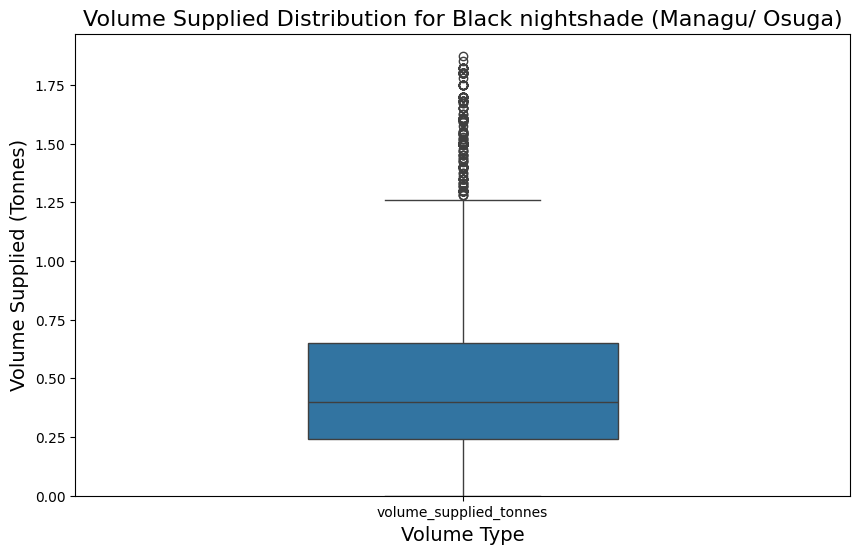

Total number of observations for Black nightshade (Managu/ Osuga): 7783
Total number of outliers for Black nightshade (Managu/ Osuga): 472 (6.1%)



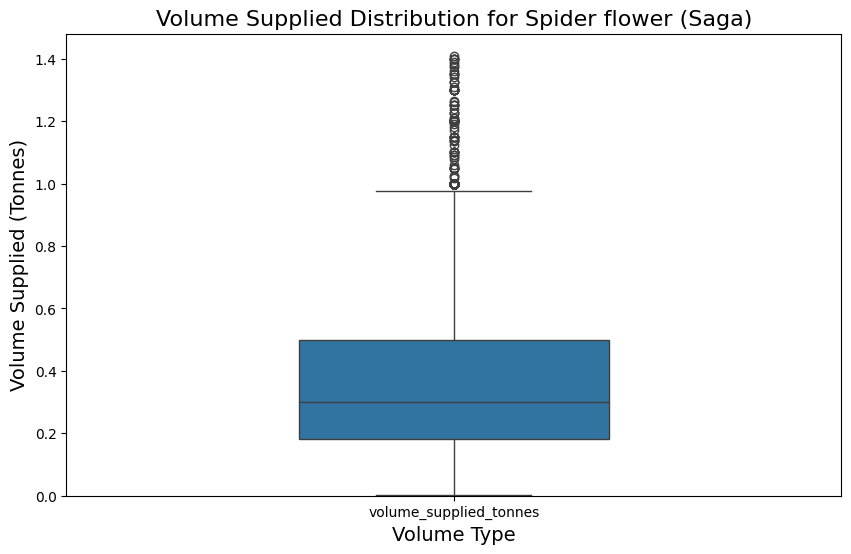

Total number of observations for Spider flower (Saga): 4318
Total number of outliers for Spider flower (Saga): 300 (6.9%)



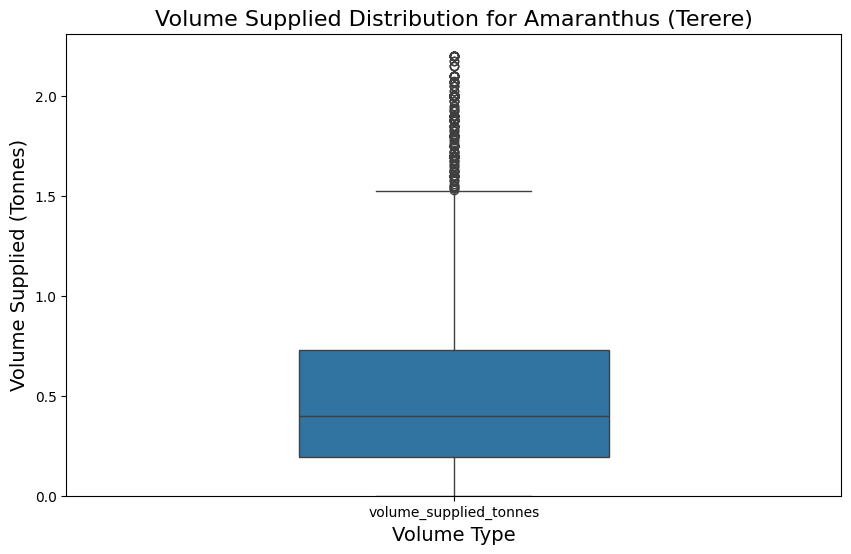

Total number of observations for Amaranthus (Terere): 6571
Total number of outliers for Amaranthus (Terere): 366 (5.6%)



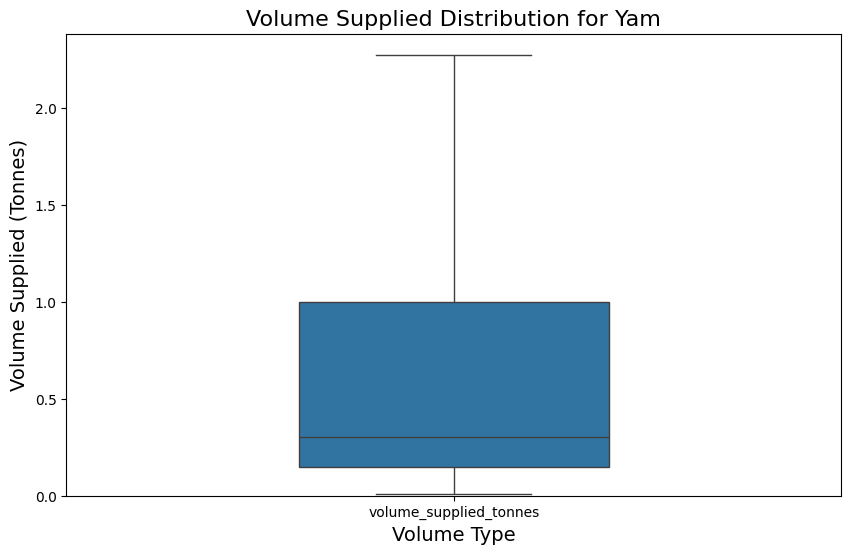

Total number of observations for Yam: 945
Total number of outliers for Yam: 0 (0.0%)



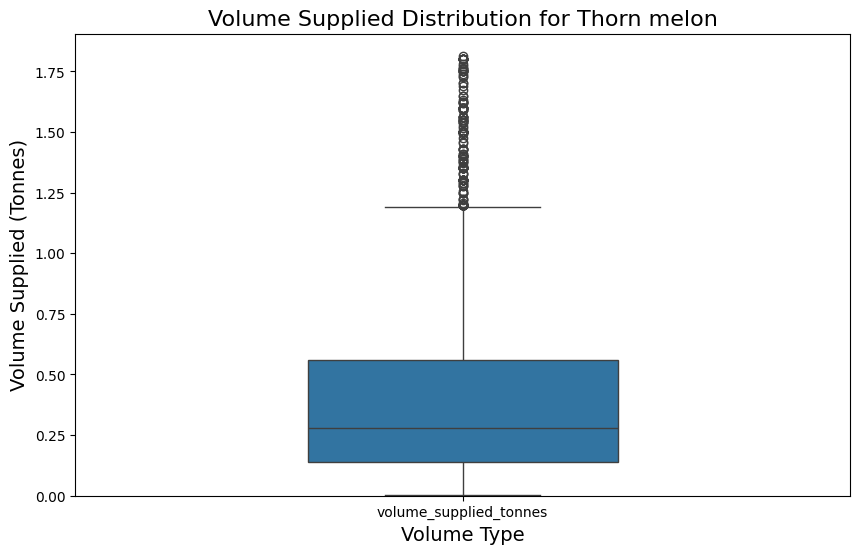

Total number of observations for Thorn melon: 2845
Total number of outliers for Thorn melon: 204 (7.2%)



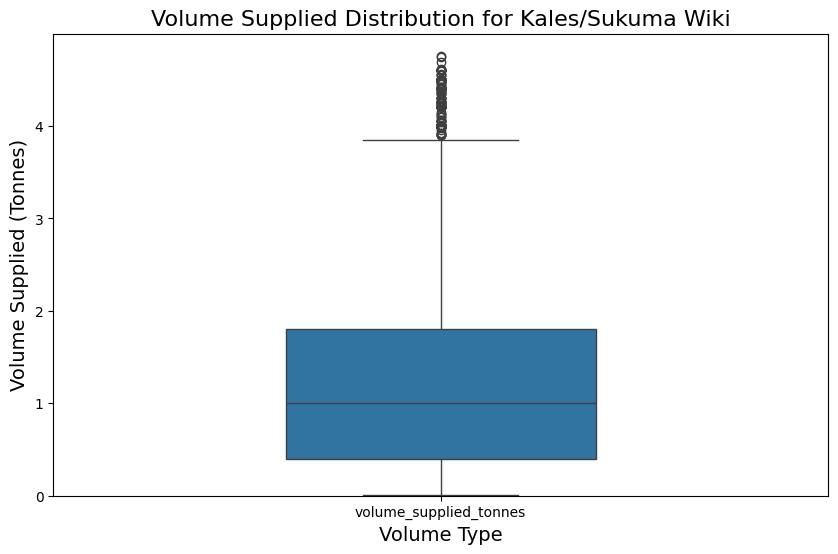

Total number of observations for Kales/Sukuma Wiki: 13045
Total number of outliers for Kales/Sukuma Wiki: 480 (3.7%)



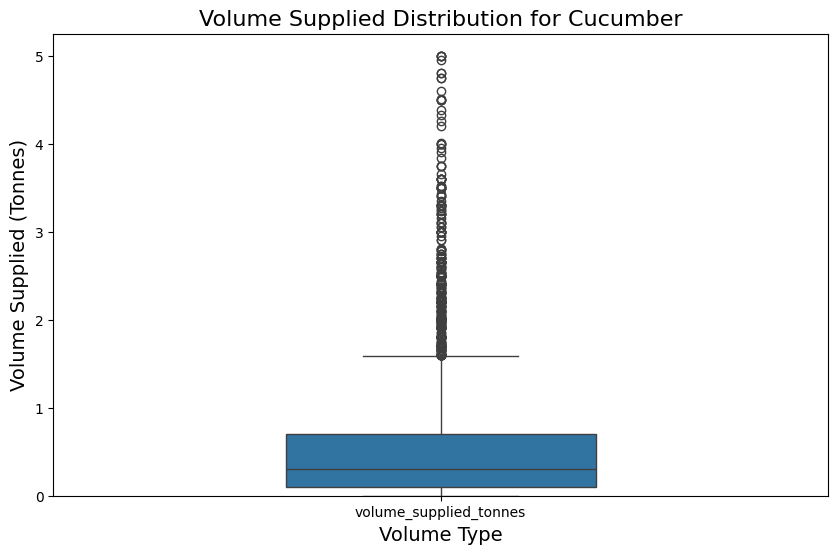

Total number of observations for Cucumber: 4124
Total number of outliers for Cucumber: 376 (9.1%)



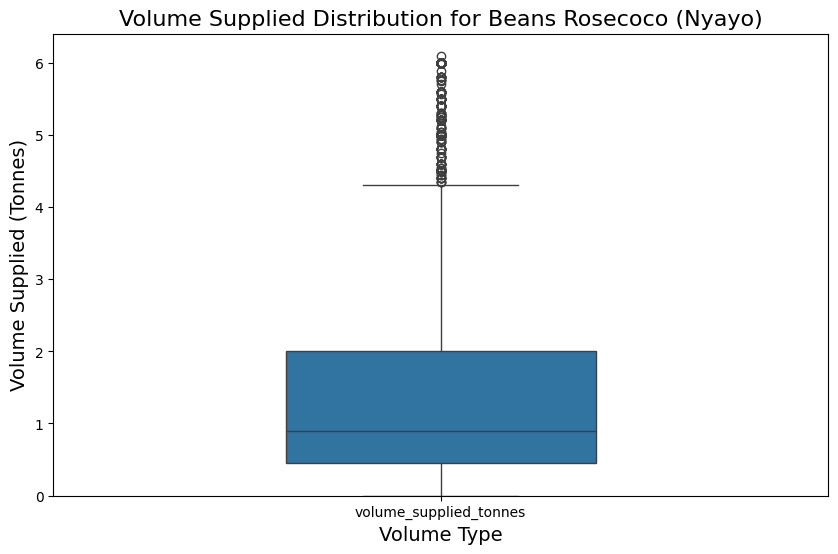

Total number of observations for Beans Rosecoco (Nyayo): 7510
Total number of outliers for Beans Rosecoco (Nyayo): 571 (7.6%)



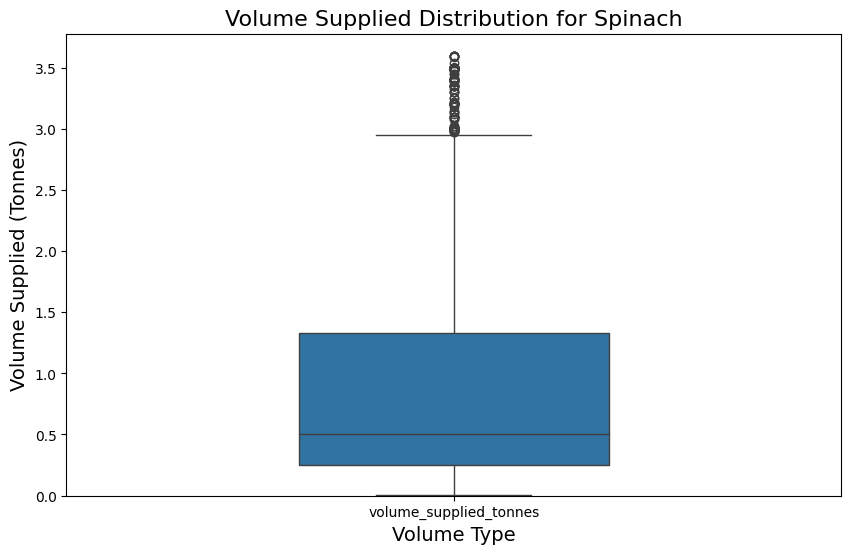

Total number of observations for Spinach: 9667
Total number of outliers for Spinach: 357 (3.7%)



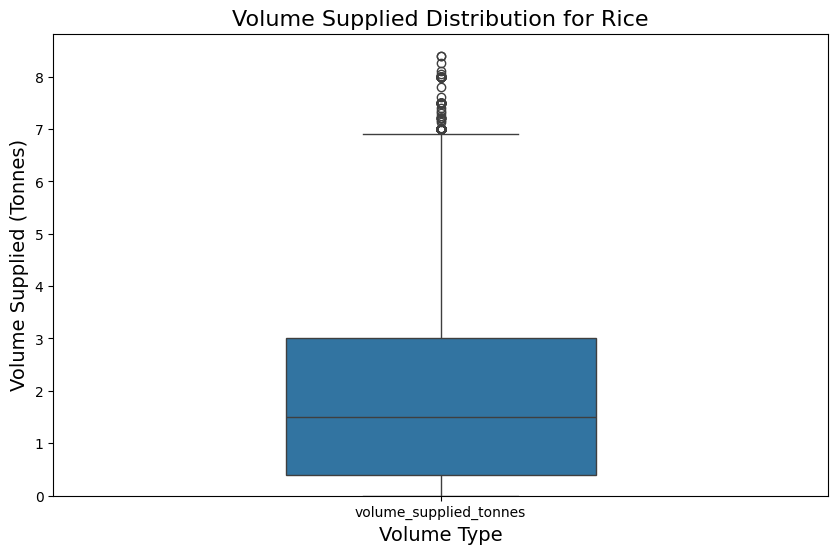

Total number of observations for Rice: 10323
Total number of outliers for Rice: 341 (3.3%)



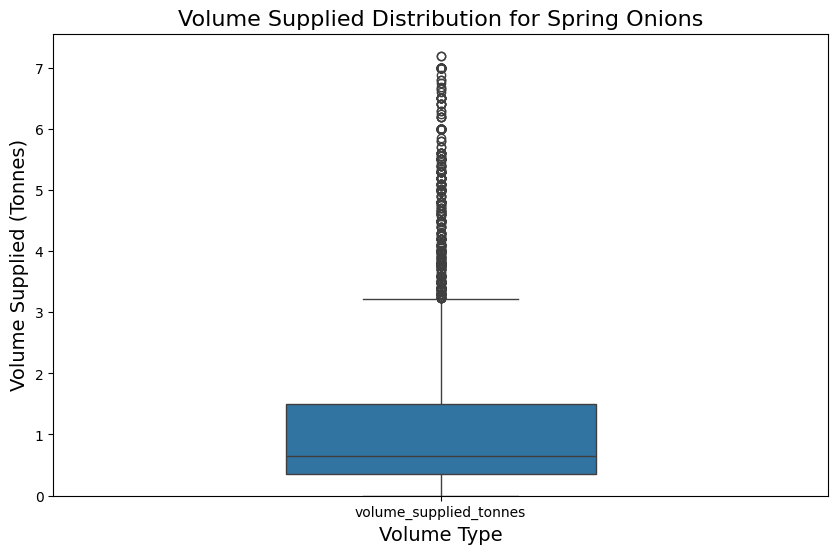

Total number of observations for Spring Onions: 7772
Total number of outliers for Spring Onions: 611 (7.9%)



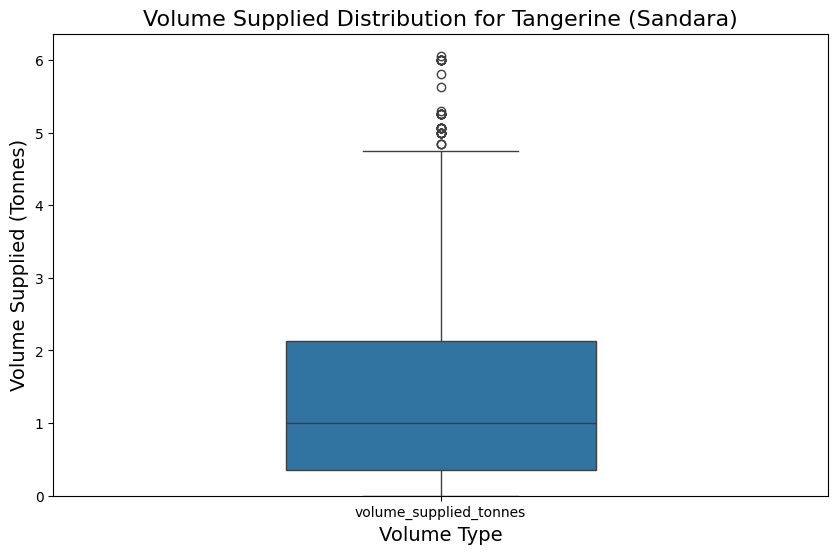

Total number of observations for Tangerine (Sandara): 1436
Total number of outliers for Tangerine (Sandara): 49 (3.4%)



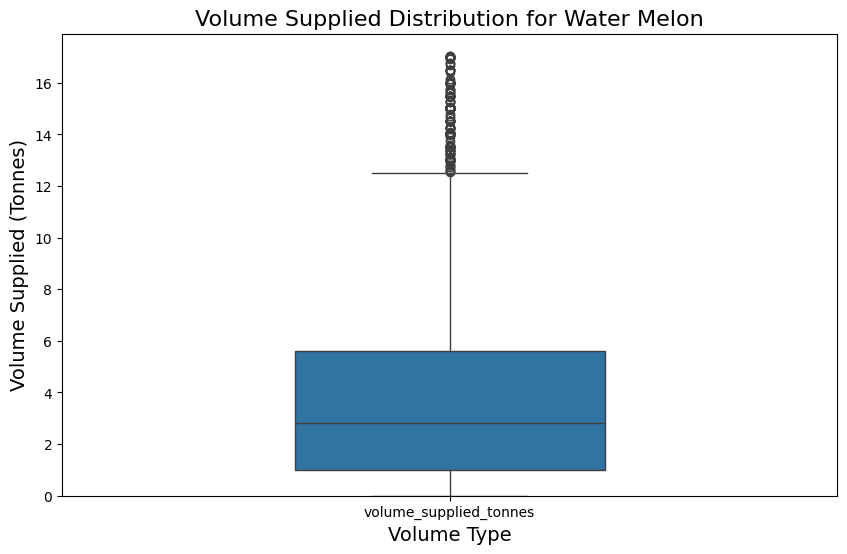

Total number of observations for Water Melon: 9005
Total number of outliers for Water Melon: 442 (4.9%)



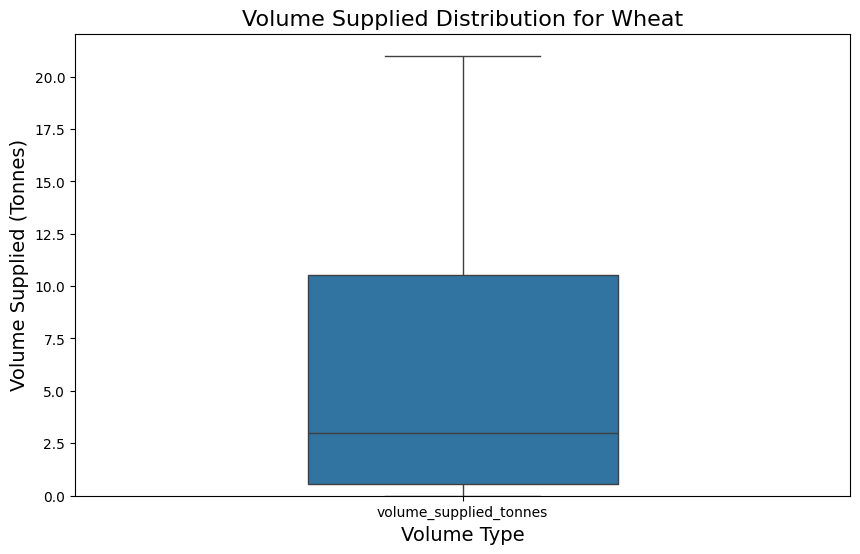

Total number of observations for Wheat: 2565
Total number of outliers for Wheat: 0 (0.0%)



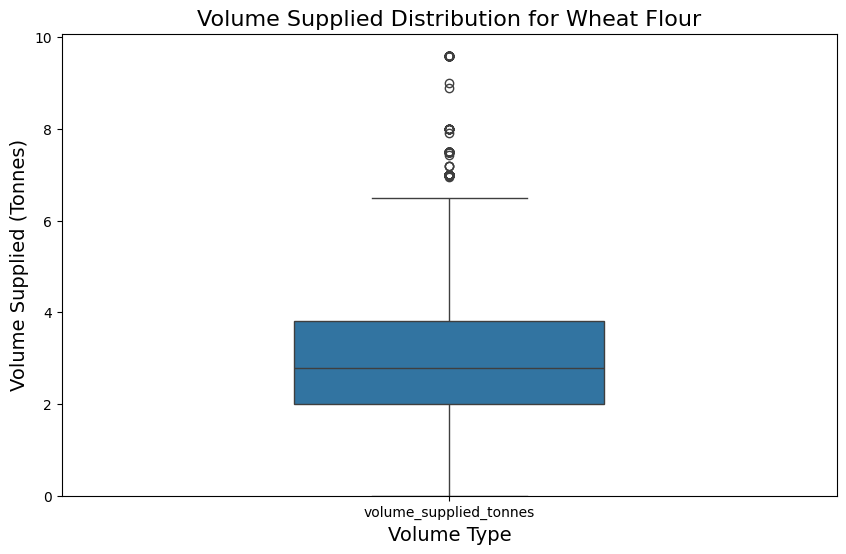

Total number of observations for Wheat Flour: 7614
Total number of outliers for Wheat Flour: 517 (6.8%)



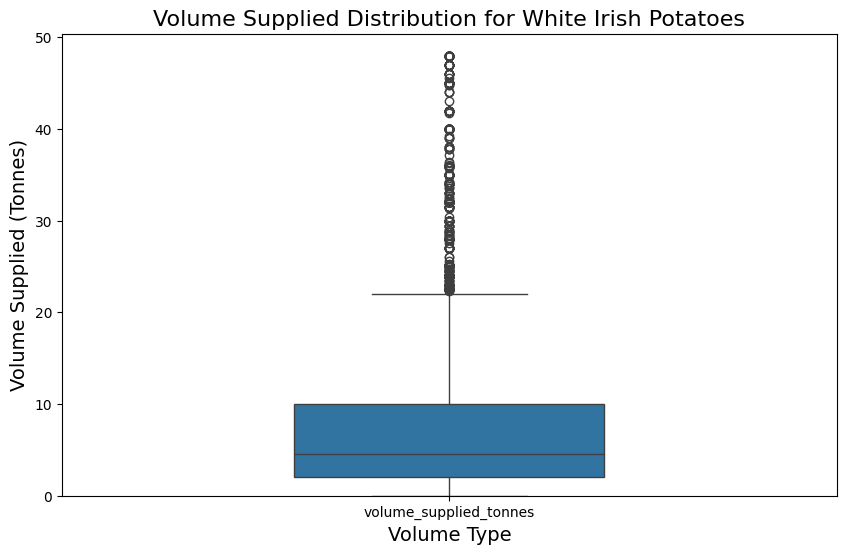

Total number of observations for White Irish Potatoes: 11146
Total number of outliers for White Irish Potatoes: 813 (7.3%)



In [15]:
# Define a function to find outliers based on IQR
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Prepare a long-format DataFrame for plotting
long_format_volume = data_filtered.melt(
    id_vars=['commodity'],
    value_vars=['volume_supplied_tonnes'],
    var_name='Volume Type',
    value_name='Volume Supplied'
)

# Loop through each commodity and create a box plot
for commodity in data_filtered['commodity'].unique():
    # Filter data for the specific commodity
    commodity_data = long_format_volume[long_format_volume['commodity'] == commodity]
    
    # Create a new figure for each commodity
    plt.figure(figsize=(10, 6))
    
    # Create the box plot for volume supplied
    sns.boxplot(data=commodity_data, x='Volume Type', y='Volume Supplied', width=0.4)
    
    # Set plot title and labels
    plt.title(f"Volume Supplied Distribution for {commodity}", fontsize=16)
    plt.xlabel("Volume Type", fontsize=14)
    plt.ylabel("Volume Supplied (Tonnes)", fontsize=14)
    
    # Adjust y-axis limit if necessary for clarity
    plt.ylim(bottom=0)
    
    # Display the plot
    plt.show()
    
    # Calculate total number of observations and outliers
    total_observations = commodity_data.shape[0]
    outliers = find_outliers(commodity_data, 'Volume Supplied')
    total_outliers = outliers.shape[0]
    
    # Calculate percentage of outliers
    percentage_outliers = (total_outliers / total_observations) * 100
    
    # Print the total number of observations and outliers with percentage
    print(f"Total number of observations for {commodity}: {total_observations}")
    print(f"Total number of outliers for {commodity}: {total_outliers} ({percentage_outliers:.1f}%)\n")

In [16]:
# Define a function to find outliers based on IQR
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Initialize lists to store results
commodity_list = []
outliers_count_list = []
outliers_percentage_list = []
q25_list = []
median_list = []
mean_list = []
q75_list = []

# Loop through each commodity and calculate statistics
for commodity in data_filtered['commodity'].unique():
    # Filter data for the specific commodity
    commodity_data = data_filtered[data_filtered['commodity'] == commodity]
    
    # Get the volume column
    volume_column = 'volume_supplied_tonnes'
    
    # Calculate number of total observations and outliers
    total_observations = commodity_data.shape[0]
    outliers = find_outliers(commodity_data, volume_column)
    total_outliers = outliers.shape[0]
    
    # Calculate the percentage of outliers
    percentage_outliers = (total_outliers / total_observations) * 100
    
    # Calculate the 25th percentile, median, mean, and 75th percentile
    q25 = commodity_data[volume_column].quantile(0.25)
    median = commodity_data[volume_column].median()
    mean = commodity_data[volume_column].mean()
    q75 = commodity_data[volume_column].quantile(0.75)
    
    # Append results to lists
    commodity_list.append(commodity)
    outliers_count_list.append(total_outliers)
    outliers_percentage_list.append(round(percentage_outliers, 1))  # rounding to one decimal place
    q25_list.append(q25)
    median_list.append(median)
    mean_list.append(mean)
    q75_list.append(q75)

# Create a DataFrame from the results
aggregated_df = pd.DataFrame({
    'commodity': commodity_list,
    'number_of_outliers': outliers_count_list,
    'percentage_of_outliers': outliers_percentage_list,
    '25%': q25_list,
    'median': median_list,
    'mean': mean_list,
    '75%': q75_list
})

# Sort the DataFrame by percentage of outliers in descending order
aggregated_df = aggregated_df.sort_values(by='percentage_of_outliers', ascending=False)

# Print the final DataFrame
aggregated_df

commodity  number_of_outliers  \
31     Okra (Lady's fingers or Gumbo)                  72   
29              Nderema- Vine Spinach                  93   
24  Indigenous Crotolaria (Mito/Miro)                 228   
1             Beans (Canadian wonder)                 210   
20                             Ginger                 544   
21                        Green Grams                1191   
45                           Cucumber                 376   
15               Egg plant (Brinjals)                 369   
49                      Spring Onions                 611   
4                          Butternuts                 423   
11              Cowpea leaves (Kunde)                 392   
46             Beans Rosecoco (Nyayo)                 571   
54               White Irish Potatoes                 813   
36                        Red Sorghum                 501   
43                        Thorn melon                 204   
3                            Broccoli                 157   
26                            Lettuce                  68   
5                 Cassava Chips (dry)                 220   
40               Spider flower (Saga)                 300   
53                        Wheat Flour                 517   
34                            Pumpkin                 245   
19                             Garlic                 361   
39   Black nightshade (Managu/ Osuga)                 472   
32                             Pawpaw                 280   
7                            Chillies                 339   
41                Amaranthus (Terere)                 366   
38        Beans Red Haricot (Wairimu)                 392   
37               Jute Plant (Murenda)                 143   
51                        Water Melon                 442   
33                        Pigeon peas                 197   
16          Ethiopian Kales - Kanzira                  53   
23                        Ground Nuts                 343   
13                         Dry Onions                 529   
35                     Pumpkin Leaves                 121   
44                  Kales/Sukuma Wiki                 480   
47                            Spinach                 357   
28                        Mixed Beans                  98   
2                  Beans (Mwezi Moja)                 149   
50                Tangerine (Sandara)                  49   
48                               Rice                 341   
0                          Arrow Root                 231   
9                           Courgette                 123   
12                          Dry Maize                 362   
8                  Coriander (Dhania)                 180   
10                            Cowpeas                 134   
25                            Lentils                  80   
14                           Dry Peas                  38   
17                       French beans                  36   
18                         Fresh Peas                  18   
30                         Njugu Mawe                   1   
42                                Yam                   0   
22                        Green Maize                   0   
52                              Wheat                   0   
6                         Cauliflower                   0   
27                        Maize Flour                   0   

    percentage_of_outliers       25%  median      mean       75%  
31                    13.4  0.200000  0.3000  0.464731   0.50000  
29                    10.6  0.080000  0.1330  0.239037   0.30000  
24                    10.6  0.150000  0.3000  0.364733   0.48500  
1                     10.3  0.450000  0.8250  1.208934   1.50000  
20                    10.2  0.080000  0.2000  0.306030   0.40000  
21                     9.1  0.600000  1.0000  1.727844   2.25000  
45                     9.1  0.100000  0.3000  0.554903   0.70000  
15                     8.5  0.110000  0.3000  0.492420   0.60000  
49      

Key Observations:

1. Large Variance in Supply:

Commodities like White Irish Potatoes, Dry Maize, and Wheat have significantly high average volumes supplied compared to others, with means of 7.6, 5.8, and 5.1 tonnes, respectively. This is expected for staple crops with broad demand.
On the other hand, many commodities (such as Cauliflower, Chillies, Broccoli, and Ethiopian Kales) show relatively low average supply volumes, often below 0.3 tonnes.

2. High Standard Deviations:

The standard deviations for some commodities (e.g., White Irish Potatoes, Dry Maize, Rice, Watermelon, Wheat, etc.) are quite high, indicating a wide variability in the supply. For example, White Irish Potatoes has a mean of 7.6 tonnes, but a standard deviation of 8.7 tonnes, meaning the supply could vary significantly across different records.
This suggests that while some markets or periods might see very large volumes of supply, others might have much smaller volumes.

3. Significant Max Values:

Commodities like White Irish Potatoes (48 tonnes max), Wheat (21 tonnes max), Dry Maize (21.6 tonnes max), and Watermelon (17 tonnes max) have much higher maximum values, suggesting that some markets or periods experience very large supply quantities.
Conversely, many commodities (e.g., Thorn Melon, Spinach, Pumpkin Leaves) show much smaller maximum values, typically below 1-3 tonnes.


Areas of Potential Concern:

1. Commodities with Very Low Volumes:

Some commodities show extremely low volumes across the board, such as Cauliflower (mean 0.17 tonnes), Chillies (mean 0.25 tonnes), and Broccoli (mean 0.26 tonnes). These could indicate niche crops, small markets, or underreporting.

2. Extreme Outliers:

Some commodities exhibit extreme outliers. For example:
White Irish Potatoes: A maximum of 48 tonnes supplied in a single entry, which is much larger than its interquartile range (IQR).
Watermelon: A maximum of 17 tonnes.
These extreme values could be legitimate or potential data entry errors.



### Categorical Columns Inpection

In [17]:
# Analyze the 'classification' column
classification_counts = data_filtered['classification'].value_counts()

# Print summary of the 'classification' column
print(f"Analysis of 'classification':")
print(f"Unique values: {len(classification_counts)}")
print(f"Top categories:\n{classification_counts.head(10)}")


Analysis of 'classification':
Unique values: 78
Top categories:
classification
-                     228509
White Maize             9341
Hybrid/ polished        5926
Large Brown             5910
Pishori                 5528
On pods                 4143
Local-Special           3683
Sindano                 3562
Mixed-Traditional       3483
Makueni                 3419
Name: count, dtype: int64


A majority of the observations do not have an entry in the classification column, so I will replace them with 'Regular', and trim leading and trailing spaces.

In [18]:
# Replace '-' with 'Regular' and trim leading/trailing spaces
data_filtered['classification'] = data_filtered['classification'].replace('-', 'Regular').str.strip()

# Verify the changes
classification_counts_cleaned = data_filtered['classification'].value_counts()

# Print summary after cleaning
print(f"Analysis of 'classification' after cleaning:")
print(f"Unique values: {len(classification_counts_cleaned)}")
print(f"Top categories:\n{classification_counts_cleaned.head(10)}")

Analysis of 'classification' after cleaning:
Unique values: 78
Top categories:
classification
Regular              228509
White Maize            9341
Hybrid/ polished       5926
Large Brown            5910
Pishori                5528
On pods                4143
Local-Special          3683
Sindano                3562
Mixed-Traditional      3483
Makueni                3419
Name: count, dtype: int64


In [19]:
# Get the value counts for the 'county' column
county_counts = data_filtered['county'].value_counts()

# Print the value counts for all counties
print("County Value Counts:")
county_counts

County Value Counts:


county
Nairobi            30120
Kirinyaga          23449
Nakuru             21712
Siaya              18121
Trans-Nzoia        17260
Kilifi             13081
Embu               12823
Vihiga             12174
Machakos           11541
Kwale              11157
Tharaka-Nithi       9410
Nyandarua           9204
Nyeri               8530
Kisumu              7882
Migori              6737
Nandi               6294
Uasin-Gishu         6153
Kajiado             6100
Baringo             6089
Meru                5590
Kisii               4080
Taita-Taveta        4070
Mombasa             3965
Muranga             3692
Lamu                3487
Bungoma             3126
West-Pokot          3087
Homa-bay            2962
Kakamega            2659
Kitui               2592
Nyamira             2550
Mandera             2496
Busia               1947
Garissa             1841
Bomet               1558
Kericho             1268
Laikipia            1251
Makueni             1197
Elgeyo-Marakwet      824
Turkana           

1. I will drop all observations from 'test' county since they cannot be interpreted adequately.
2. For a meaningful time-series analysis, I will drop all counties with less than 300 observations.

In [20]:
# Step 1: Remove rows where 'county' is 'test'
data_filtered = data_filtered[data_filtered['county'] != 'test']

# Step 2: Calculate value counts for each county
county_counts = data_filtered['county'].value_counts()

# Step 3: Filter out counties with less than 300 observations
counties_to_keep = county_counts[county_counts >= 300].index

# Step 4: Keep only the rows corresponding to these counties
data_filtered = data_filtered[data_filtered['county'].isin(counties_to_keep)]

# Check to confirm the filtering process
data_filtered['county'].value_counts()

county
Nairobi            30120
Kirinyaga          23449
Nakuru             21712
Siaya              18121
Trans-Nzoia        17260
Kilifi             13081
Embu               12823
Vihiga             12174
Machakos           11541
Kwale              11157
Tharaka-Nithi       9410
Nyandarua           9204
Nyeri               8530
Kisumu              7882
Migori              6737
Nandi               6294
Uasin-Gishu         6153
Kajiado             6100
Baringo             6089
Meru                5590
Kisii               4080
Taita-Taveta        4070
Mombasa             3965
Muranga             3692
Lamu                3487
Bungoma             3126
West-Pokot          3087
Homa-bay            2962
Kakamega            2659
Kitui               2592
Nyamira             2550
Mandera             2496
Busia               1947
Garissa             1841
Bomet               1558
Kericho             1268
Laikipia            1251
Makueni             1197
Elgeyo-Marakwet      824
Turkana           

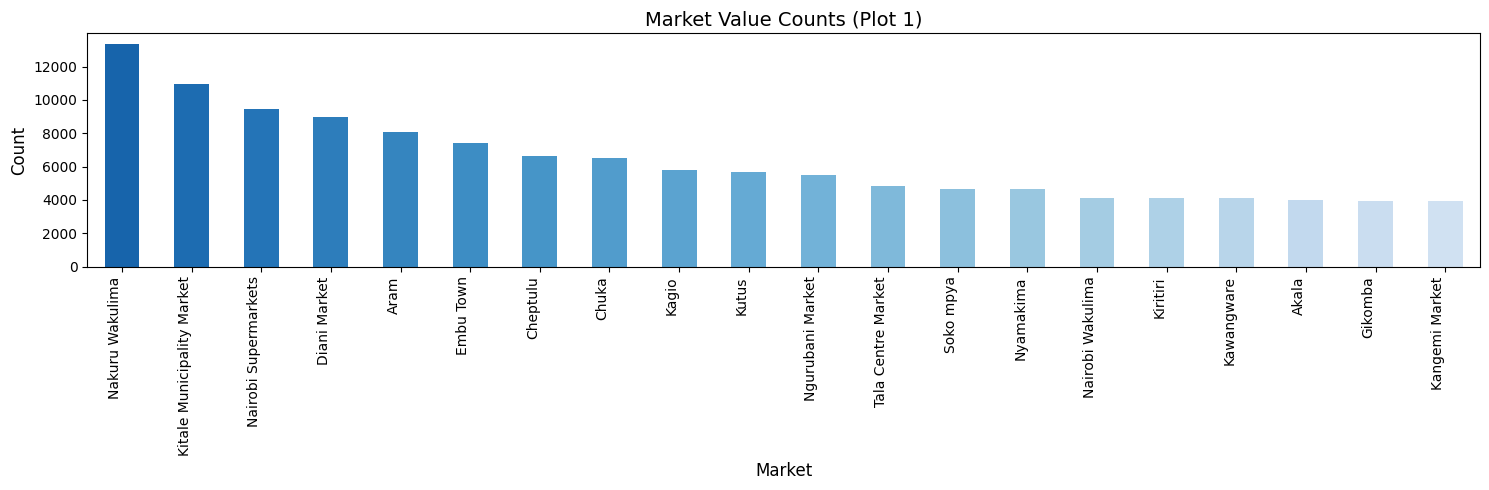

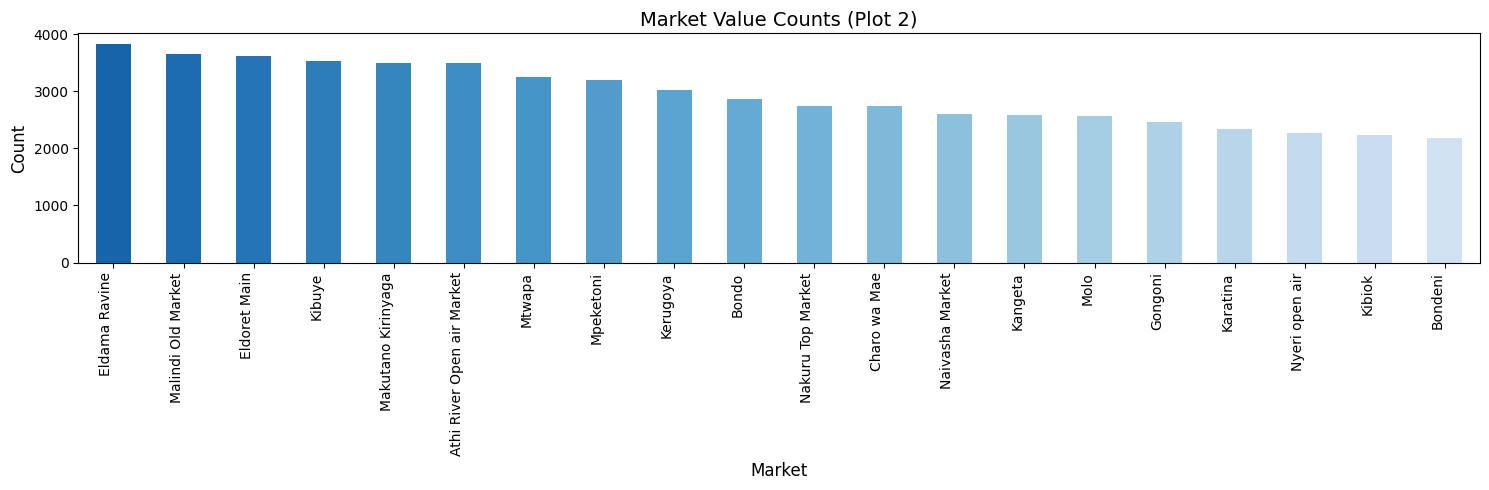

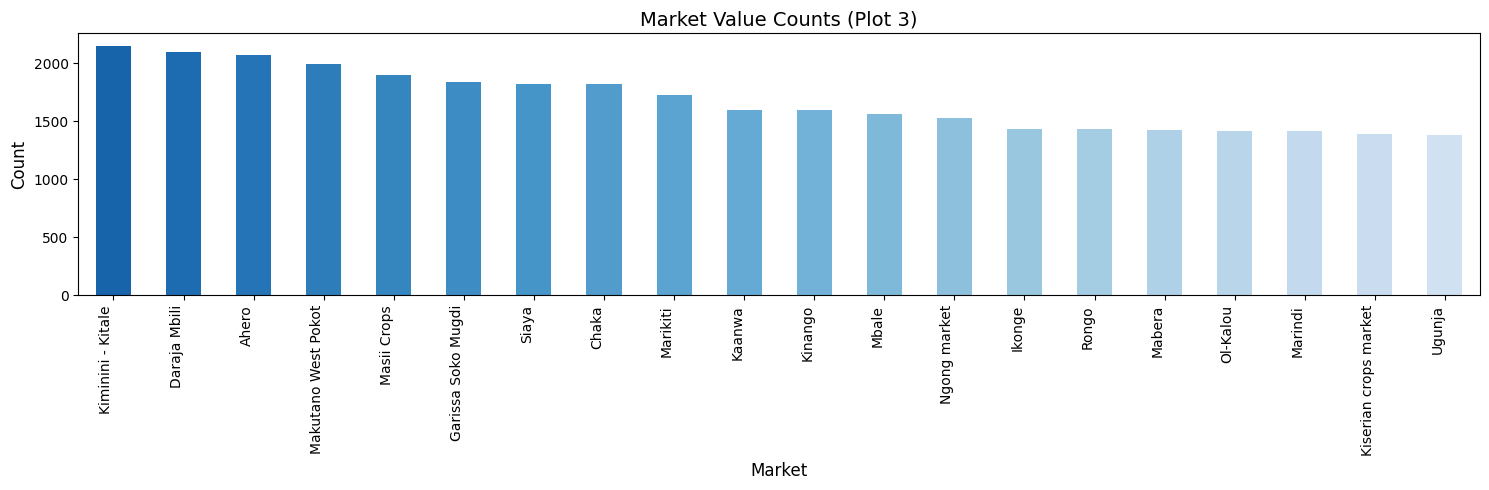

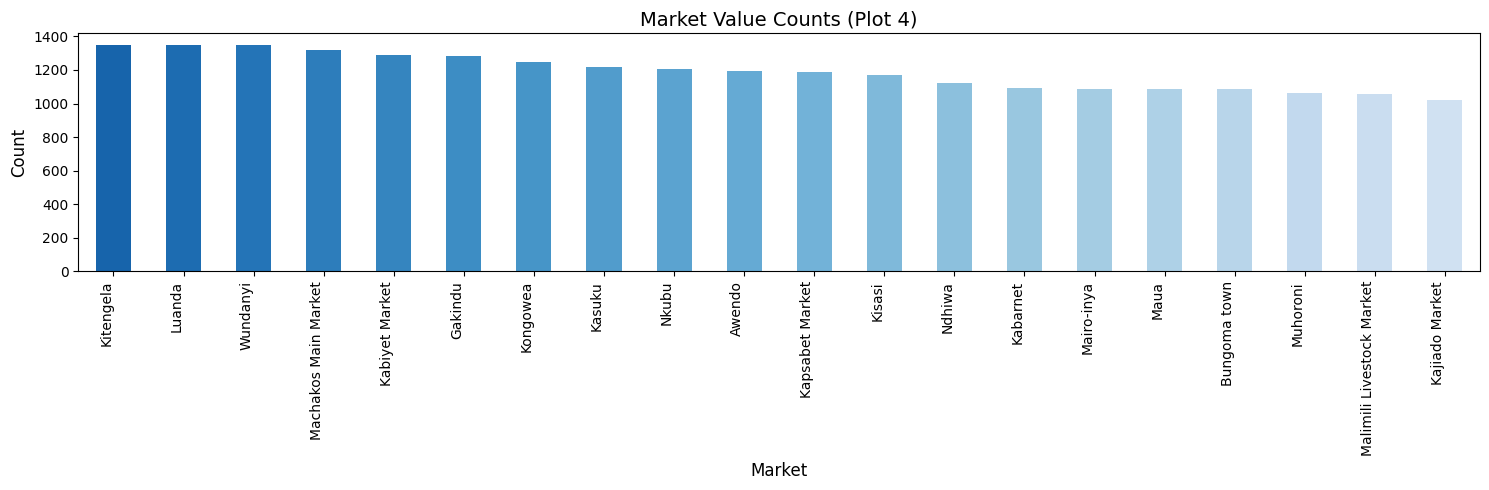

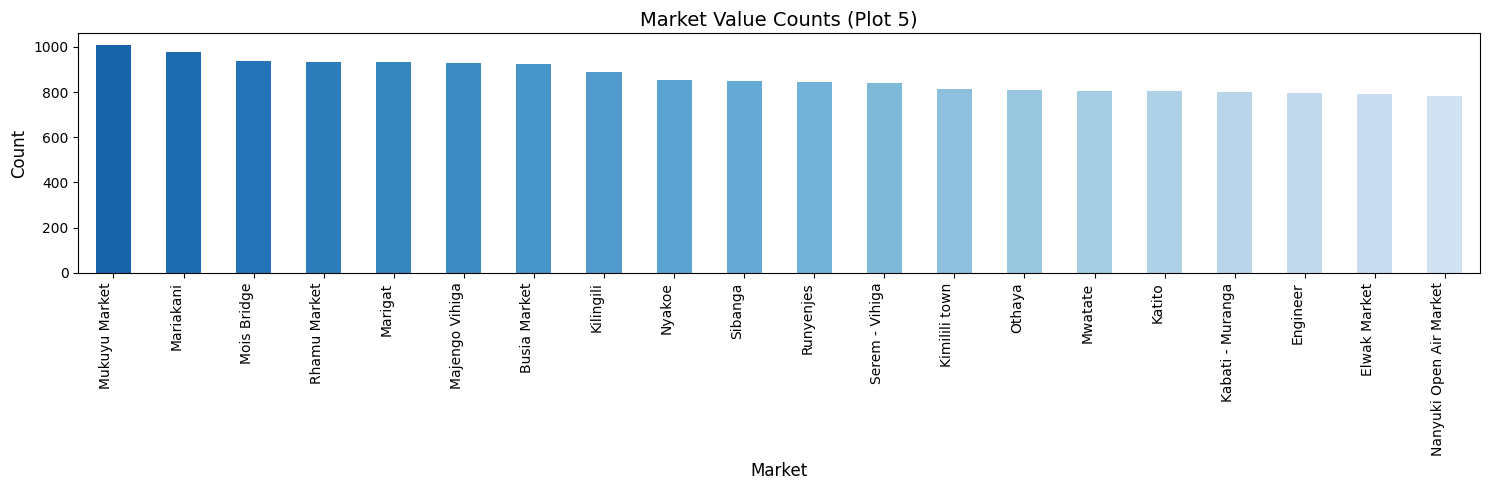

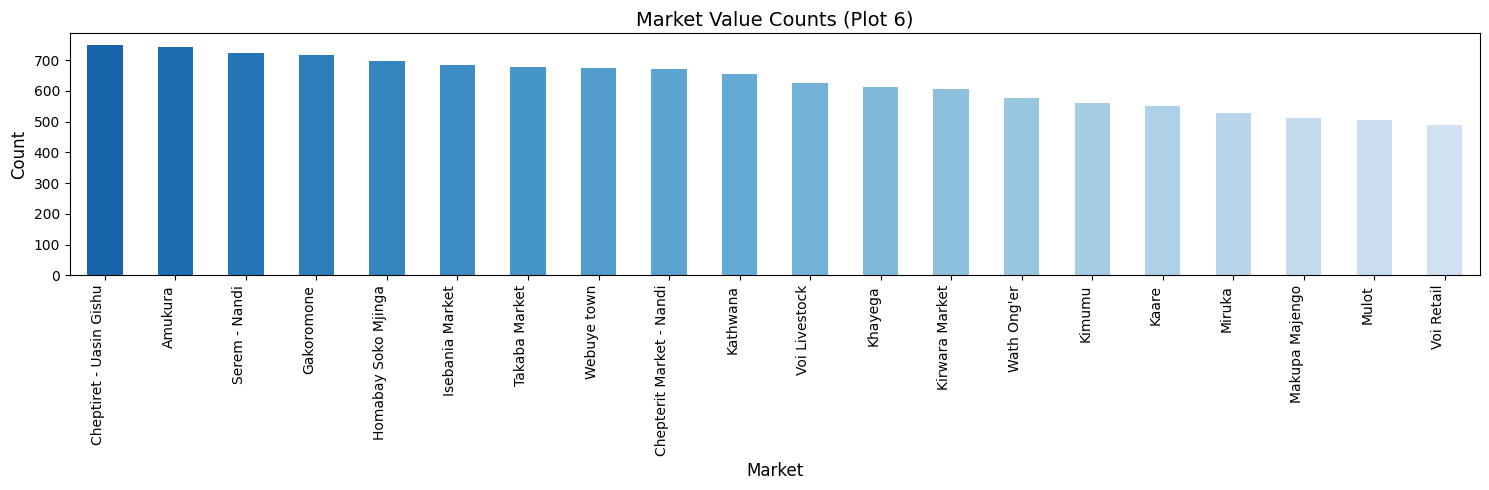

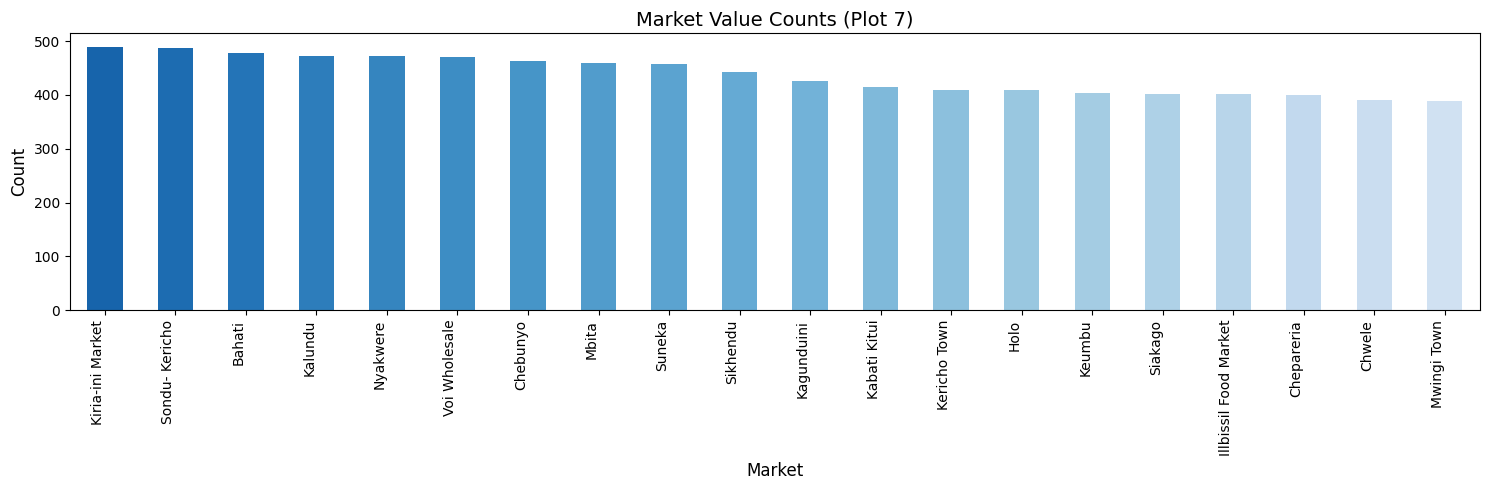

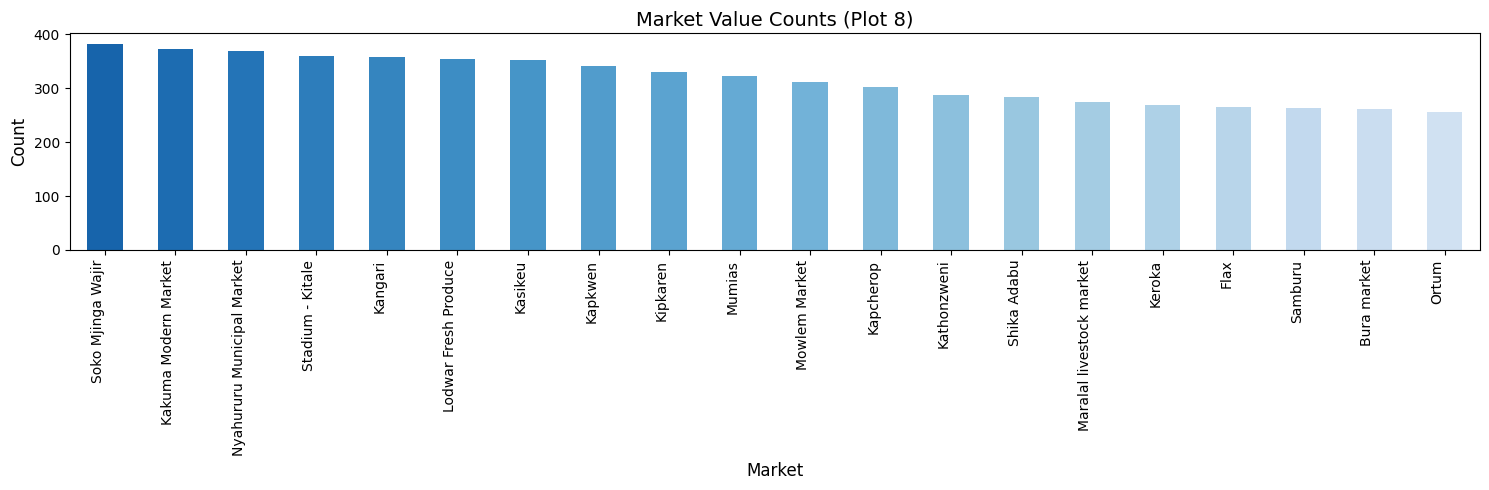

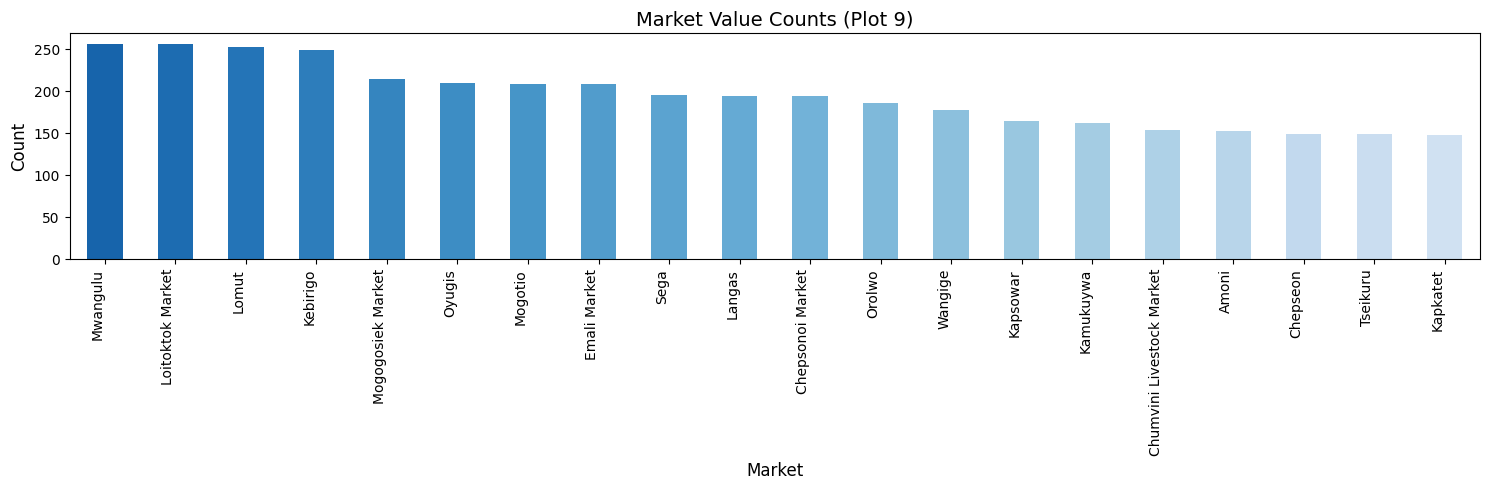

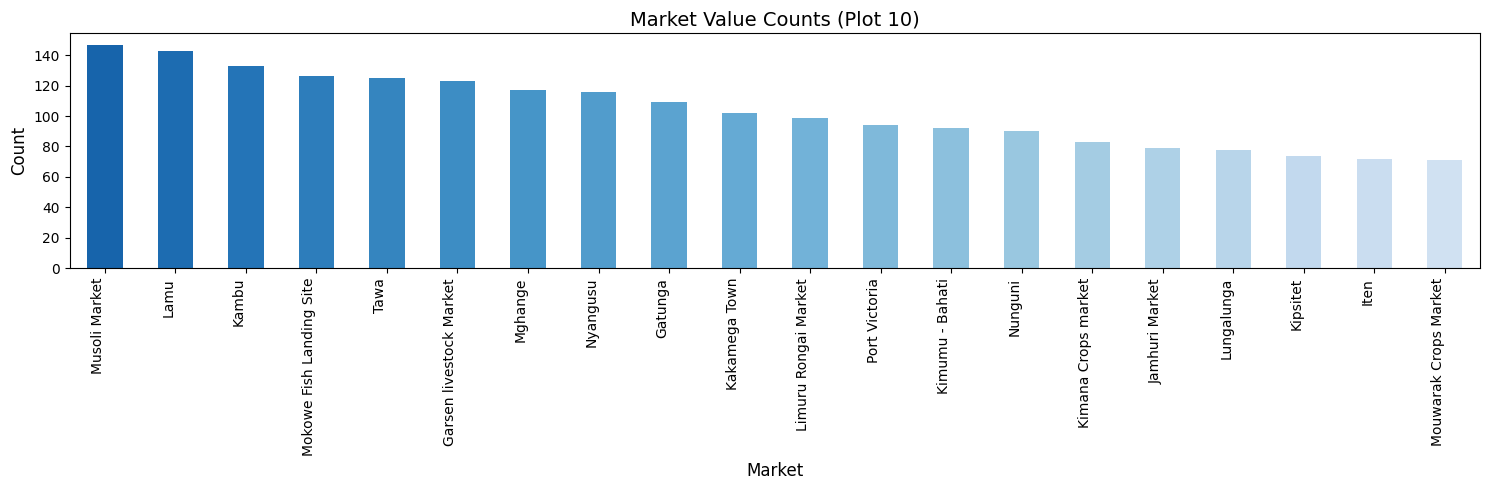

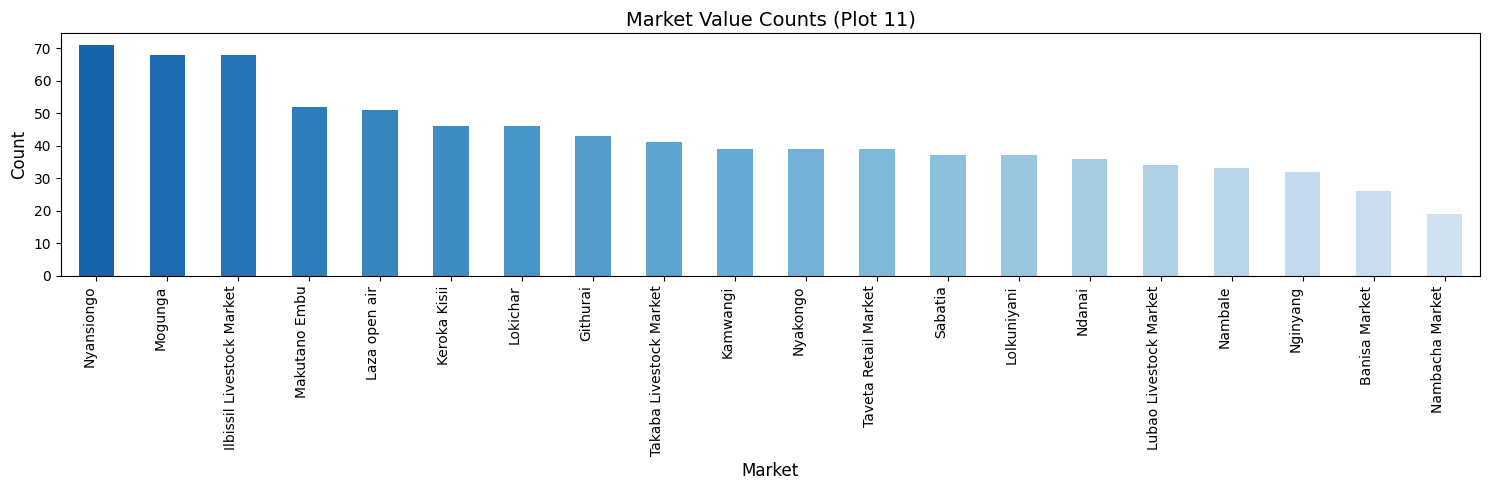

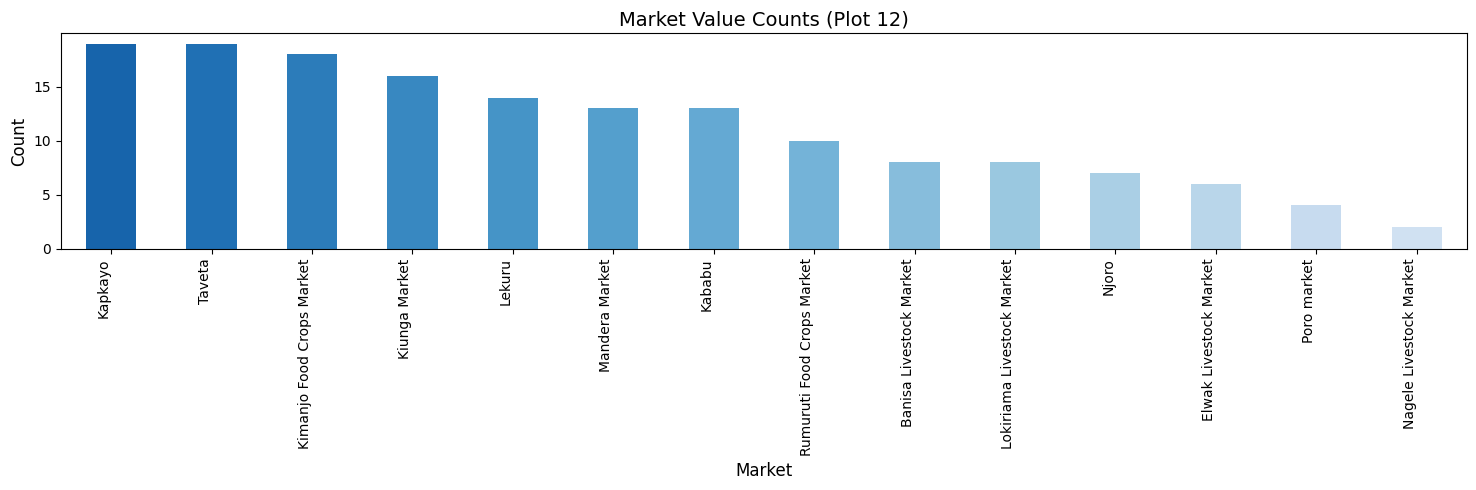

In [21]:
# Get the value counts for the 'market' column, sorted in descending order
market_counts = data_filtered['market'].value_counts()

# Number of entries per plot
entries_per_plot = 20

# Calculate the number of plots needed
num_plots = (len(market_counts) // entries_per_plot) + 1

# Loop through and generate each plot
for i in range(num_plots):
    # Get the start and end indices for this plot
    start_idx = i * entries_per_plot
    end_idx = (i + 1) * entries_per_plot
    
    # Get the data for this plot
    market_subset = market_counts[start_idx:end_idx]
    
    # Create a color gradient from dark blue to light blue
    colors = plt.cm.Blues(np.linspace(0.8, 0.2, len(market_subset)))
    
    # Create the plot
    plt.figure(figsize=(15, 5))
    market_subset.plot(kind='bar', color=colors)
    
    # Add titles and labels
    plt.title(f'Market Value Counts (Plot {i + 1})', fontsize=14)
    plt.xlabel('Market', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=90, ha='right', fontsize=10)
    
    # Adjust layout for better appearance
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [22]:
# Group by 'market' and 'county', and then count the number of occurrences
market_aggregation = data_filtered.groupby(['market', 'county']).size().reset_index(name='Count')

# Sort the results by 'Count' in descending order
market_aggregation = market_aggregation.sort_values(by='Count', ascending=False)

# Display the aggregated DataFrame
market_aggregation

market           county  Count
173             Nakuru Wakulima           Nakuru  13322
109  Kitale Municipality Market      Trans-Nzoia  10960
169        Nairobi Supermarkets          Nairobi   9427
28                 Diani Market            Kwale   8963
4                          Aram            Siaya   8048
34                    Embu Town             Embu   7404
23                     Cheptulu           Vihiga   6609
24                        Chuka    Tharaka-Nithi   6497
60                        Kagio        Kirinyaga   5779
113                       Kutus        Kirinyaga   5672
181            Ngurubani Market        Kirinyaga   5482
221          Tala Centre Market         Machakos   4835
215                   Soko mpya        Nyandarua   4684
189                   Nyamakima          Nairobi   4629
170            Nairobi Wakulima          Nairobi   4140
105                    Kiritiri             Embu   4123
84                   Kawangware          Nairobi   4090
1                         Akala            Siaya   3996
42                      Gikomba          Nairobi   3920
70               Kangemi Market          Nairobi   3914
29                Eldama Ravine          Baringo   3822
137          Malindi Old Market           Kilifi   3657
30                 Eldoret Main      Uasin-Gishu   3618
93                       Kibuye           Kisumu   3532
134          Makutano Kirinyaga        Kirinyaga   3493
5    Athi River Open air Market         Machakos   3491
159                      Mtwapa           Kilifi   3248
158                   Mpeketoni             Lamu   3200
89                     Kerugoya        Kirinyaga   3023
11                        Bondo            Siaya   2870
172           Nakuru Top Market           Nakuru   2747
16                 Charo wa Mae           Kilifi   2745
171             Naivasha Market           Nakuru   2599
71                      Kangeta             Meru   2578
155                        Molo           Nakuru   2559
44                      Gongoni           Kilifi   2453
78                     Karatina            Nyeri   2345
192              Nyeri open air            Nyeri   2276
92                       Kibiok            Nandi   2225
10                      Bondeni      Trans-Nzoia   2187
98            Kiminini - Kitale      Trans-Nzoia   2149
27                 Daraja Mbili            Kisii   2096
0                         Ahero           Kisumu   2074
135         Makutano West Pokot       West-Pokot   1992
144                 Masii Crops         Machakos   1896
39           Garissa Soko Mugdi          Garissa   1841
211                       Siaya            Siaya   1823
15                        Chaka            Nyeri   1816
142                    Marikiti          Mombasa   1727
53                       Kaanwa    Tharaka-Nithi   1599
101                     Kinango            Kwale   1597
146                       Mbale           Vihiga   1558
180                Ngong market          Kajiado   1530
201                       Rongo           Migori   1433
47                       Ikonge          Nyamira   1433
128                      Mabera           Migori   1420
193                    Ol-Kalou        Nyandarua   1418
143                     Marindi           Migori   1415
108       Kiserian crops market          Kajiado   1391
226                      Ugunja            Siaya   1384
110                   Kitengela          Kajiado   1351
125                      Luanda           Vihiga   1350
233                    Wundanyi     Taita-Taveta   1347
129        Machakos Main Market         Machakos   1319
59               Kabiyet Market            Nandi   1292
37                      Gakindu            Nyeri   1283
112                    Kongowea          Mombasa   1246
80                       Kasuku        Nyandarua   1219
183                       Nkubu             Meru   1208
6                        Awendo           Migori   1194
76              Kapsabet Market            Nandi 

---

## Introduction to Time Series Analysis for Market Trends

This time series analysis will help us uncover key insights about market trends over a period of three years (July 2021 to June 2024). The goal is to identify patterns related to commodity demand, market performance, county sales activity, and profitability. Specifically, I will explore:

1. Popular Commodities Based on Aggregated Volumes: This will highlight commodities with the highest demand, helping to understand consumer preferences.

2. Popular Markets Based on Aggregated Volumes: Understanding where the most sales activity happens provides insights into market hotspots.

3. Counties Aggregated by Market Counts: Identifying which counties have the most sales points allows us to pinpoint regions with the most market penetration.

4. Counties Aggregated by Volumes: Counties with the greatest demand, based on the volume of commodities consumed, reveal key areas of market focus.

5. Most Profitable Commodities: Calculating profitability based on the percentage difference between retail and wholesale prices will help market players understand which commodities offer the best margins.

6. Best Commodity Options with Both High Volumes and High Resell Percentages: Ideal crops for smallholder farmers will be identified based on the combination of high demand and profitability.
The next step is to aggregate the data by month and analyze each of these metrics to gain a clearer understanding of the trends.

In [23]:
# Ensure the 'date' column is in datetime format
data_filtered['date'] = pd.to_datetime(data_filtered['date'])

# Create a new column for 'year-month'
data_filtered['year_month'] = data_filtered['date'].dt.to_period('M')

# Create a new column for quarters (Q1, Q2, Q3, Q4)
data_filtered['quarter'] = data_filtered['date'].dt.to_period('Q')

# Aggregate by year-month, commodity, county, and market
aggregated_data = data_filtered.groupby(['year_month', 'quarter', 'commodity', 'county', 'market']).agg(
    total_volume_tonnes=('volume_supplied_tonnes', 'sum'),
    avg_wholesale_price=('wholesale_price_ksh', 'mean'),
    avg_retail_price=('retail_price_ksh', 'mean')
).reset_index()

# Calculate the resell margin (retail - wholesale)
aggregated_data['resell_margin'] = aggregated_data['avg_retail_price'] - aggregated_data['avg_wholesale_price']

# Calculate the percentage profit ((retail - wholesale) / wholesale * 100)
aggregated_data['percentage_profit'] = (aggregated_data['resell_margin'] / aggregated_data['avg_wholesale_price']) * 100

# Reorder columns so the quarter column comes right after the date column
aggregated_data = aggregated_data[['year_month', 'quarter', 'commodity', 'county', 'market', 'total_volume_tonnes', 
                                   'avg_wholesale_price', 'avg_retail_price', 'resell_margin', 'percentage_profit']]

# Round all numeric columns to 2 decimal places
aggregated_data[['total_volume_tonnes', 'avg_wholesale_price', 'avg_retail_price', 'resell_margin', 'percentage_profit']] = \
    aggregated_data[['total_volume_tonnes', 'avg_wholesale_price', 'avg_retail_price', 'resell_margin', 'percentage_profit']].round(2)

# Convert numeric columns to string with 2 decimal places for consistent display
aggregated_data['avg_retail_price'] = aggregated_data['avg_retail_price'].apply(lambda x: f"{x:.2f}")
aggregated_data['avg_wholesale_price'] = aggregated_data['avg_wholesale_price'].apply(lambda x: f"{x:.2f}")
aggregated_data['resell_margin'] = aggregated_data['resell_margin'].apply(lambda x: f"{x:.2f}")
aggregated_data['percentage_profit'] = aggregated_data['percentage_profit'].apply(lambda x: f"{x:.2f}")

# Display the aggregated dataframe
aggregated_data.head()

year_month quarter            commodity   county                 market  \
0    2021-07  2021Q3  Amaranthus (Terere)  Baringo          Eldama Ravine   
1    2021-07  2021Q3  Amaranthus (Terere)    Bomet               Chebunyo   
2    2021-07  2021Q3  Amaranthus (Terere)  Bungoma                 Chwele   
3    2021-07  2021Q3  Amaranthus (Terere)  Kajiado  Illbissil Food Market   
4    2021-07  2021Q3  Amaranthus (Terere)  Kajiado              Kitengela   

   total_volume_tonnes avg_wholesale_price avg_retail_price resell_margin  \
0                 1.00               34.16            55.00         20.84   
1                 0.15               45.00            70.00         25.00   
2                 4.00               26.66            55.00         28.34   
3                 0.50               23.33            50.00         26.67   
4                 0.50               40.00            65.00         25.00   

  percentage_profit  
0             60.98  
1             55.56  
2            106.26  
3            114.32  
4             62.50

In [24]:
# Aggregate by commodity and calculate total volume
popular_commodities = aggregated_data.groupby('commodity').agg(
    total_volume_tonnes=('total_volume_tonnes', 'sum')
).reset_index()

# Sort by total volume in descending order
popular_commodities = popular_commodities.sort_values(by='total_volume_tonnes', ascending=False)

# Display the commodities based on volume
print(popular_commodities)

                            commodity  total_volume_tonnes
53               White Irish Potatoes             84558.12
17                          Dry Maize             79472.61
50                        Water Melon             36112.21
18                         Dry Onions             35551.68
52                        Wheat Flour             23175.57
26                        Green Grams             22466.22
44                               Rice             20350.37
34                        Maize Flour             17000.03
31                  Kales/Sukuma Wiki             15976.52
51                              Wheat             13112.77
5              Beans Rosecoco (Nyayo)             10966.10
27                        Green Maize             10674.73
4         Beans Red Haricot (Wairimu)              9401.82
47                      Spring Onions              8899.79
46                            Spinach              8464.56
28                        Ground Nuts              7668.

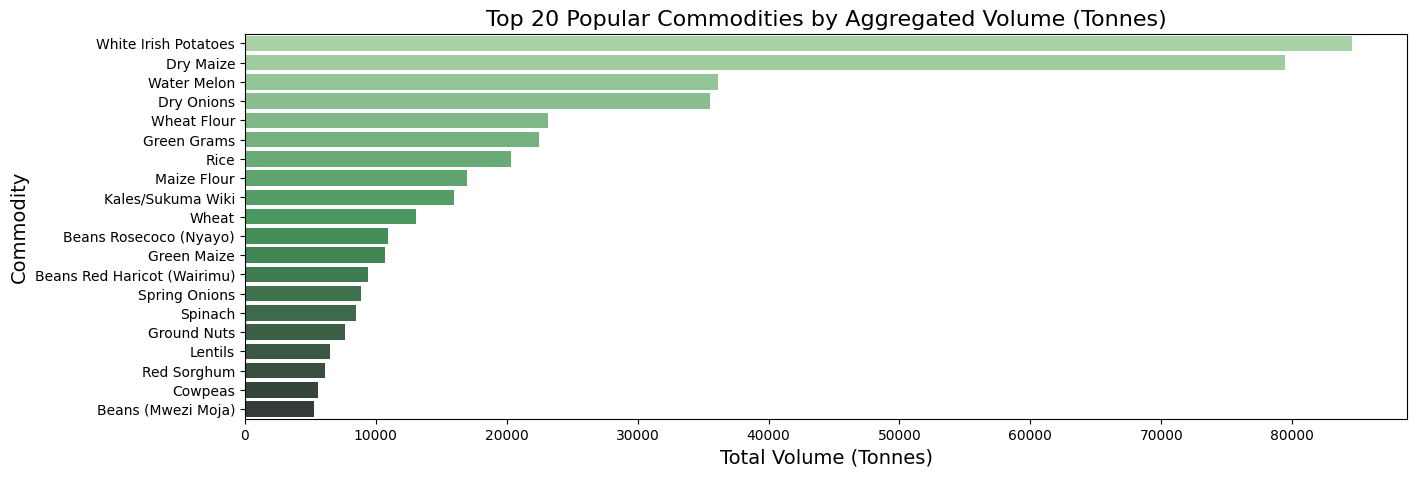

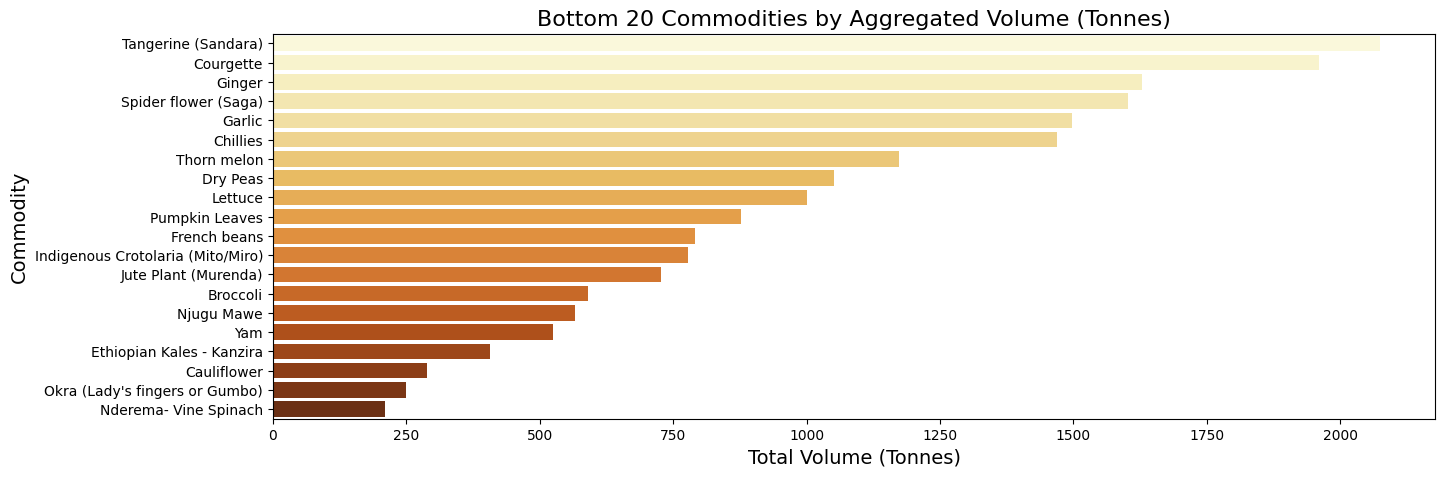

In [25]:
# Select the top 20 commodities by volume in descending order
top_20_commodities = popular_commodities.head(20)

# Select the bottom 20 commodities by volume in ascending order
bottom_20_commodities = popular_commodities.tail(20)

# Plotting top 20 popular commodities by volume with a deep green gradient
plt.figure(figsize=(15, 5))
sns.barplot(data=top_20_commodities, x='total_volume_tonnes', y='commodity', palette='Greens_d')
plt.title('Top 20 Popular Commodities by Aggregated Volume (Tonnes)', fontsize=16)
plt.xlabel('Total Volume (Tonnes)', fontsize=14)
plt.ylabel('Commodity', fontsize=14)
plt.show()

# Plotting bottom 20 least popular commodities by volume with a mustard gradient
plt.figure(figsize=(15, 5))
sns.barplot(data=bottom_20_commodities, x='total_volume_tonnes', y='commodity', palette='YlOrBr')
plt.title('Bottom 20 Commodities by Aggregated Volume (Tonnes)', fontsize=16)
plt.xlabel('Total Volume (Tonnes)', fontsize=14)
plt.ylabel('Commodity', fontsize=14)
plt.show()

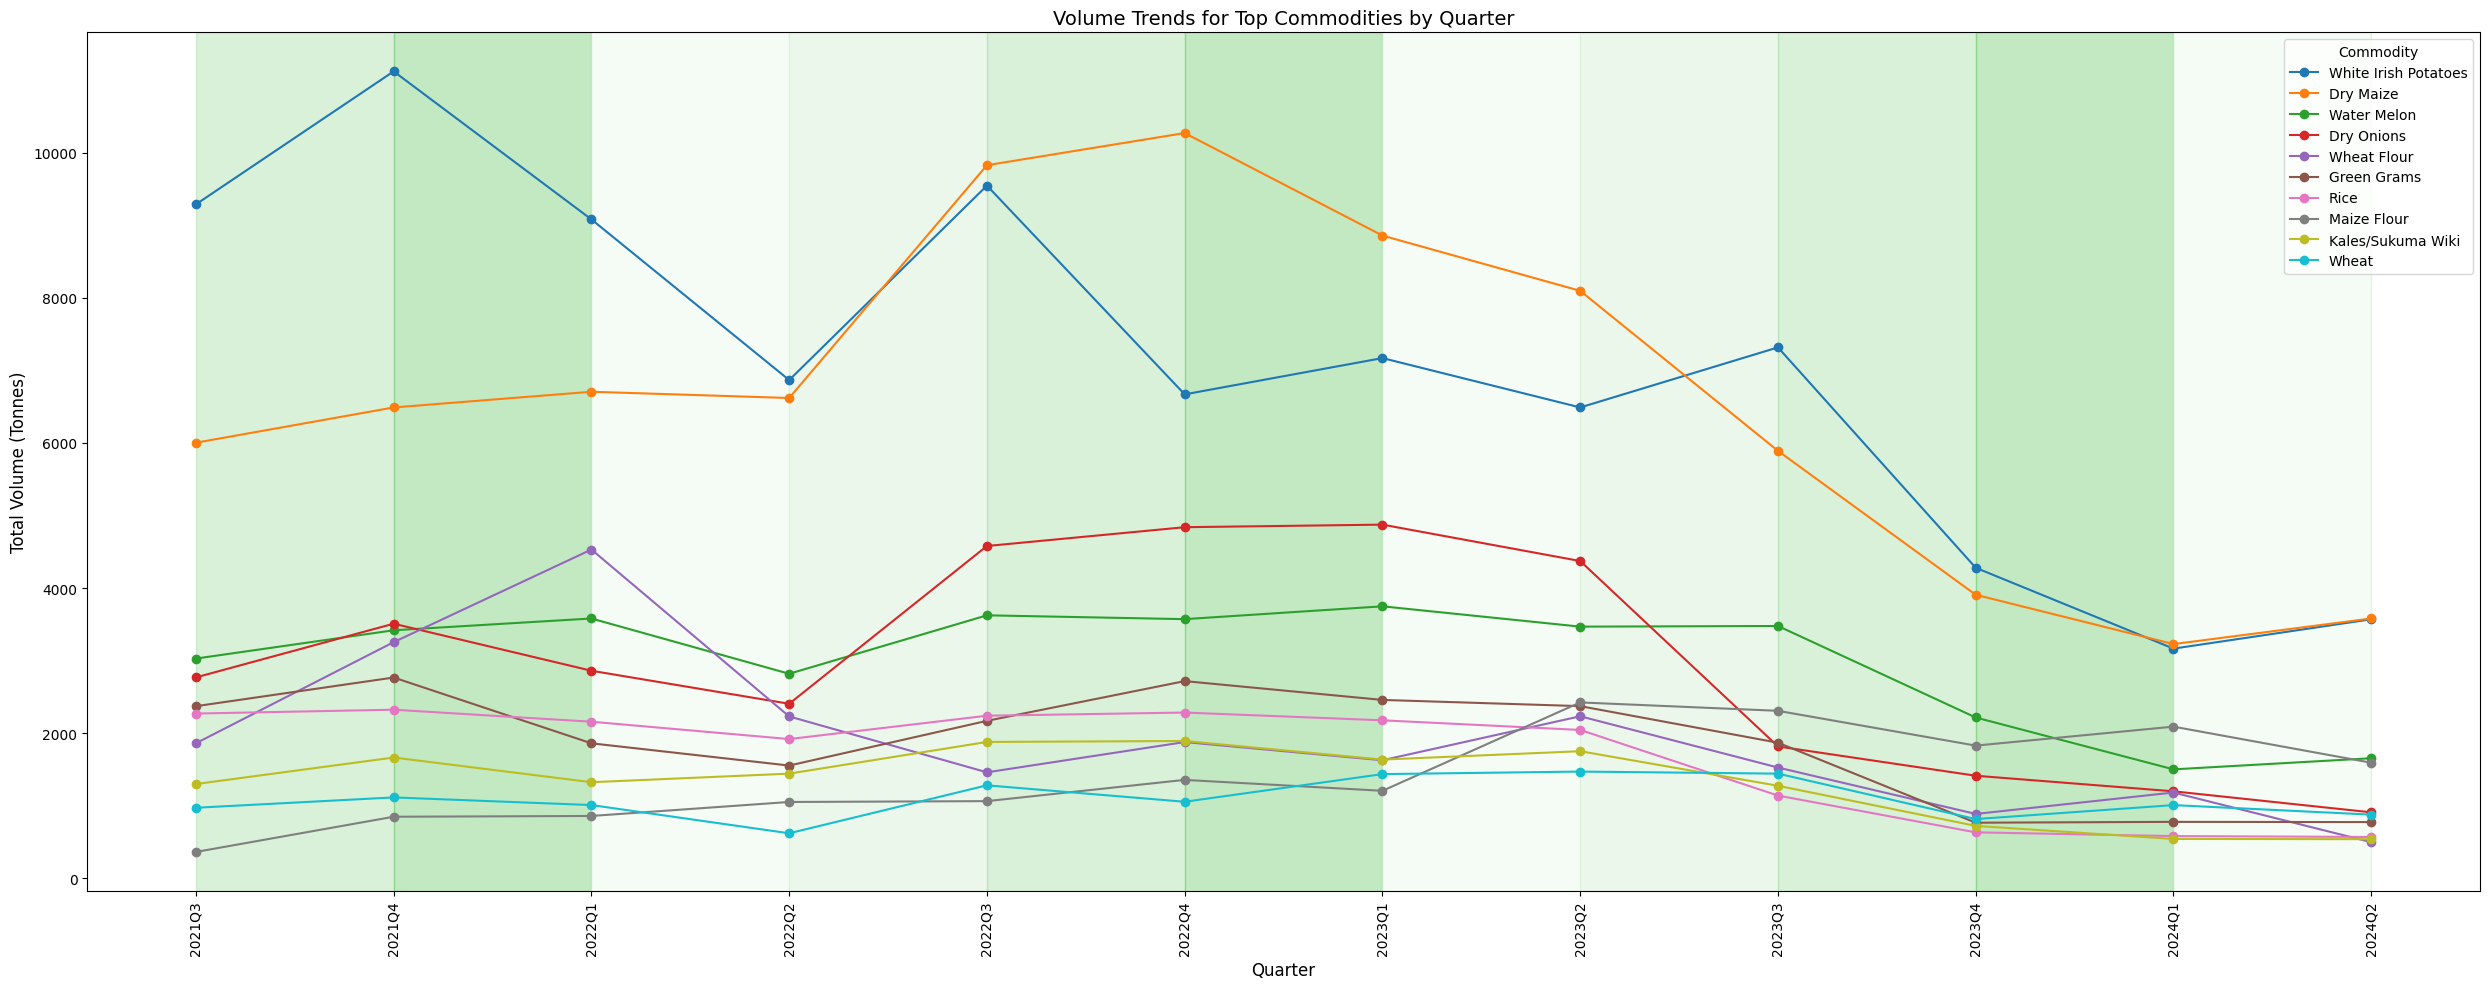

In [26]:
# Ensure the 'quarter' column is converted to a string format for plotting
aggregated_data['quarter'] = aggregated_data['quarter'].astype(str)

# Aggregate by commodity and quarter and calculate total volume for each quarter
volume_trends = aggregated_data.groupby(['quarter', 'commodity']).agg(
    total_volume_tonnes=('total_volume_tonnes', 'sum')
).reset_index()

# Define the quarters to use as labels on the x-axis
quarter_labels = sorted(volume_trends['quarter'].unique())

# Select the top 10 commodities based on total volume
top_commodities = popular_commodities.head(10)['commodity']

# Filter the data to include only the top commodities
filtered_data = volume_trends[volume_trends['commodity'].isin(top_commodities)]

# Create the plot
plt.figure(figsize=(25, 10))

# Plot each commodity's trend over time
for commodity in top_commodities:
    commodity_data = filtered_data[filtered_data['commodity'] == commodity]
    plt.plot(commodity_data['quarter'], commodity_data['total_volume_tonnes'], marker='o', label=commodity)

# Define the color shades for Q1 to Q4 (light to dark green)
shading_colors = ['#e0f7e0', '#c1e7c1', '#83d183', '#39b739']  # Light to dark green

# Shade the background for each quarter with corresponding shades of green
for i, quarter in enumerate(quarter_labels):
    if "Q1" in quarter:
        color = shading_colors[0]  # Lightest green for Q1
    elif "Q2" in quarter:
        color = shading_colors[1]  # Slightly darker green for Q2
    elif "Q3" in quarter:
        color = shading_colors[2]  # Darker green for Q3
    elif "Q4" in quarter:
        color = shading_colors[3]  # Darkest green for Q4
    
    plt.axvspan(quarter, quarter_labels[i+1] if i+1 < len(quarter_labels) else quarter, 
                color=color, alpha=0.3)

# Set plot labels and title
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Total Volume (Tonnes)', fontsize=12)
plt.title('Volume Trends for Top Commodities by Quarter', fontsize=14)
plt.xticks(rotation=90)
plt.legend(title='Commodity')
plt.tight_layout()
plt.show()

---

##### Findings for Smallholder Farmers:

a) Top Commodities by Volume:

White Irish Potatoes (84,558 tonnes) and Dry Maize (79,473 tonnes) are the most in-demand commodities, with consistent market demand across regions. For farmers, these are strategic crops to focus on for reliable sales.
Other high-volume commodities such as Watermelon, Dry Onions, Wheat Flour, and Green Grams also show considerable demand, providing opportunities for farmers to diversify.

b) Low-Volume Commodities:

Nderema (Vine Spinach) and Okra have the lowest volumes, indicating niche markets. However, if local or specialized markets exist for these crops, they could still be profitable with less competition.

c) Mid-tier Commodities:

Commodities like Spinach, Cowpeas, Pigeon Peas, and Lentils represent moderate volumes and may have regional demand. Farmers can focus on growing these if they have access to these specific markets where demand is steady.


##### Insights for Smallholder Farmers:

a) Prioritize High-Demand Crops: Farmers should prioritize crops like Irish Potatoes, Maize, and Onions, which consistently sell in large volumes, ensuring a market presence.

b) Diversification Opportunities: Mid-range crops like Spinach, Cowpeas, and Lentils offer good opportunities for farmers looking to diversify but still capitalize on established demand.

c) Niche Opportunities: Low-volume crops like Nderema or Okra may have smaller, more specialized markets that farmers can tap into if they are located near those niches.


##### Recommendations for Smallholder Farmers:

a) Focus on Regional Demand: Pay attention to which crops are doing well in your specific county or region and focus on high-demand crops that match your farming environment.

b) Explore Crop Diversification: Adding crops like Watermelon and Wheat Flour could help reduce risks tied to market fluctuations in traditional crops like Maize and Potatoes.

---

##### Findings for Market Linkage Players/Brokers:

a) Top Commodities for Brokerage:

Irish Potatoes, Dry Maize, and Watermelon are key commodities to focus on due to the consistently high volume of trade. Brokers who focus on these commodities are more likely to connect with higher demand.

b) Markets with Potential:

Regional Brokerage: The fact that these commodities are traded across various markets means that brokers can facilitate large volumes in multiple regions, making logistics management crucial for profitability.

c) Niche Commodities:

Broccoli and Njugu Mawe may be low in volume but can offer high margins in specialized markets. Brokers who have access to premium markets can exploit these niche commodities.

##### Insights for Market Linkage Players:

a) Focus on Aggregation for High-Demand Commodities: Brokers should focus on high-demand crops like Potatoes, Maize, and Onions, facilitating deals between large suppliers and retailers.

b) Leverage Niche Commodities: Low-volume commodities, while smaller in demand, may offer better margins for brokers with access to premium or specialized markets.

##### Recommendations for Market Linkage Players:

a) Expand to High-Volume Markets: Invest in networks that facilitate bulk sales of high-demand crops like Maize and Onions.

b) Explore Regional Niches: Identify markets that specialize in low-volume crops like Okra or Vine Spinach to secure premium transactions.


---

##### Findings for Retailers:

a) Most Profitable Commodities:

Retailers benefit from consistently high demand for Irish Potatoes and Dry Maize, which are staples in most households.

b) Low-Volume Commodities:

Retailers can also target niche markets with low-volume crops like Okra, Vine Spinach, and Jute Plant, which may have less competition but stable demand in specialized areas.

c) Opportunities in Mid-Tier Commodities:

Commodities like Green Grams, Spinach, and Cowpeas offer moderate demand but are consistently available in the market. Retailers can position themselves as reliable suppliers of these mid-tier commodities.

##### Insights for Retailers:

a) Stock Popular Commodities: Ensure regular supply of Potatoes, Maize, Onions, and Watermelon since these are high in demand across different consumer segments.

b) Diversify with Low-Volume Crops: While high-volume commodities are essential, offering niche items like Broccoli and Garlic can attract premium buyers and higher profit margins.

##### Recommendations for Retailers:

a) Invest in High-Demand Staples: Build your stock of staples such as Potatoes and Maize to ensure a steady stream of buyers.

b) Capitalize on Niche Markets: By offering a mix of high- and low-demand commodities, retailers can cater to a wider audience and potentially tap into higher margins.

---


##### Overall Insights for All Three Groups:

a) High-Demand Commodities: All stakeholders (farmers, brokers, and retailers) should focus on high-volume crops such as Irish Potatoes, Maize, and Watermelon to ensure steady revenue.

b) Niche Commodities: Niche markets for low-volume crops like Spinach, Okra, and Vine Spinach can offer high margins and less competition but require access to specialized markets.

c) Regional and Seasonal Focus: Paying attention to regional preferences and seasonal fluctuations is critical for all groups to maximize profits and minimize risk.

---

In [27]:
# Step 2.0: Popular Markets Based on Aggregated Volumes

# Filter out 'Nairobi Supermarkets' before aggregating
filtered_data = aggregated_data[aggregated_data['market'] != 'Nairobi Supermarkets']

# Aggregate by market and county and calculate the total volume
popular_markets = filtered_data.groupby(['market', 'county']).agg(
    total_volume_tonnes=('total_volume_tonnes', 'sum')
).reset_index()

# Sort by total volume in descending order
popular_markets = popular_markets.sort_values(by='total_volume_tonnes', ascending=False)

# Display the top 20 markets based on volume
top_20_markets = popular_markets.head(20)

# Display the bottom 20 markets based on volume
bottom_20_markets = popular_markets.tail(20)

# Display the results
print("Top 20 Markets by Aggregated Volume:")
print(top_20_markets)

print("\nBottom 20 Markets by Aggregated Volume:")
print(bottom_20_markets)

Top 20 Markets by Aggregated Volume:
                         market         county  total_volume_tonnes
172             Nakuru Wakulima         Nakuru             19691.86
28                 Diani Market          Kwale             15909.85
4                          Aram          Siaya             14704.81
180            Ngurubani Market      Kirinyaga             13384.90
30                 Eldoret Main    Uasin-Gishu             12198.49
109  Kitale Municipality Market    Trans-Nzoia             11614.70
105                    Kiritiri           Embu             10985.33
60                        Kagio      Kirinyaga             10596.68
34                    Embu Town           Embu             10361.56
11                        Bondo          Siaya             10047.20
39           Garissa Soko Mugdi        Garissa              9999.65
220          Tala Centre Market       Machakos              9206.04
24                        Chuka  Tharaka-Nithi              9002.44
188        

In [28]:
# Step 2.1: Aggregated Volume by County

# Aggregate by county and calculate the total volume and number of markets
aggregated_by_county = filtered_data.groupby('county').agg(
    number_of_markets=('market', 'nunique'),   # Count unique markets in each county
    total_volume_tonnes=('total_volume_tonnes', 'sum')  # Sum total volume per county
).reset_index()

# Sort by total volume in descending order
aggregated_by_county = aggregated_by_county.sort_values(by='total_volume_tonnes', ascending=False)

# Display the results
print("Aggregated Volume by County:")
print(aggregated_by_county)

Aggregated Volume by County:
             county  number_of_markets  total_volume_tonnes
13        Kirinyaga                  5             40720.21
27          Nairobi                  5             36943.80
34            Siaya                  5             36332.46
28           Nakuru                  6             31355.22
5              Embu                  5             23126.77
24           Migori                  7             18784.68
17            Kwale                  5             18269.90
20         Machakos                  4             17906.25
41           Vihiga                  6             17109.82
38      Trans-Nzoia                  7             16388.46
40      Uasin-Gishu                  6             16096.66
15           Kisumu                  5             15116.58
8           Kajiado                  8             13296.45
29            Nandi                  6             12484.14
32            Nyeri                  5             12171.19
37    Thara

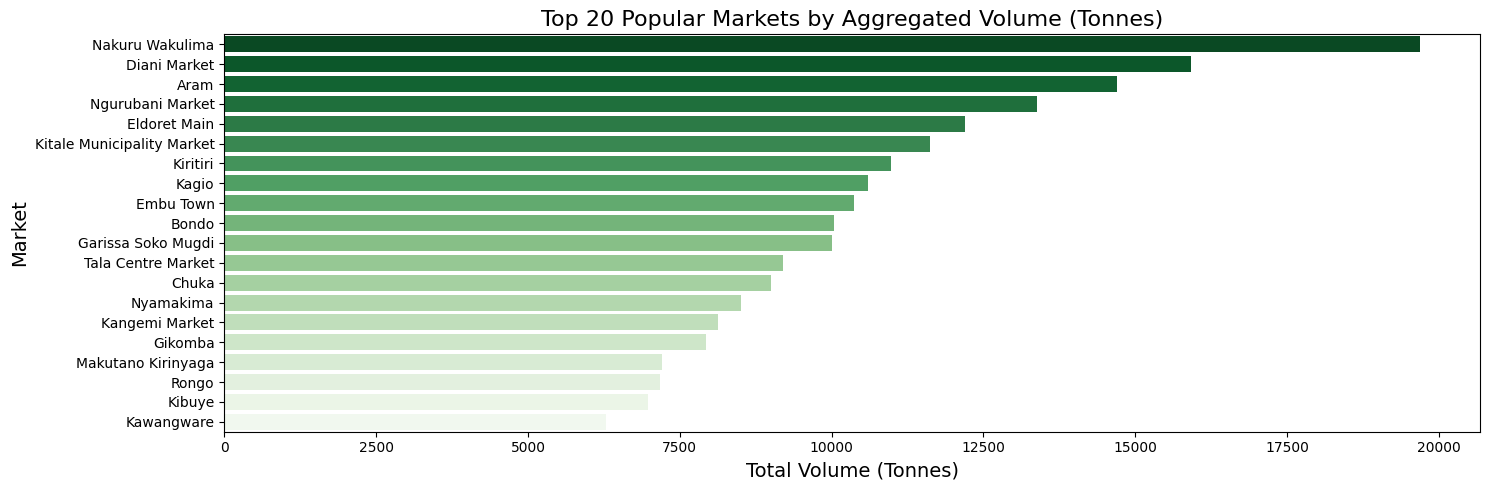

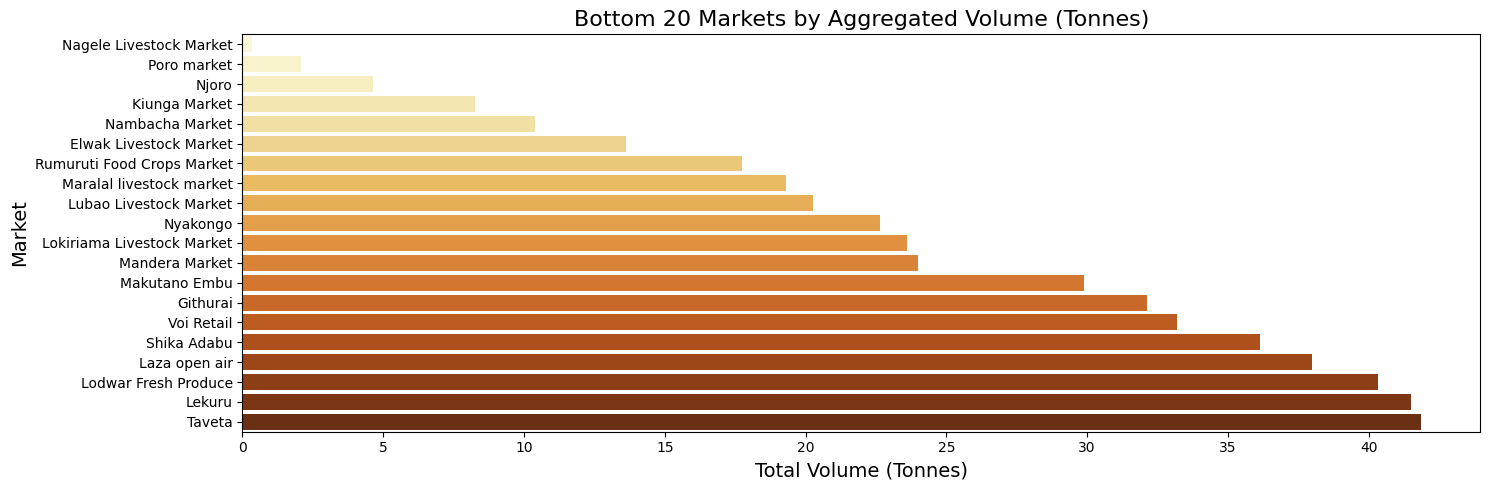

In [29]:
# Plotting top 20 popular markets by volume with a smooth green gradient
plt.figure(figsize=(15, 5))
# Create a sorted order for the gradient color based on volume
top_20_markets_sorted = top_20_markets.sort_values(by='total_volume_tonnes', ascending=False)
sns.barplot(data=top_20_markets_sorted, x='total_volume_tonnes', y='market', palette='Greens_r')  # Reverse for smooth gradient
plt.title('Top 20 Popular Markets by Aggregated Volume (Tonnes)', fontsize=16)
plt.xlabel('Total Volume (Tonnes)', fontsize=14)
plt.ylabel('Market', fontsize=14)
plt.tight_layout()
plt.show()

# Plotting bottom 20 least popular markets by volume with a smooth mustard gradient
plt.figure(figsize=(15, 5))
# Create a sorted order for the gradient color based on volume
bottom_20_markets_sorted = bottom_20_markets.sort_values(by='total_volume_tonnes', ascending=True)
sns.barplot(data=bottom_20_markets_sorted, x='total_volume_tonnes', y='market', palette='YlOrBr')  # Mustard gradient
plt.title('Bottom 20 Markets by Aggregated Volume (Tonnes)', fontsize=16)
plt.xlabel('Total Volume (Tonnes)', fontsize=14)
plt.ylabel('Market', fontsize=14)
plt.tight_layout()
plt.show()

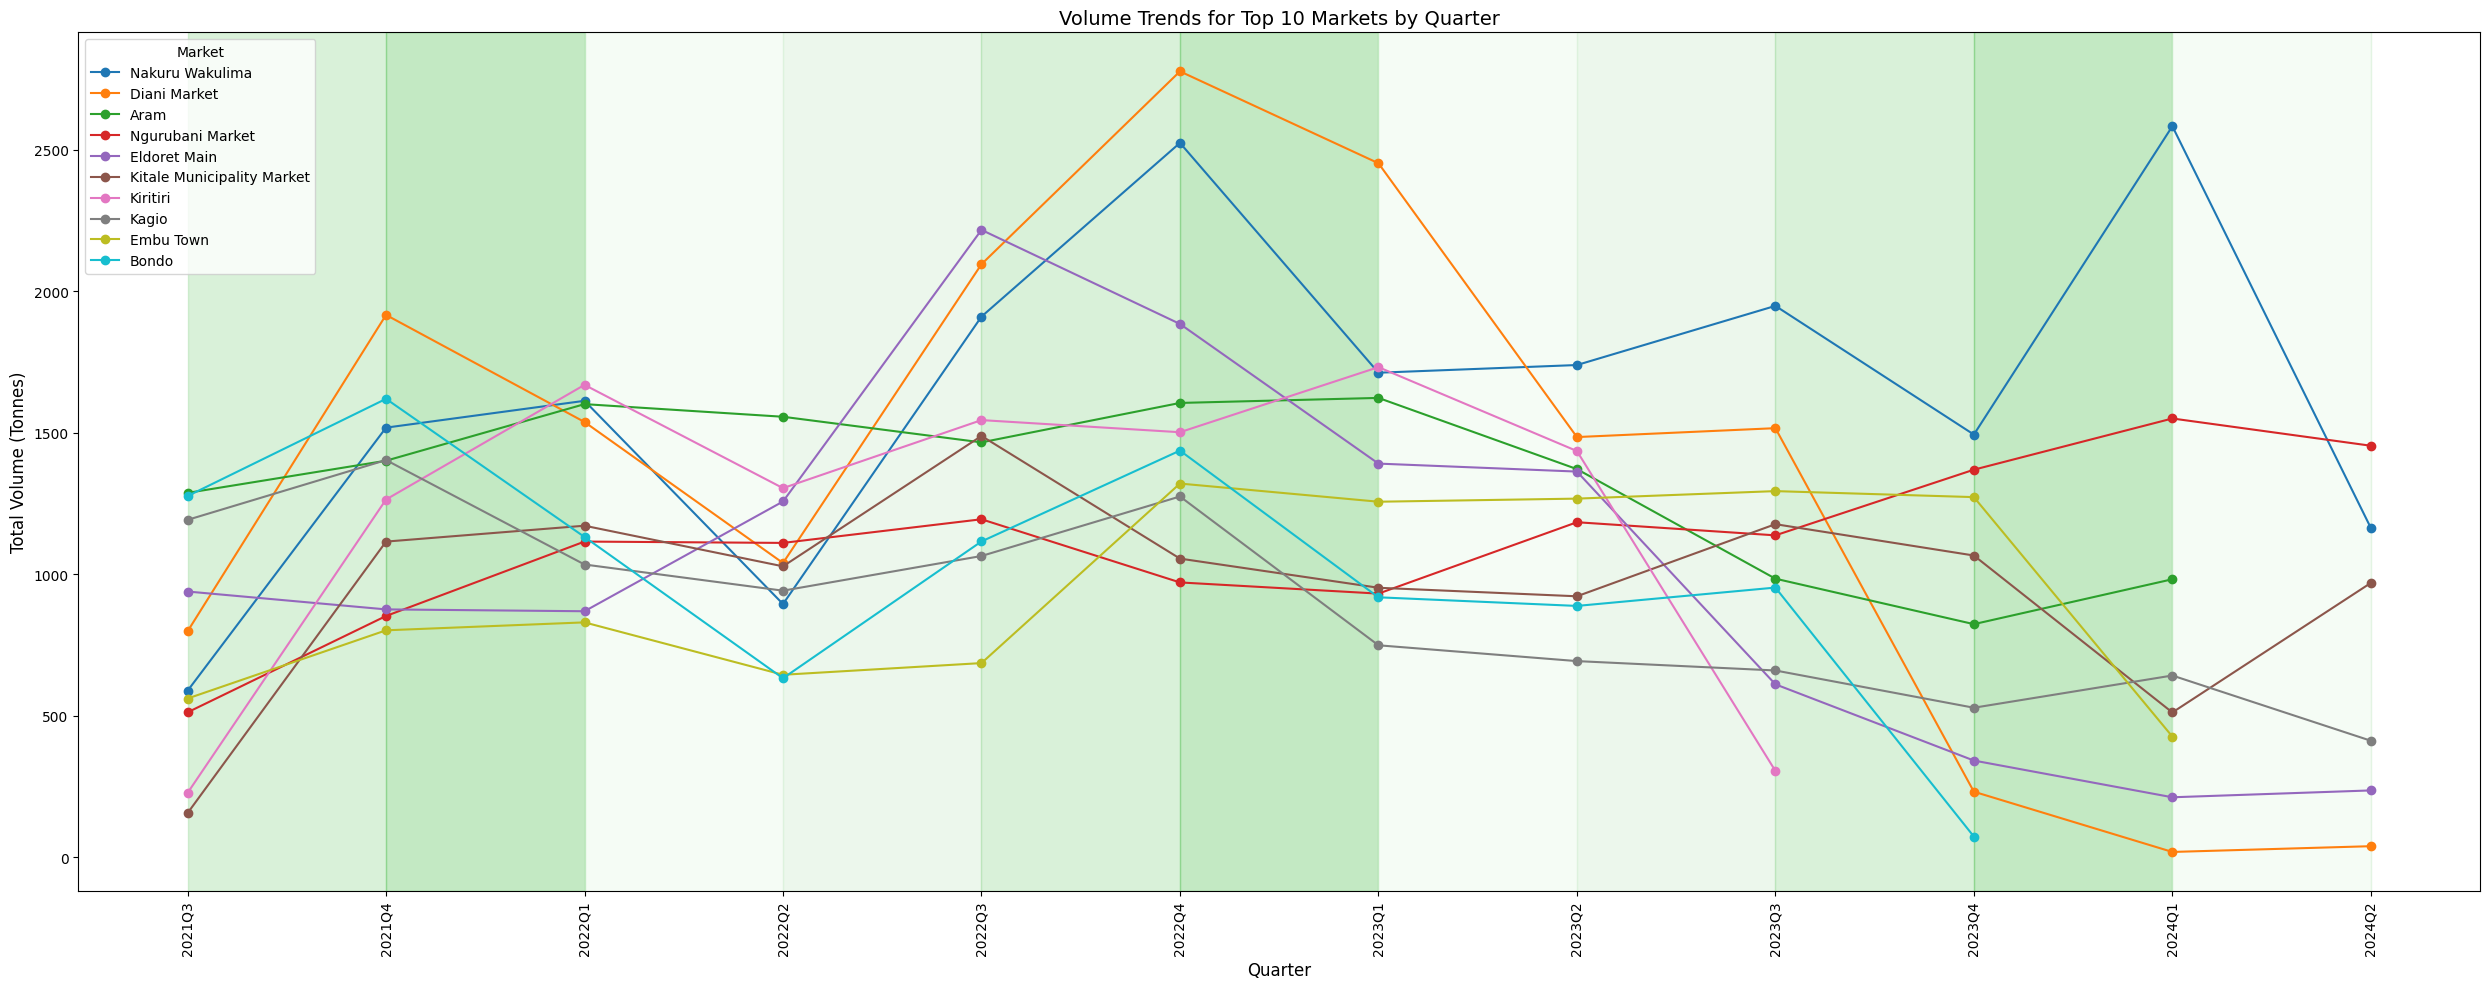

In [30]:
# Ensure the 'quarter' column is converted to a string format for plotting
aggregated_data['quarter'] = aggregated_data['quarter'].astype(str)

# Aggregate by market and quarter and calculate total volume for each quarter
market_volume_trends = aggregated_data.groupby(['quarter', 'market']).agg(
    total_volume_tonnes=('total_volume_tonnes', 'sum')
).reset_index()

# Define the quarters to use as labels on the x-axis
quarter_labels = sorted(market_volume_trends['quarter'].unique())

# Select the top 10 markets based on total volume
top_10_markets = top_20_markets_sorted.head(10)['market']

# Filter the data to include only the top markets
filtered_market_data = market_volume_trends[market_volume_trends['market'].isin(top_10_markets)]

# Create the plot
plt.figure(figsize=(25, 10))

# Plot each market's trend over time
for market in top_10_markets:
    market_data = filtered_market_data[filtered_market_data['market'] == market]
    plt.plot(market_data['quarter'], market_data['total_volume_tonnes'], marker='o', label=market)

# Define the color shades for Q1 to Q4 (light to dark green)
shading_colors = ['#e0f7e0', '#c1e7c1', '#83d183', '#39b739']  # Light to dark green

# Shade the background for each quarter with corresponding shades of green
for i, quarter in enumerate(quarter_labels):
    if "Q1" in quarter:
        color = shading_colors[0]  # Lightest green for Q1
    elif "Q2" in quarter:
        color = shading_colors[1]  # Slightly darker green for Q2
    elif "Q3" in quarter:
        color = shading_colors[2]  # Darker green for Q3
    elif "Q4" in quarter:
        color = shading_colors[3]  # Darkest green for Q4
    
    plt.axvspan(quarter, quarter_labels[i+1] if i+1 < len(quarter_labels) else quarter, 
                color=color, alpha=0.3)

# Set plot labels and title
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Total Volume (Tonnes)', fontsize=12)
plt.title('Volume Trends for Top 10 Markets by Quarter', fontsize=14)
plt.xticks(rotation=90)
plt.legend(title='Market')
plt.tight_layout()
plt.show()

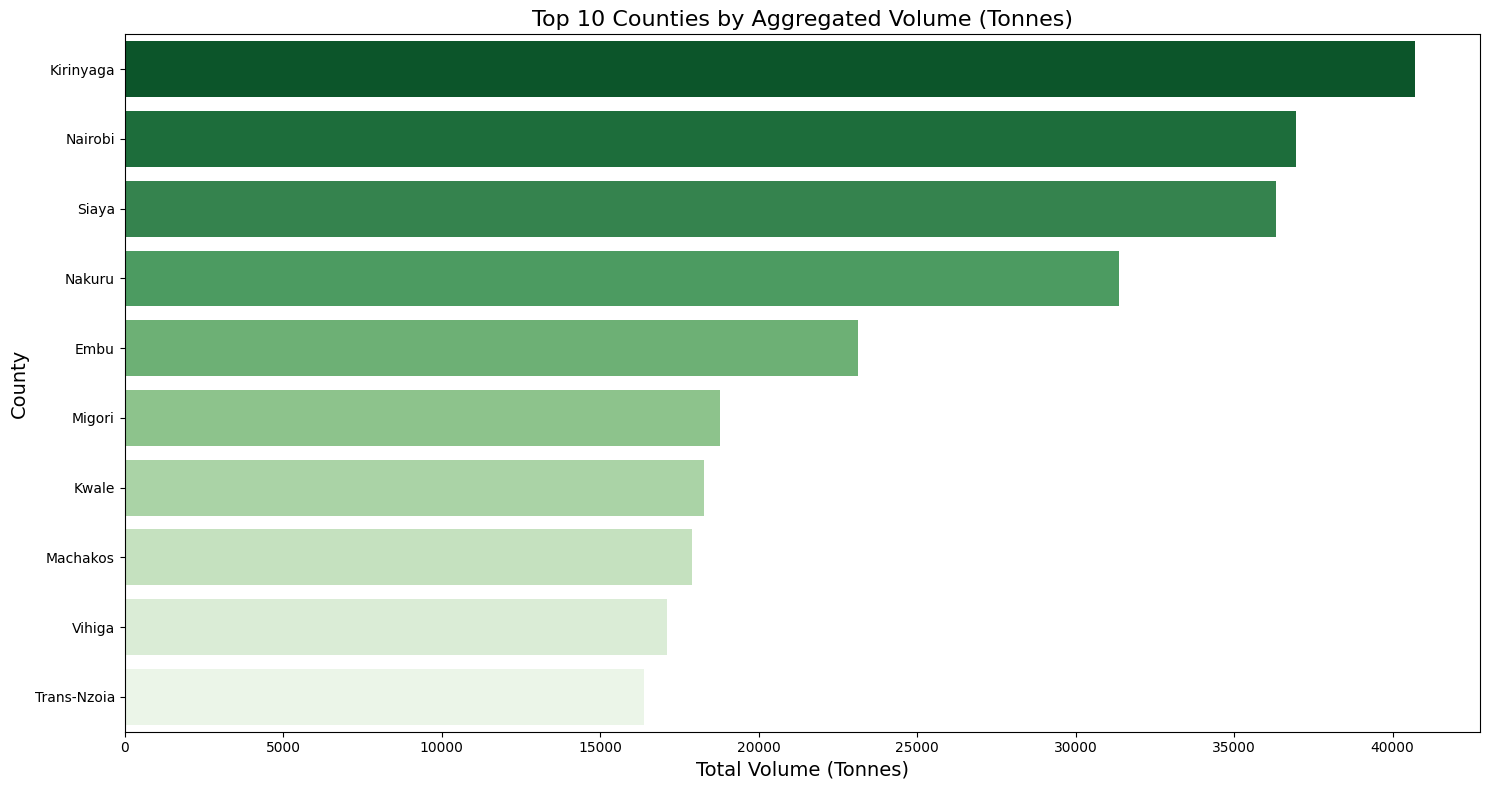

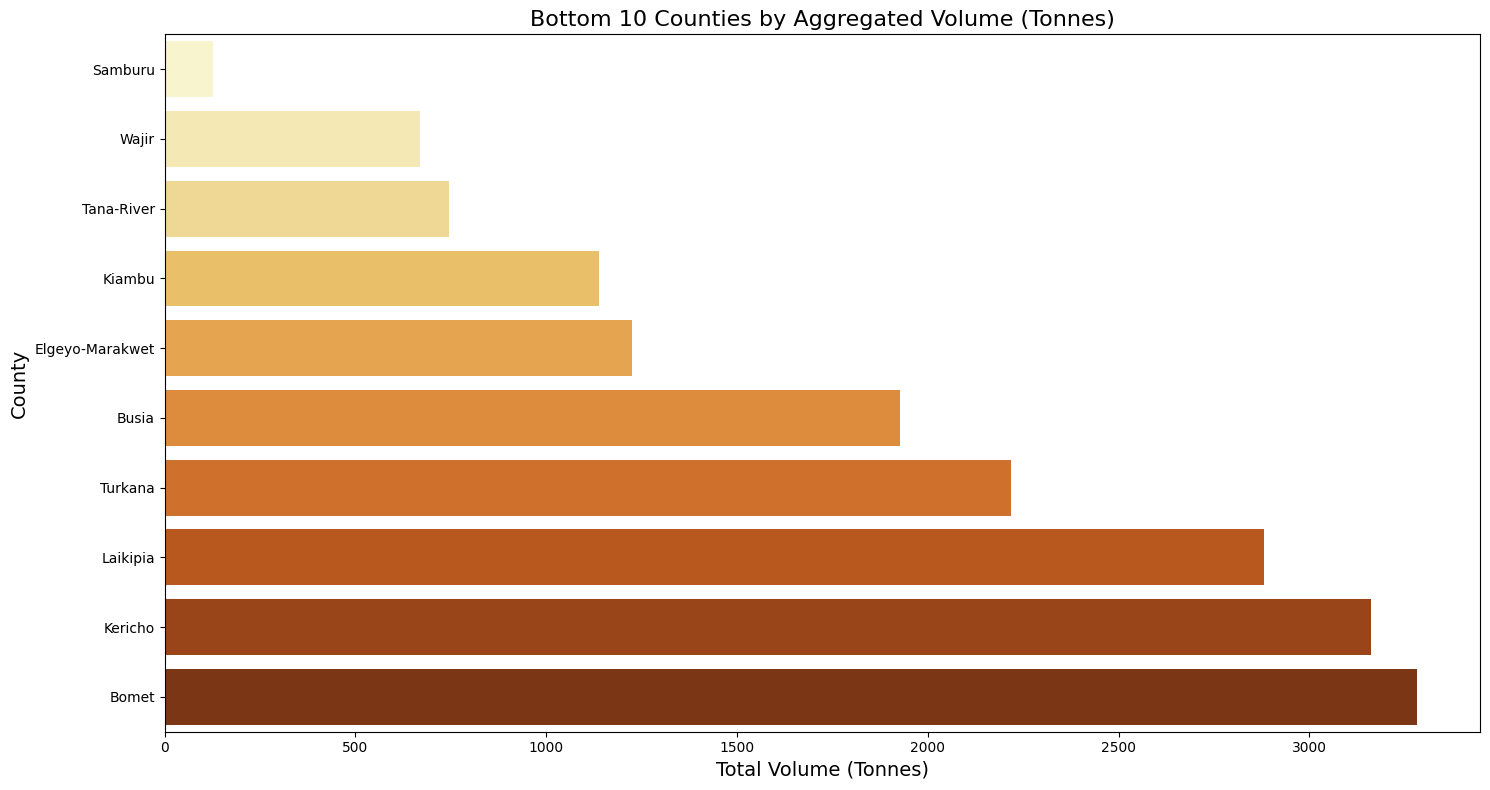

In [31]:
# Adjusted plotting of top 10 counties by volume with a smooth green gradient
plt.figure(figsize=(15, 8))  # Increased figure height for better spacing
top_10_counties_sorted = aggregated_by_county.head(10).sort_values(by='total_volume_tonnes', ascending=False)
sns.barplot(data=top_10_counties_sorted, x='total_volume_tonnes', y='county', palette='Greens_r')
plt.title('Top 10 Counties by Aggregated Volume (Tonnes)', fontsize=16)
plt.xlabel('Total Volume (Tonnes)', fontsize=14)
plt.ylabel('County', fontsize=14)
plt.tight_layout()
plt.show()

# Adjusted plotting of bottom 10 counties by volume with a smooth mustard gradient
plt.figure(figsize=(15, 8))  # Increased figure height for better spacing
bottom_10_counties_sorted = aggregated_by_county.tail(10).sort_values(by='total_volume_tonnes', ascending=True)
sns.barplot(data=bottom_10_counties_sorted, x='total_volume_tonnes', y='county', palette='YlOrBr')
plt.title('Bottom 10 Counties by Aggregated Volume (Tonnes)', fontsize=16)
plt.xlabel('Total Volume (Tonnes)', fontsize=14)
plt.ylabel('County', fontsize=14)
plt.tight_layout()
plt.show()

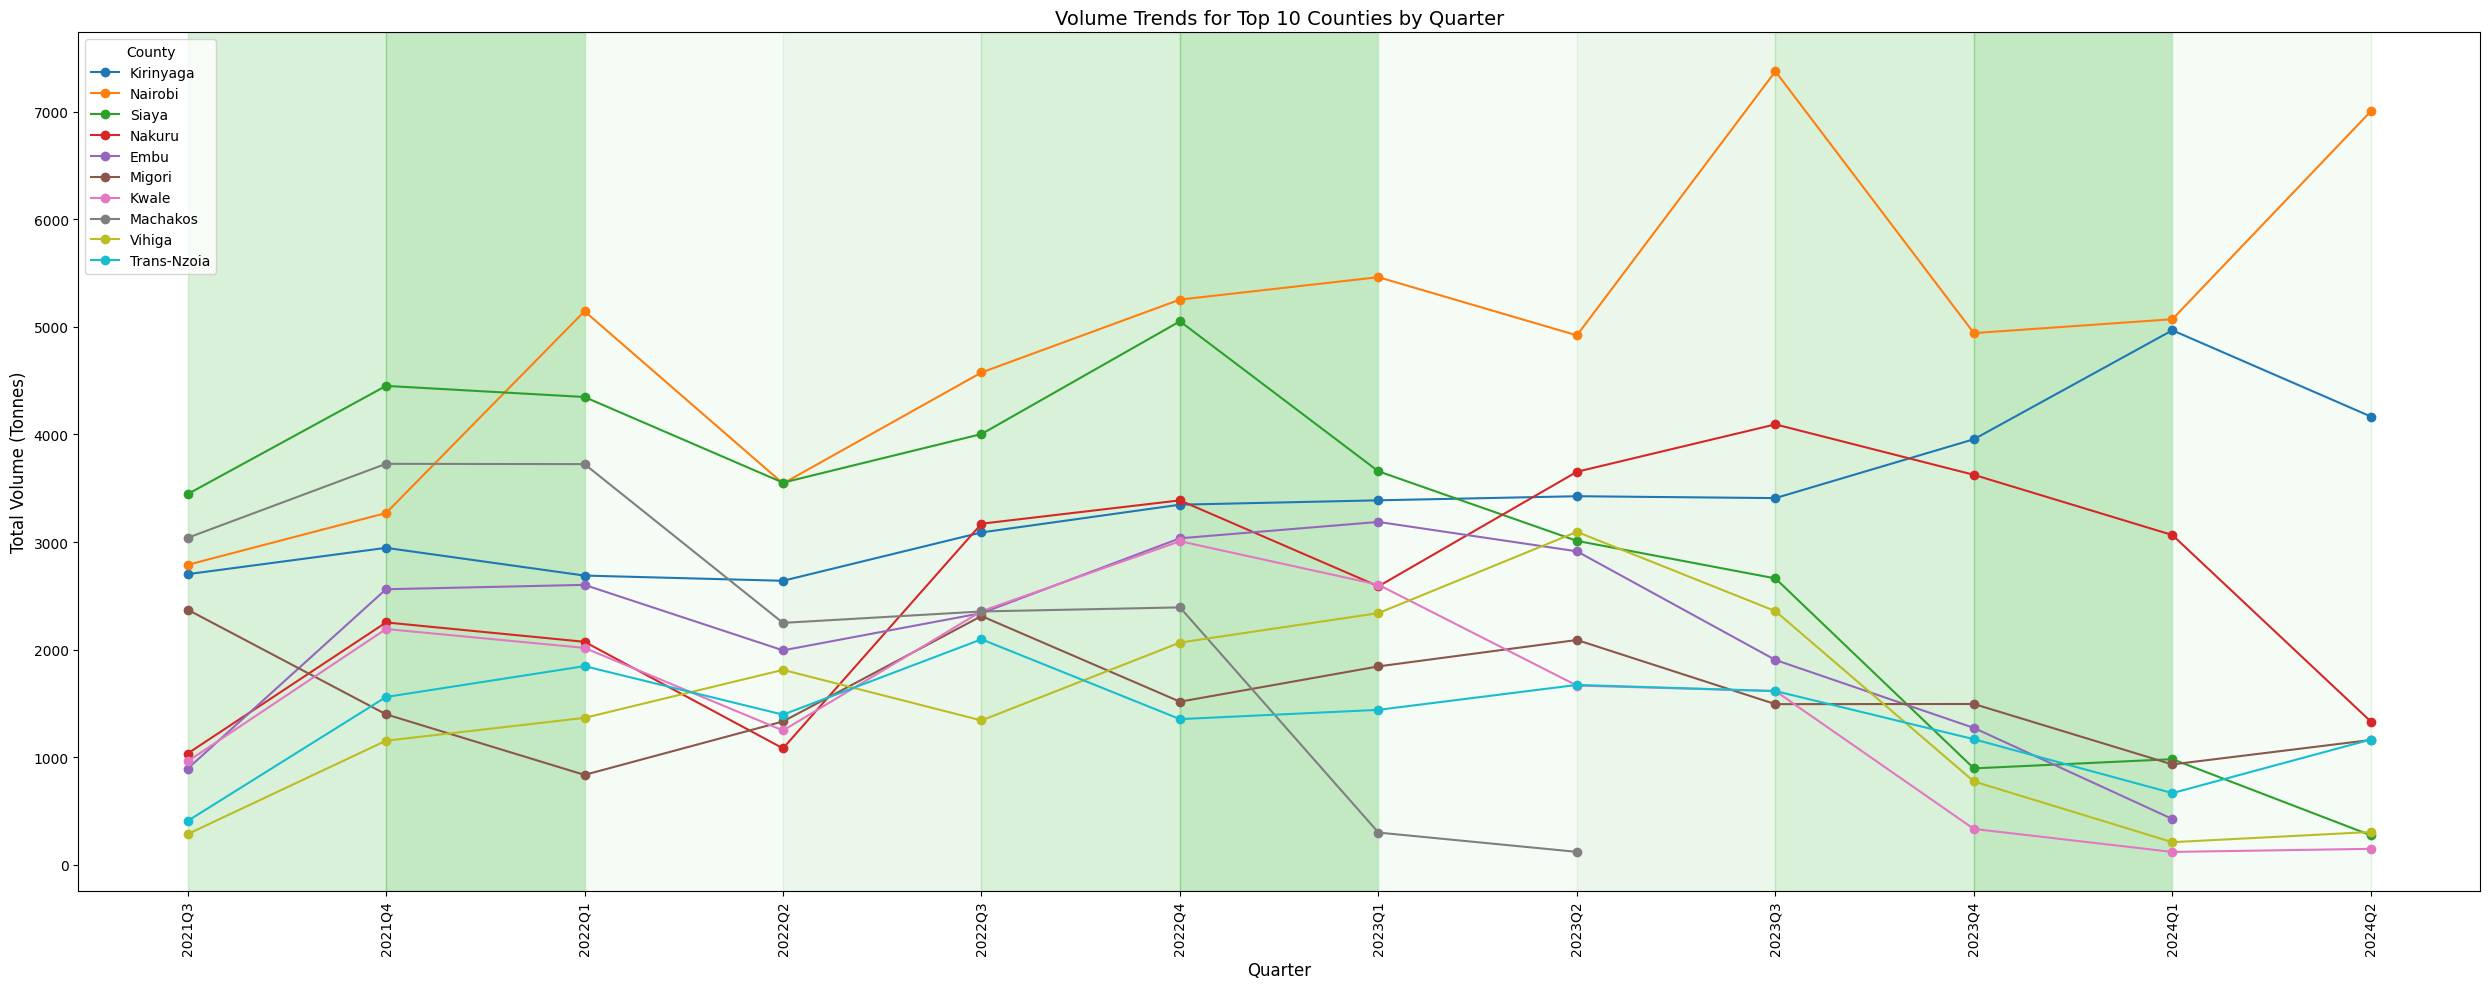

In [32]:
# Aggregate by county and quarter and calculate total volume for each quarter
county_volume_trends = aggregated_data.groupby(['quarter', 'county']).agg(
    total_volume_tonnes=('total_volume_tonnes', 'sum')
).reset_index()

# Define the quarters to use as labels on the x-axis
quarter_labels = sorted(county_volume_trends['quarter'].unique())

# Select the top 10 counties based on total volume
top_10_counties = aggregated_by_county.head(10)['county']

# Filter the data to include only the top counties
filtered_county_data = county_volume_trends[county_volume_trends['county'].isin(top_10_counties)]

# Create the plot
plt.figure(figsize=(25, 10))

# Plot each county's trend over time
for county in top_10_counties:
    county_data = filtered_county_data[filtered_county_data['county'] == county]
    plt.plot(county_data['quarter'], county_data['total_volume_tonnes'], marker='o', label=county)

# Define the color shades for Q1 to Q4 (light to dark green)
shading_colors = ['#e0f7e0', '#c1e7c1', '#83d183', '#39b739']  # Light to dark green

# Shade the background for each quarter with corresponding shades of green
for i, quarter in enumerate(quarter_labels):
    if "Q1" in quarter:
        color = shading_colors[0]  # Lightest green for Q1
    elif "Q2" in quarter:
        color = shading_colors[1]  # Slightly darker green for Q2
    elif "Q3" in quarter:
        color = shading_colors[2]  # Darker green for Q3
    elif "Q4" in quarter:
        color = shading_colors[3]  # Darkest green for Q4
    
    plt.axvspan(quarter, quarter_labels[i+1] if i+1 < len(quarter_labels) else quarter, 
                color=color, alpha=0.3)

# Set plot labels and title
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Total Volume (Tonnes)', fontsize=12)
plt.title('Volume Trends for Top 10 Counties by Quarter', fontsize=14)
plt.xticks(rotation=90)
plt.legend(title='County')
plt.tight_layout()
plt.show()

---

##### Findings for Smallholder Farmers:

a) Top Commodities: Commodities like White Irish Potatoes, Dry Maize, Watermelon, and Dry Onions have the highest aggregated volumes, signaling strong market demand.

b) Top Markets: Markets such as Nakuru Wakulima, Diani Market, and Aram are major hotspots, showing high aggregated sales volumes.

c) Top Counties: Kirinyaga, Nairobi, and Siaya lead in terms of volume, offering opportunities for farmers to supply these markets.

##### Insights for Smallholder Farmers:

a) Smallholder farmers should consider growing high-demand commodities like potatoes, maize, and onions, as they are heavily traded in high-volume markets and counties.

b) Counties with high demand but fewer suppliers (e.g., Embu, Kwale) could offer new market entry points for smallholder farmers.

##### Recommendations for Smallholder Farmers:

a) Diversify Production: Farmers should focus on high-demand crops like potatoes and maize, which also have good market penetration across multiple counties.

b) Target High-Volume Markets: Smallholder farmers should aim to supply to markets like Nakuru Wakulima and Diani, where demand for produce is substantial.

c) Leverage Market Gaps: Counties such as Migori and Embu show high demand with fewer established suppliers, offering growth opportunities for new farmers.

---

##### Findings for Market Linkage Players/Brokers:

a) Top Markets: Major market hubs such as Nakuru Wakulima and Kitale Municipality Market are critical for brokers to focus their efforts.

b) Top Counties: High-volume counties like Kirinyaga, Nairobi, and Nakuru are top targets for aggregating products from multiple smallholder farmers.

##### Insights for Market Linkage Players/Brokers:

a) Focusing on high-volume markets ensures a steady supply of produce, improving brokers' ability to aggregate and deliver large volumes.

b) Some counties like Siaya and Migori are emerging with higher demand, which could offer new areas for market linkage players to operate in.

##### Recommendations for Market Linkage Players/Brokers:

a) Strategic Market Focus: Brokers should prioritize markets with the highest sales activity, such as Nakuru Wakulima and Eldoret Main, to aggregate commodities in bulk.

b) County-Level Collaboration: Market linkage players should consider working with farmers in counties like Siaya and Kwale to supply growing markets and meet the increasing demand.

c) Leverage Emerging Markets: New markets with moderate but growing demand (e.g., Embu and Machakos) present an opportunity for brokers to establish a foothold early.

---

##### Findings for Retailers:

a) Commodity Profitability: Commodities like potatoes, dry maize, and watermelon not only have high volumes but also display good profit margins between wholesale and retail prices.

b) Top Markets for Retail: Nairobi's markets such as Kangemi Market and Nyamakima are showing strong aggregated volumes, making them profitable spots for retailers to focus on.

##### Insights for Retailers:

a) Retailers should stock high-demand, high-margin commodities to maximize profitability while also ensuring consistent supply from top markets.

b) Retailers operating in counties with growing market activity (like Migori and Vihiga) could capitalize on unmet demand.

##### Recommendations for Retailers:

a) Stock High-Demand Commodities: Retailers should prioritize sourcing commodities like potatoes and maize that have high sales volumes and good profit potential.

b) Focus on Profitable Markets: High-volume markets, particularly in counties like Kirinyaga and Nairobi, should be the focus areas for expanding retail operations.

c) Regional Diversification: Retailers should also consider setting up operations in emerging markets in counties like Embu and Machakos, where demand is growing.

---

In [33]:
# Step 3: Most Profitable Commodities with Average Wholesale and Retail Prices

# Ensure the wholesale and retail price columns are converted to numeric values
aggregated_data['avg_retail_price'] = pd.to_numeric(aggregated_data['avg_retail_price'], errors='coerce')
aggregated_data['avg_wholesale_price'] = pd.to_numeric(aggregated_data['avg_wholesale_price'], errors='coerce')

# Calculate resell margin and percentage profit
aggregated_data['resell_margin'] = aggregated_data['avg_retail_price'] - aggregated_data['avg_wholesale_price']
aggregated_data['percentage_profit'] = (aggregated_data['resell_margin'] / aggregated_data['avg_wholesale_price']) * 100

# Group by commodity and calculate average resell margin, percentage profit, and prices
profitable_commodities = aggregated_data.groupby('commodity').agg(
    avg_wholesale_price=('avg_wholesale_price', 'mean'),
    avg_retail_price=('avg_retail_price', 'mean'),
    avg_resell_margin=('resell_margin', 'mean'),
    avg_percentage_profit=('percentage_profit', 'mean')
).reset_index()

# Sort by percentage profit in descending order to find the most profitable commodities
most_profitable_commodities = profitable_commodities.sort_values(by='avg_percentage_profit', ascending=False)

# Display the most profitable commodities
most_profitable_commodities

commodity  avg_wholesale_price  avg_retail_price  \
34                        Maize Flour            42.696960         93.196374   
33                            Lettuce            49.953711         91.861076   
30               Jute Plant (Murenda)            55.011564         99.167991   
37                         Njugu Mawe           128.698870        208.671299   
49                        Thorn melon            40.553965         69.974178   
36              Nderema- Vine Spinach            41.774393         69.894357   
31                  Kales/Sukuma Wiki            26.401042         44.684663   
45               Spider flower (Saga)            54.456052         88.136921   
6    Black nightshade (Managu/ Osuga)            44.314183         71.977573   
46                            Spinach            33.367092         53.498065   
39                             Pawpaw            46.220929         73.187450   
20               Egg plant (Brinjals)            46.364544         72.829735   
27                        Green Maize            43.539532         67.112490   
12                 Coriander (Dhania)            72.132552        111.310513   
0                 Amaranthus (Terere)            34.639787         53.819301   
11                           Chillies            80.569399        122.801859   
42                     Pumpkin Leaves            42.289212         63.304570   
32                            Lentils           172.215971        245.880723   
16                           Cucumber            60.335430         88.353170   
29  Indigenous Crotolaria (Mito/Miro)            57.001804         83.734992   
7                            Broccoli            80.133952        120.384081   
50                        Water Melon            36.519980         54.928880   
21          Ethiopian Kales - Kanzira            53.869970         79.675851   
13                          Courgette            64.993035         95.402372   
10                        Cauliflower            93.874643        139.646951   
41                            Pumpkin            53.575418         78.231864   
8                          Butternuts            55.970535         81.436255   
14              Cowpea leaves (Kunde)            38.324179         55.578875   
53               White Irish Potatoes            43.080564         61.943979   
47                      Spring Onions            51.560874         74.837847   
38     Okra (Lady's fingers or Gumbo)            94.082960        137.300240   
9                 Cassava Chips (dry)            56.372149         79.910076   
18                         Dry Onions            64.716901         92.880077   
25                             Ginger           125.832684        174.333786   
51                              Wheat            62.010122         87.123505   
1                          Arrow Root            84.286150        120.706095   
48                Tangerine (Sandara)            59.612178         84.574232   
22                       French beans            63.375939         87.520250   
23                         Fresh Peas            80.364808        112.419256   
54                                Yam            83.786817        116.702862   
15                            Cowpeas            94.692649        128.037849   
40                        Pigeon peas           104.389299        137.739270   
28                        Ground Nuts           166.238150        214.058258   
43                        Red Sorghum            60.445137         79.533074   
26                        Green Grams           110.445411        143.215661   
5              Beans Rosecoco (Nyayo)           106.287429        135.925007   
17                          Dry Maize            49.815616         63.533612   
24                             Garlic           319.595319        401.028543   
19                           Dry Peas           130.037913        166.184848   
4         Beans Red Haricot 

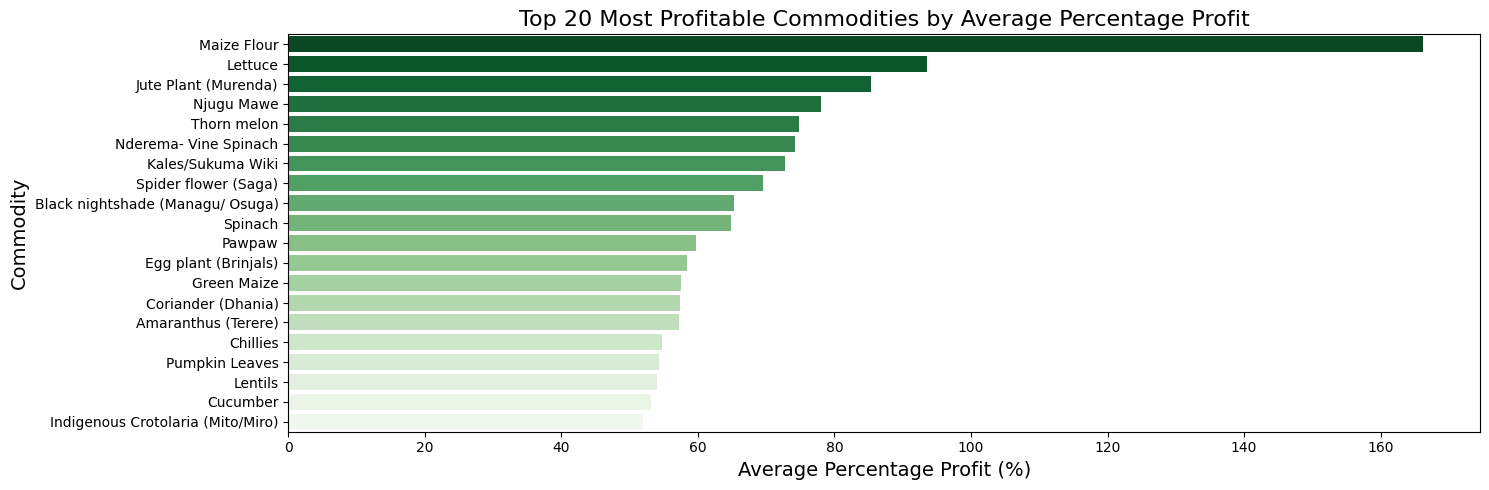

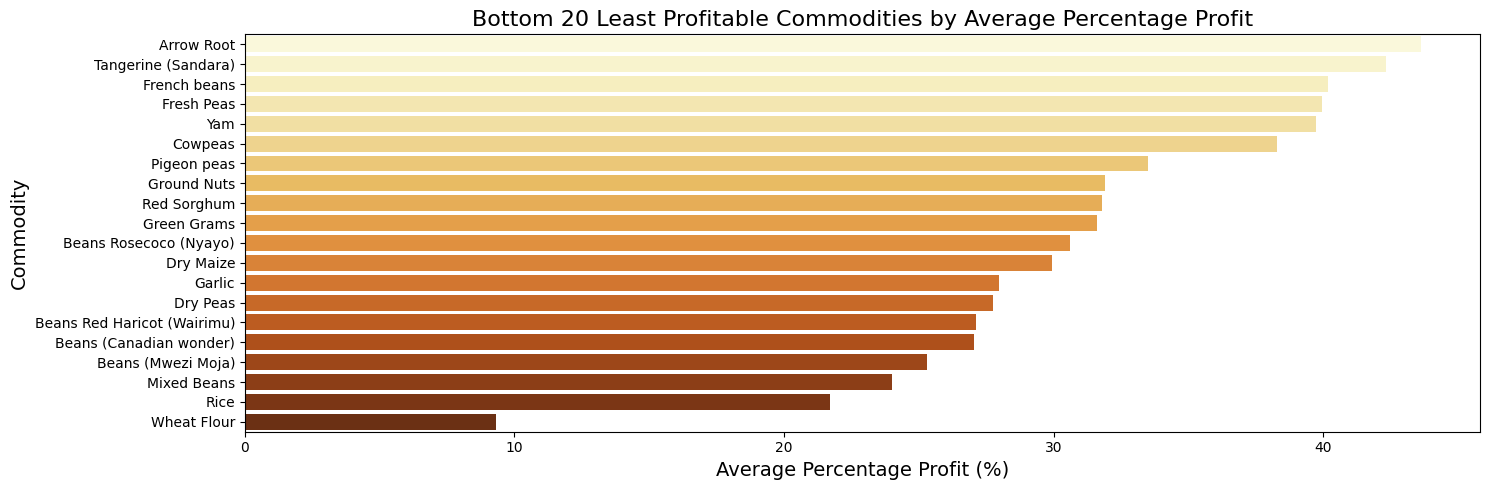

In [34]:
# Select the top 20 most profitable commodities by percentage profit
top_20_profitable = most_profitable_commodities.head(20)

# Select the bottom 20 most profitable commodities by percentage profit
bottom_20_profitable = most_profitable_commodities.tail(20)

# Plotting top 20 most profitable commodities with a smooth green gradient
plt.figure(figsize=(15, 5))
sns.barplot(data=top_20_profitable, x='avg_percentage_profit', y='commodity', palette='Greens_r')
plt.title('Top 20 Most Profitable Commodities by Average Percentage Profit', fontsize=16)
plt.xlabel('Average Percentage Profit (%)', fontsize=14)
plt.ylabel('Commodity', fontsize=14)
plt.tight_layout()
plt.show()

# Plotting bottom 20 least profitable commodities with a smooth mustard gradient
plt.figure(figsize=(15, 5))
sns.barplot(data=bottom_20_profitable, x='avg_percentage_profit', y='commodity', palette='YlOrBr')
plt.title('Bottom 20 Least Profitable Commodities by Average Percentage Profit', fontsize=16)
plt.xlabel('Average Percentage Profit (%)', fontsize=14)
plt.ylabel('Commodity', fontsize=14)
plt.tight_layout()
plt.show()

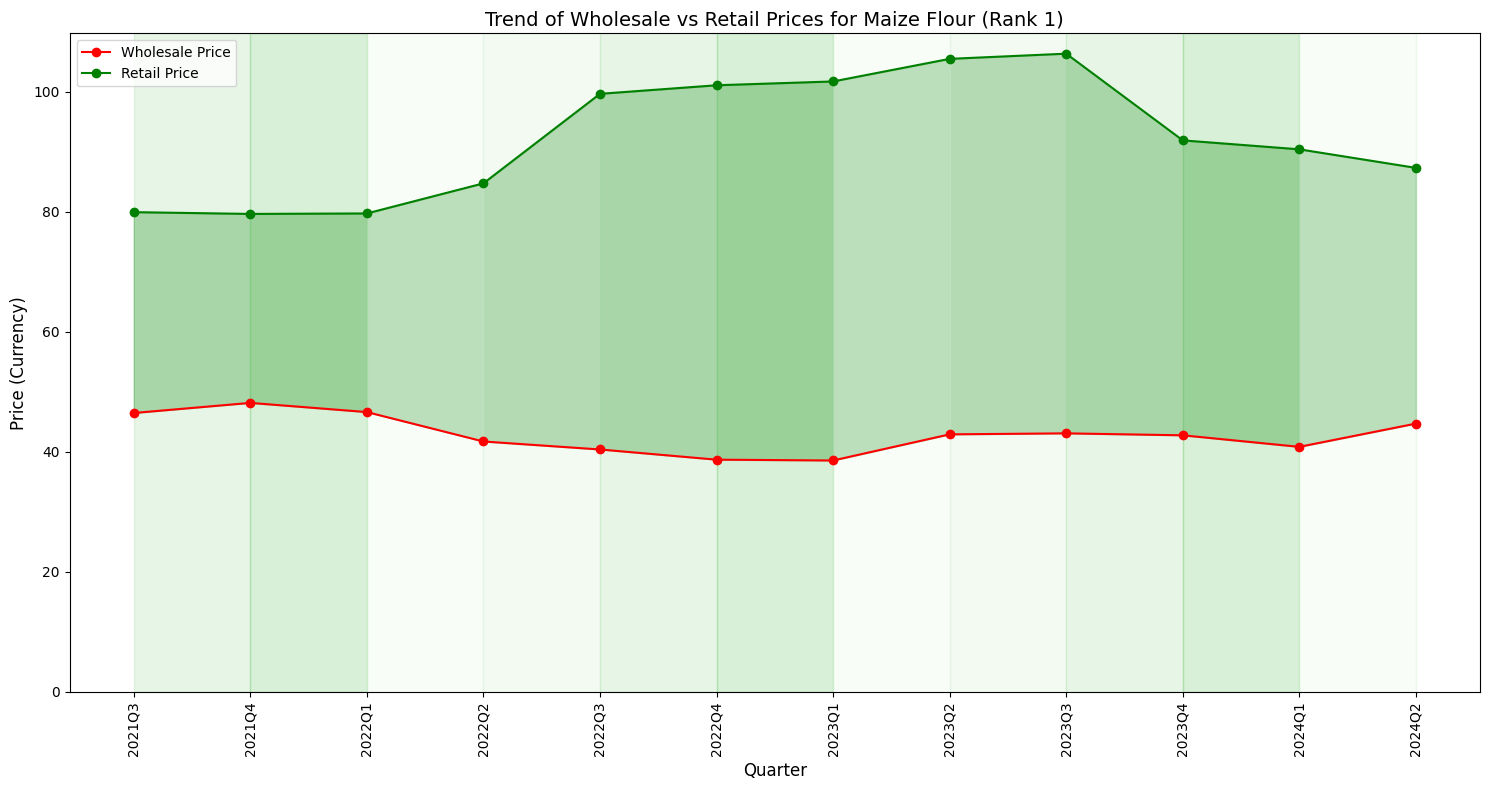

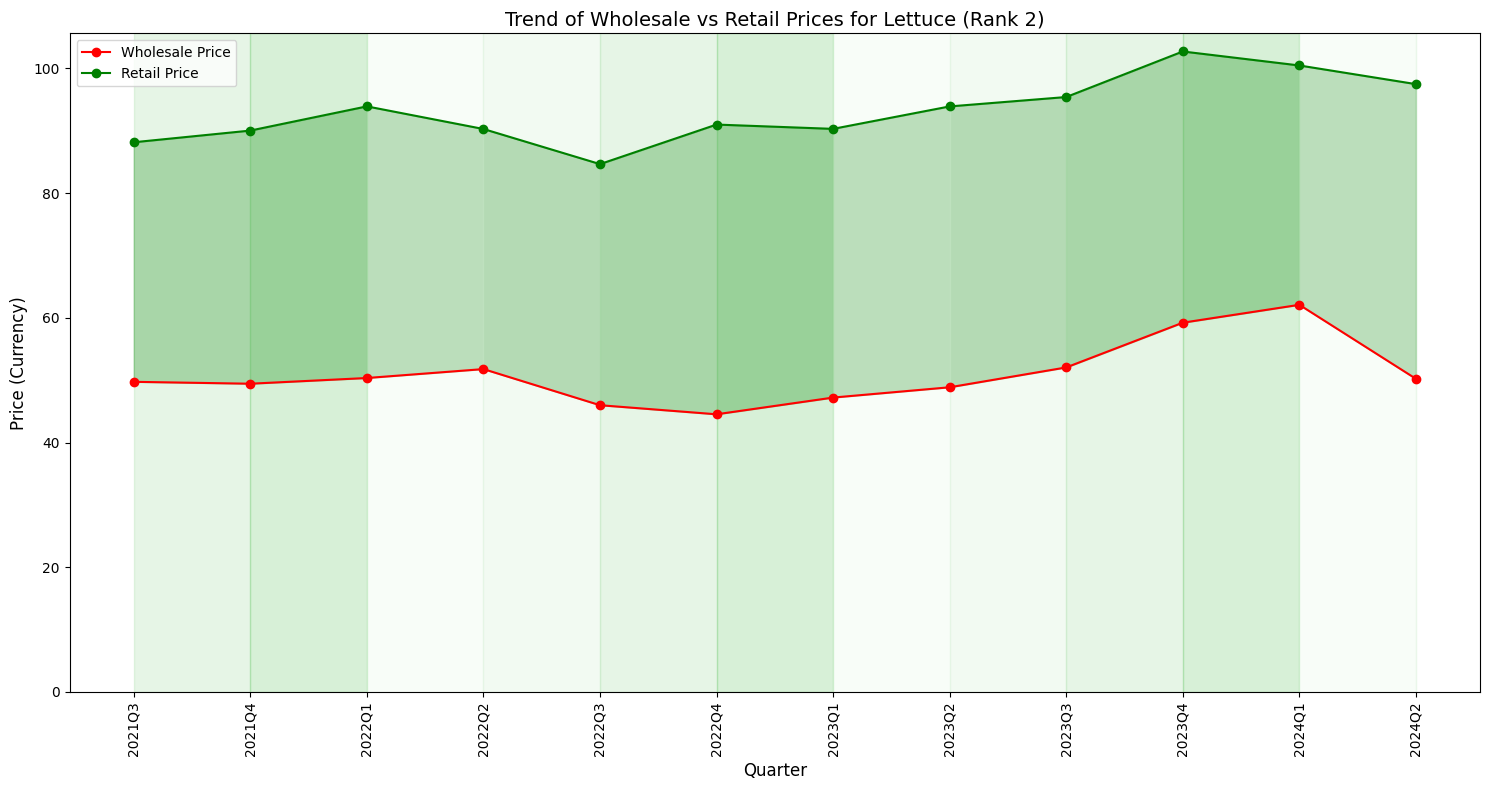

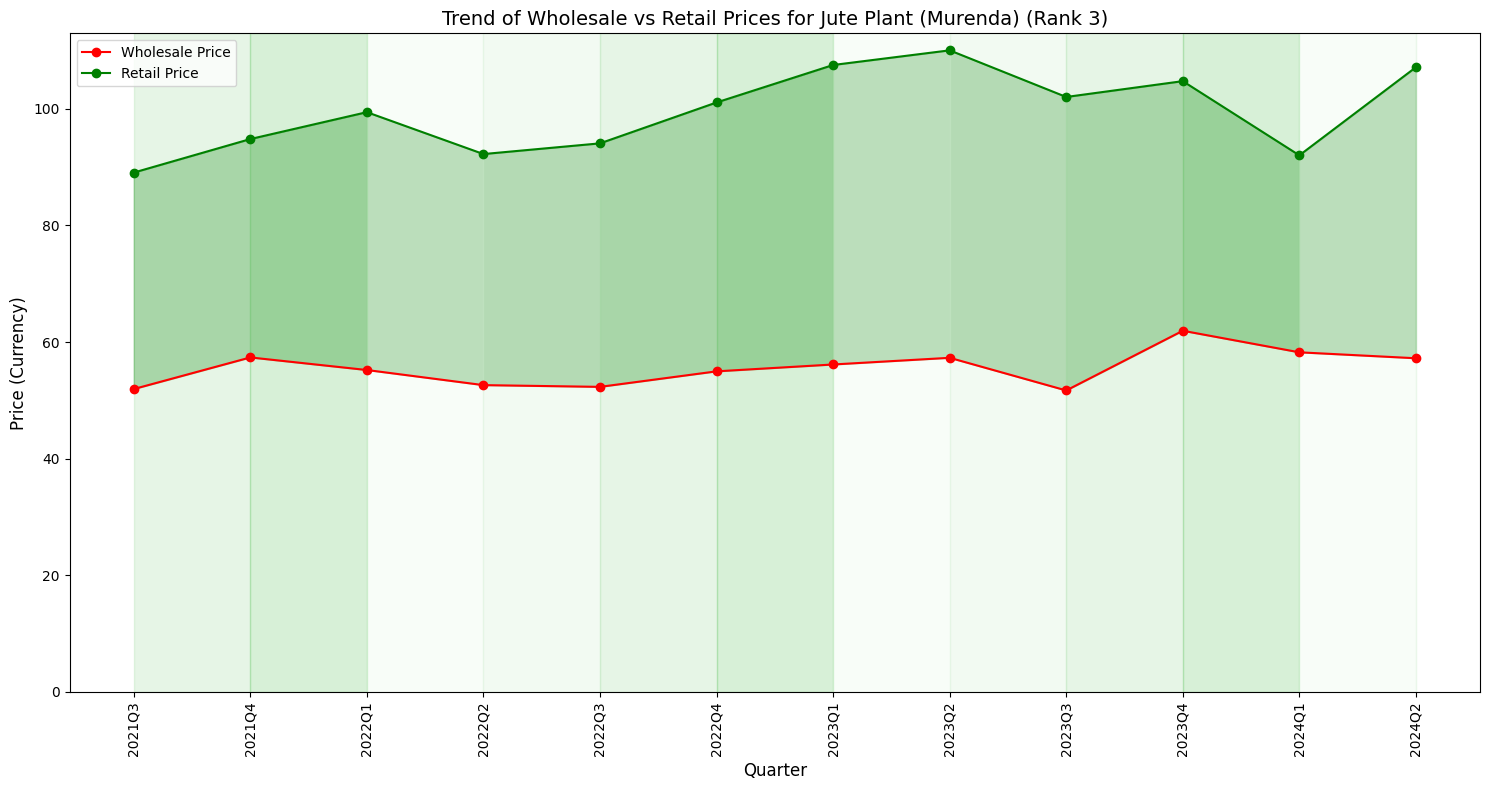

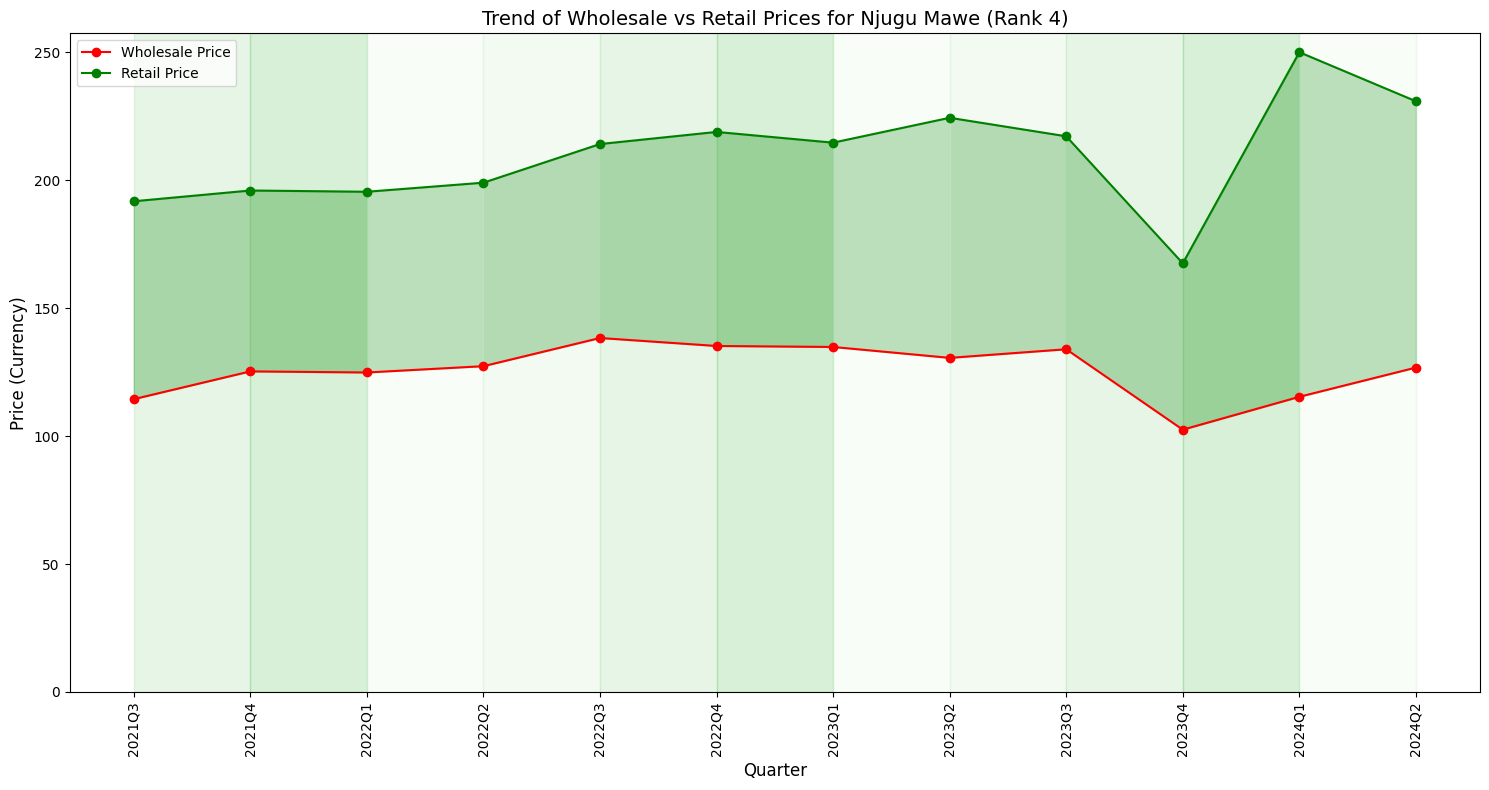

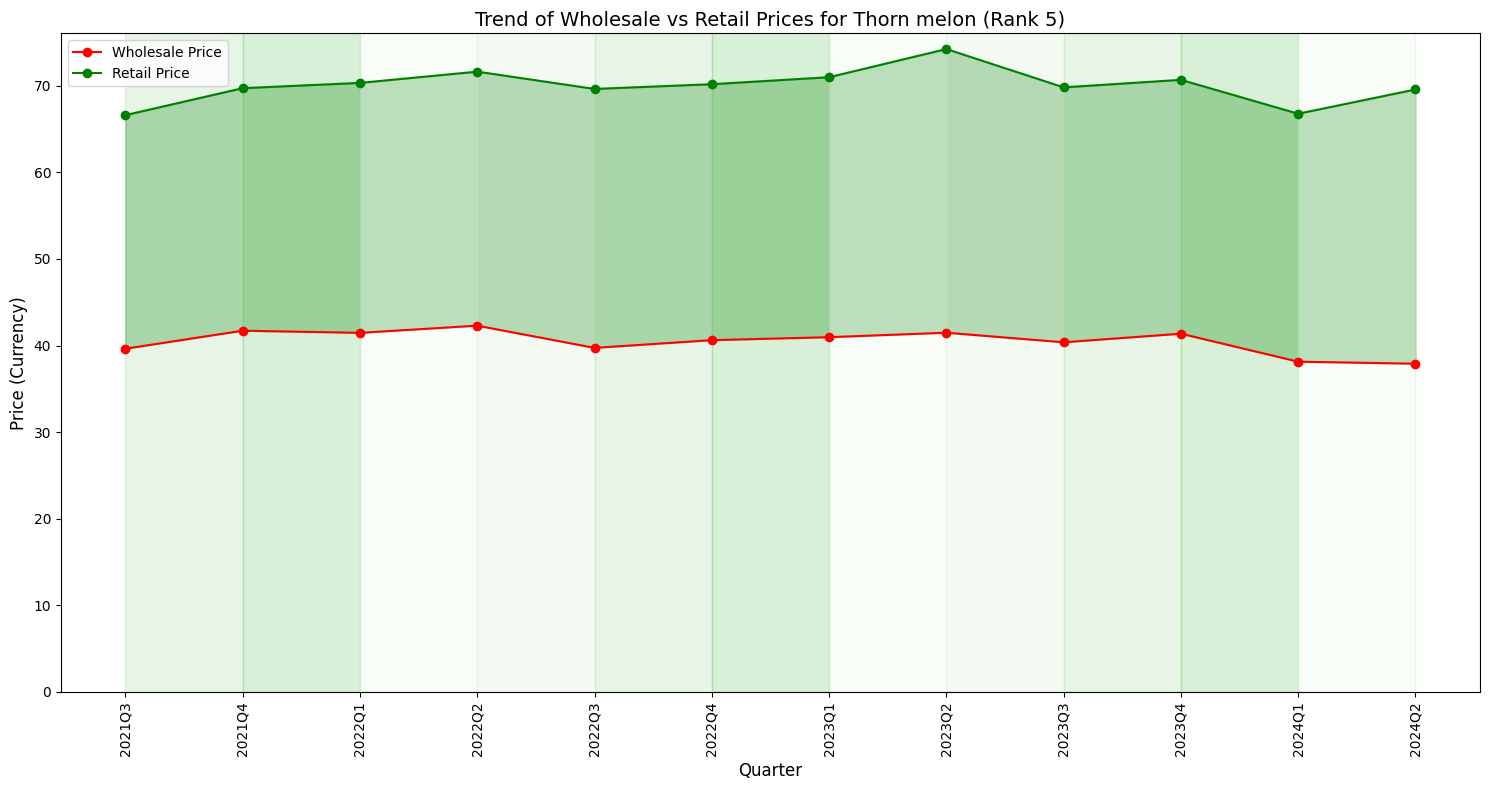

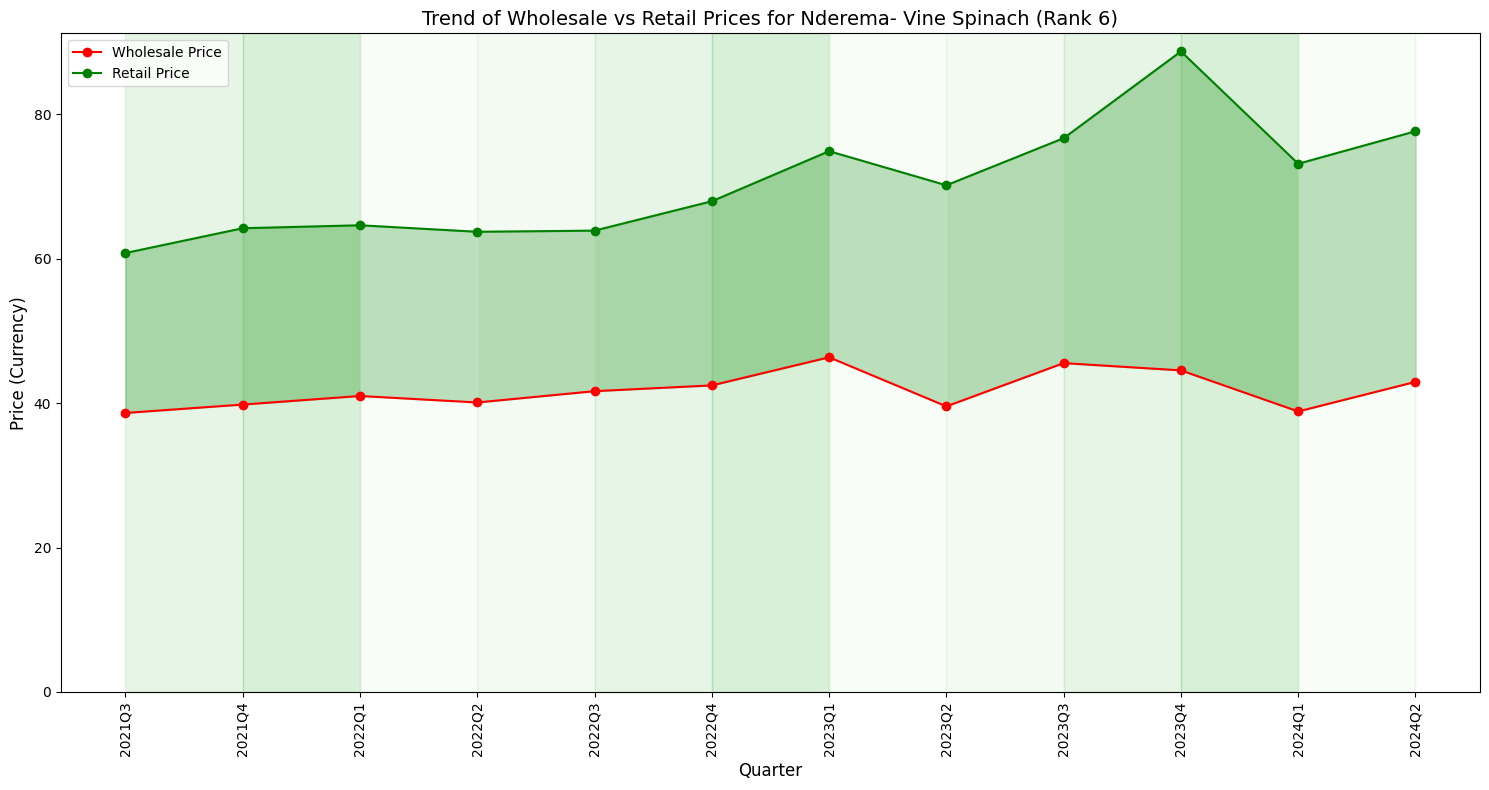

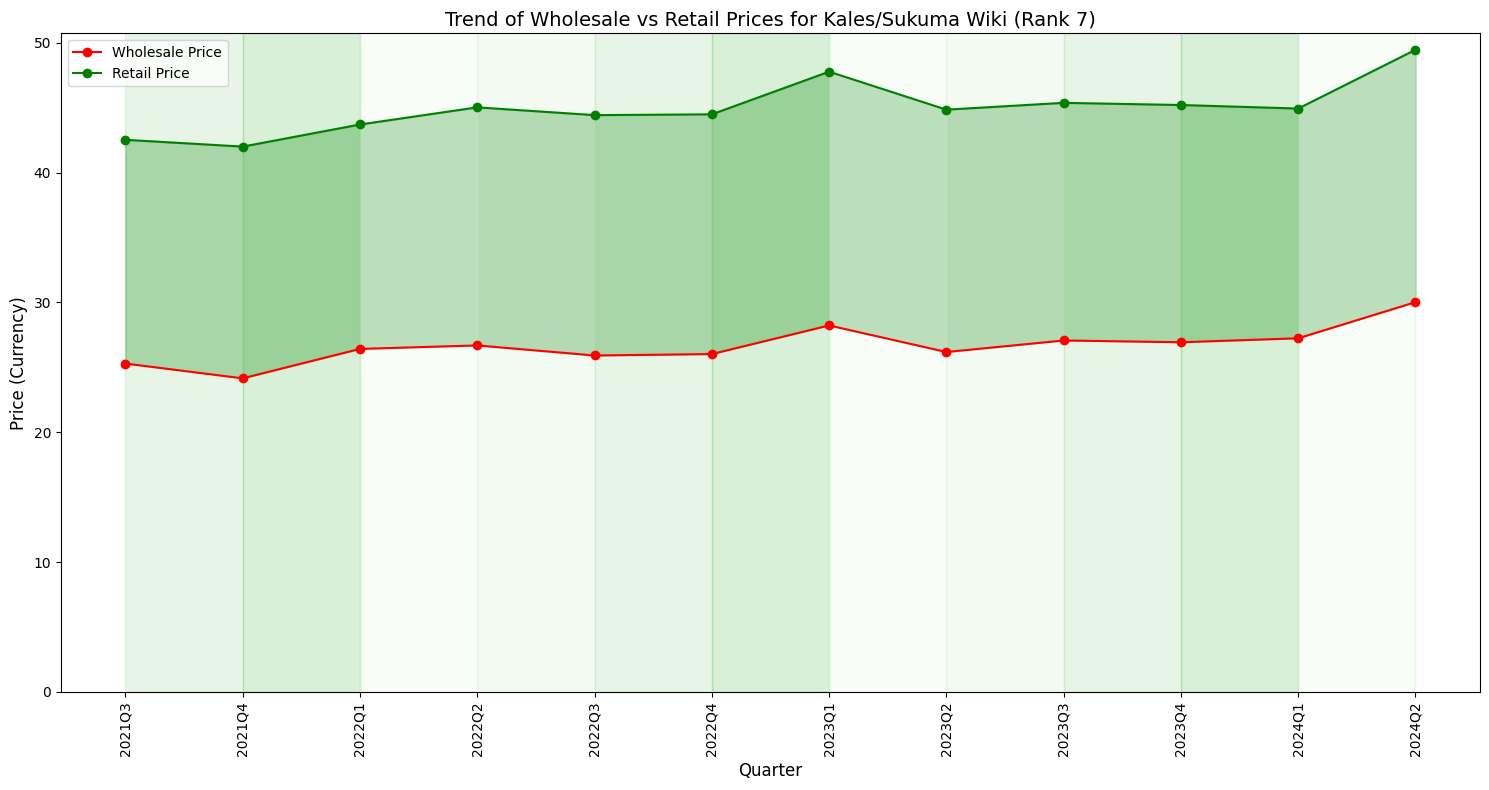

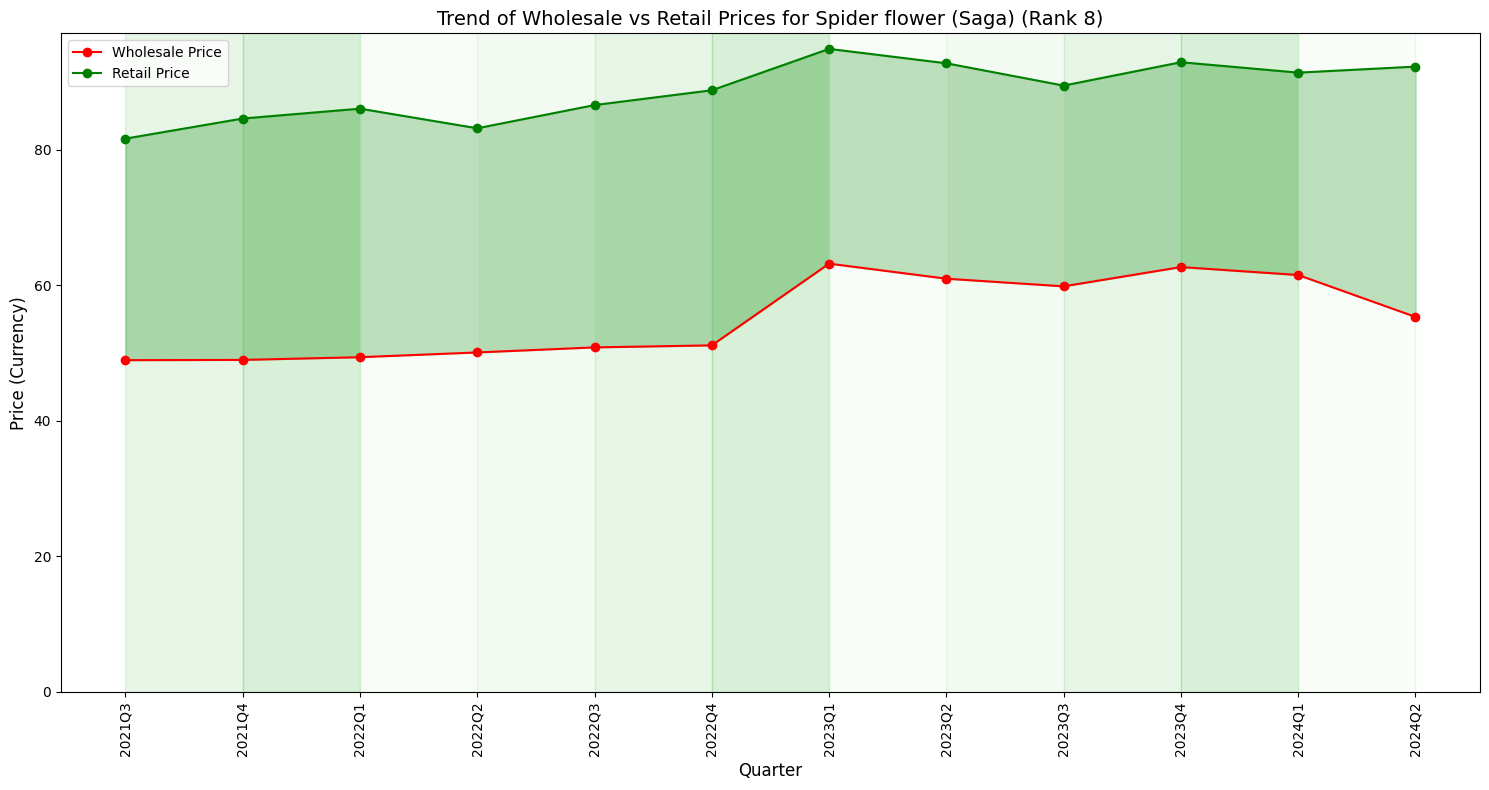

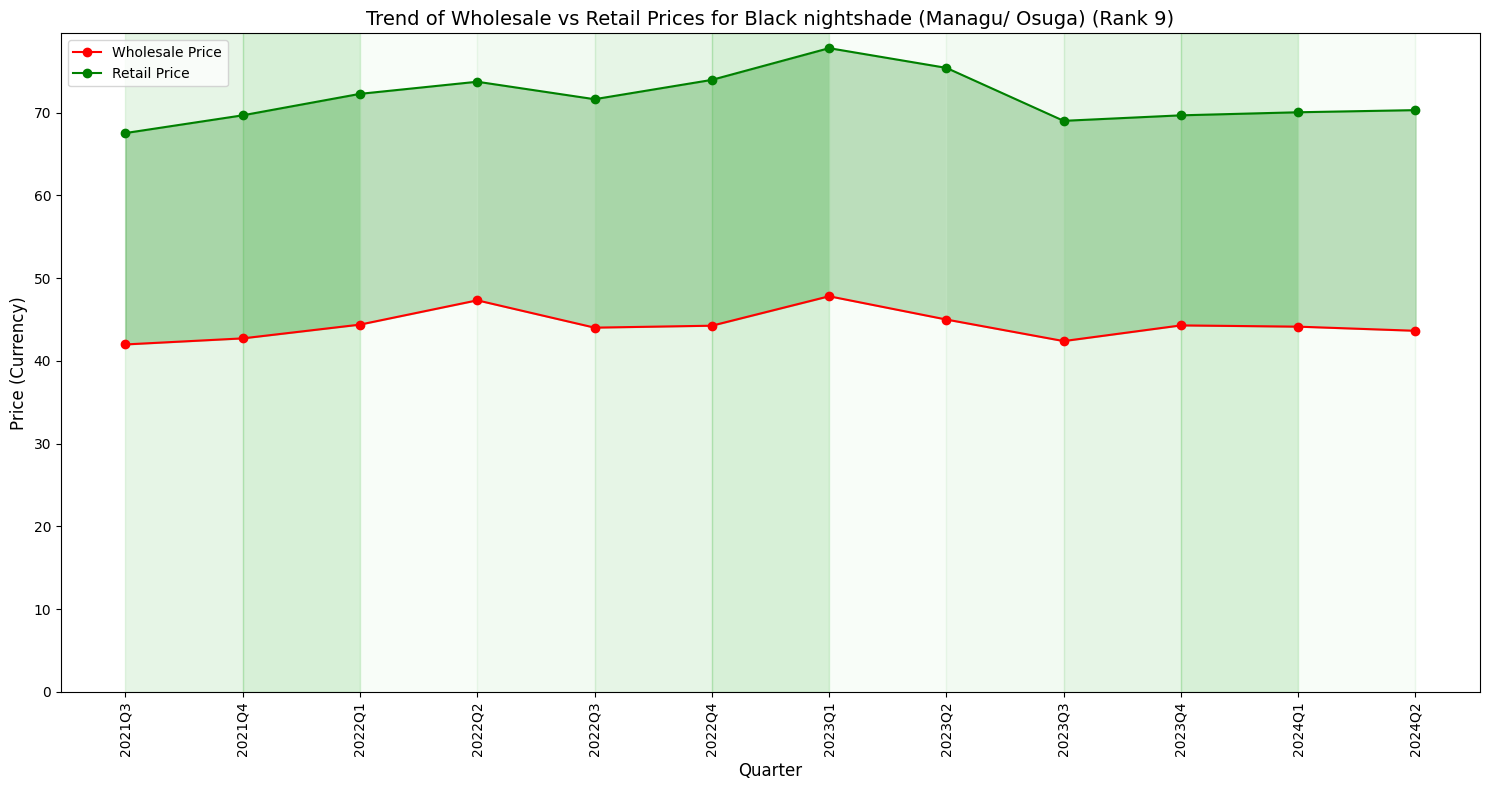

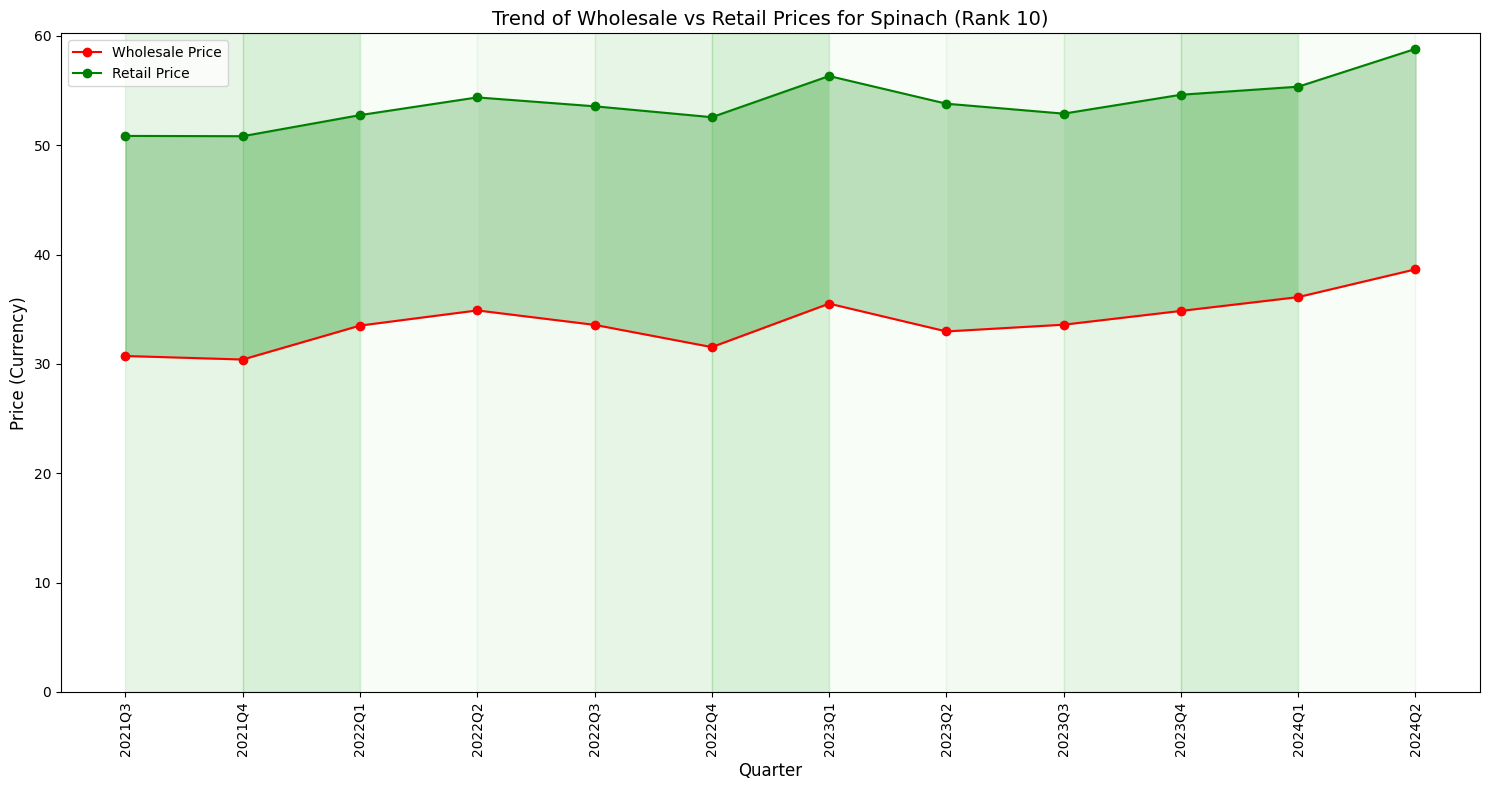

In [36]:
# Loop through the top 10 commodities and create a plot for each
for i, commodity in enumerate(top_10_commodities, 1):  # i is the rank (starting from 1)
    plt.figure(figsize=(15, 8))
    
    # Filter data for the current commodity
    commodity_data = filtered_price_data[filtered_price_data['commodity'] == commodity]
    
    # Plot wholesale and retail prices
    plt.plot(commodity_data['quarter'], commodity_data['avg_wholesale_price'], color='red', marker='o', label='Wholesale Price')
    plt.plot(commodity_data['quarter'], commodity_data['avg_retail_price'], color='green', marker='o', label='Retail Price')
    
    # Shade the area between wholesale and retail prices in green
    plt.fill_between(commodity_data['quarter'], commodity_data['avg_wholesale_price'], commodity_data['avg_retail_price'], 
                     where=(commodity_data['avg_retail_price'] > commodity_data['avg_wholesale_price']), color='green', alpha=0.3)
    
    # Shade the background for each quarter with corresponding shades of green
    for j, quarter in enumerate(quarter_labels):
        if "Q1" in quarter:
            color = shading_colors[0]  # Lightest green for Q1
        elif "Q2" in quarter:
            color = shading_colors[1]  # Slightly darker green for Q2
        elif "Q3" in quarter:
            color = shading_colors[2]  # Darker green for Q3
        elif "Q4" in quarter:
            color = shading_colors[3]  # Darkest green for Q4
        
        plt.axvspan(quarter, quarter_labels[j+1] if j+1 < len(quarter_labels) else quarter, 
                    color=color, alpha=0.2)
    
    # Set plot labels, title, and legend
    plt.xlabel('Quarter', fontsize=12)
    plt.ylabel('Price (Currency)', fontsize=12)
    plt.title(f'Trend of Wholesale vs Retail Prices for {commodity} (Rank {i})', fontsize=14)
    plt.xticks(rotation=90)
    plt.legend()
    
    # Ensure y-axis starts from 0
    plt.ylim(0, )  
    
    plt.tight_layout()
    plt.show()

I want to also see which are the most and least preferred commodity option based on volumes and profit.

Ranking and Cross-Filtering: I will rank commodities by both volume and profit margin and compare their rankings, then list the commodity scores (combined_score, the lower the figure, the better the rank).

In [37]:
# Step 1: Rank commodities by total volume
popular_commodities['volume_rank'] = popular_commodities['total_volume_tonnes'].rank(ascending=False)

# Step 2: Rank commodities by average percentage profit
most_profitable_commodities['profit_rank'] = most_profitable_commodities['avg_percentage_profit'].rank(ascending=False)

# Step 3: Merge both rankings into a single dataframe
ranked_commodities = pd.merge(popular_commodities, most_profitable_commodities, on='commodity')

# Step 4: Calculate combined rank score (lower is better)
ranked_commodities['combined_score'] = (ranked_commodities['volume_rank'] + ranked_commodities['profit_rank']) / 2

# Step 5: Sort by combined score
ranked_commodities = ranked_commodities.sort_values(by='combined_score')

# Display the results
print("Commodity ranking based on volumes and good profit margins:")
ranked_commodities

Commodity ranking based on volumes and good profit margins:


commodity  total_volume_tonnes  volume_rank  \
7                         Maize Flour             17000.03          8.0   
8                   Kales/Sukuma Wiki             15976.52          9.0   
11                        Green Maize             10674.73         12.0   
14                            Spinach              8464.56         15.0   
2                         Water Melon             36112.21          3.0   
0                White Irish Potatoes             84558.12          1.0   
22   Black nightshade (Managu/ Osuga)              3896.78         23.0   
16                            Lentils              6535.67         17.0   
3                          Dry Onions             35551.68          4.0   
24                Amaranthus (Terere)              3494.52         25.0   
28                             Pawpaw              2827.09         29.0   
13                      Spring Onions              8899.79         14.0   
9                               Wheat             13112.77         10.0   
43                            Lettuce              1001.14         44.0   
31                 Coriander (Dhania)              2482.76         32.0   
41                        Thorn melon              1172.66         42.0   
38               Spider flower (Saga)              1602.10         39.0   
34               Egg plant (Brinjals)              2147.25         35.0   
1                           Dry Maize             79472.61          2.0   
5                         Green Grams             22466.22          6.0   
47               Jute Plant (Murenda)               726.59         48.0   
26                            Pumpkin              2939.67         27.0   
33                           Cucumber              2285.39         34.0   
49                         Njugu Mawe               566.58         50.0   
27                         Butternuts              2898.07         28.0   
10             Beans Rosecoco (Nyayo)             10966.10         11.0   
20                         Arrow Root              5148.83         21.0   
40                           Chillies              1468.70         41.0   
29              Cowpea leaves (Kunde)              2525.62         30.0   
15                        Ground Nuts              7668.13         16.0   
4                         Wheat Flour             23175.57          5.0   
18                            Cowpeas              5597.21         19.0   
54              Nderema- Vine Spinach               210.04         55.0   
36                          Courgette              1960.09         37.0   
6                                Rice             20350.37          7.0   
17                        Red Sorghum              6097.52         18.0   
44                     Pumpkin Leaves               876.58         45.0   
23                         Fresh Peas              3674.30         24.0   
30                Cassava Chips (dry)              2499.85         31.0   
12        Beans Red Haricot (Wairimu)              9401.82         13.0   
21                        Pigeon peas              4335.07         22.0   
46  Indigenous Crotolaria (Mito/Miro)               778.24         47.0   
48                           Broccoli               590.17         49.0   
37                             Ginger              1627.91         38.0   
19                 Beans (Mwezi Moja)              5283.72         20.0   
35                Tangerine (Sandara)              2074.22         36.0   
51          Ethiopian Kales - Kanzira               406.28         52.0   
52                        Cauliflower               289.41         53.0   
25                        Mixed Beans              3131.98         26.0   
32            Beans (Canadian wonder)              2463.13         33.0   
45                       French beans               791.87         46.0   
53     Okra (Lady's fingers or Gumbo)               249.58         54.0   
39                             Garlic              14

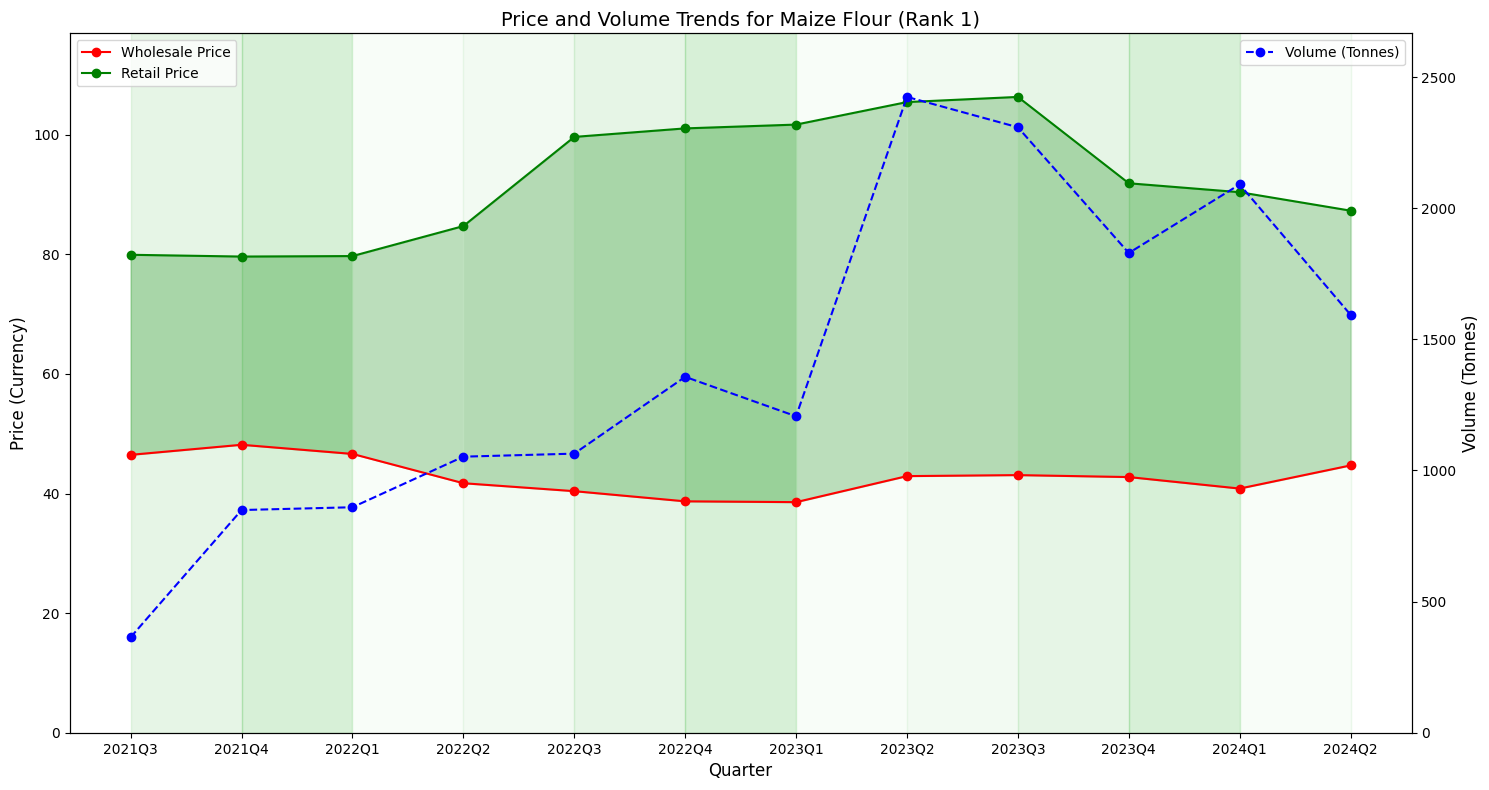

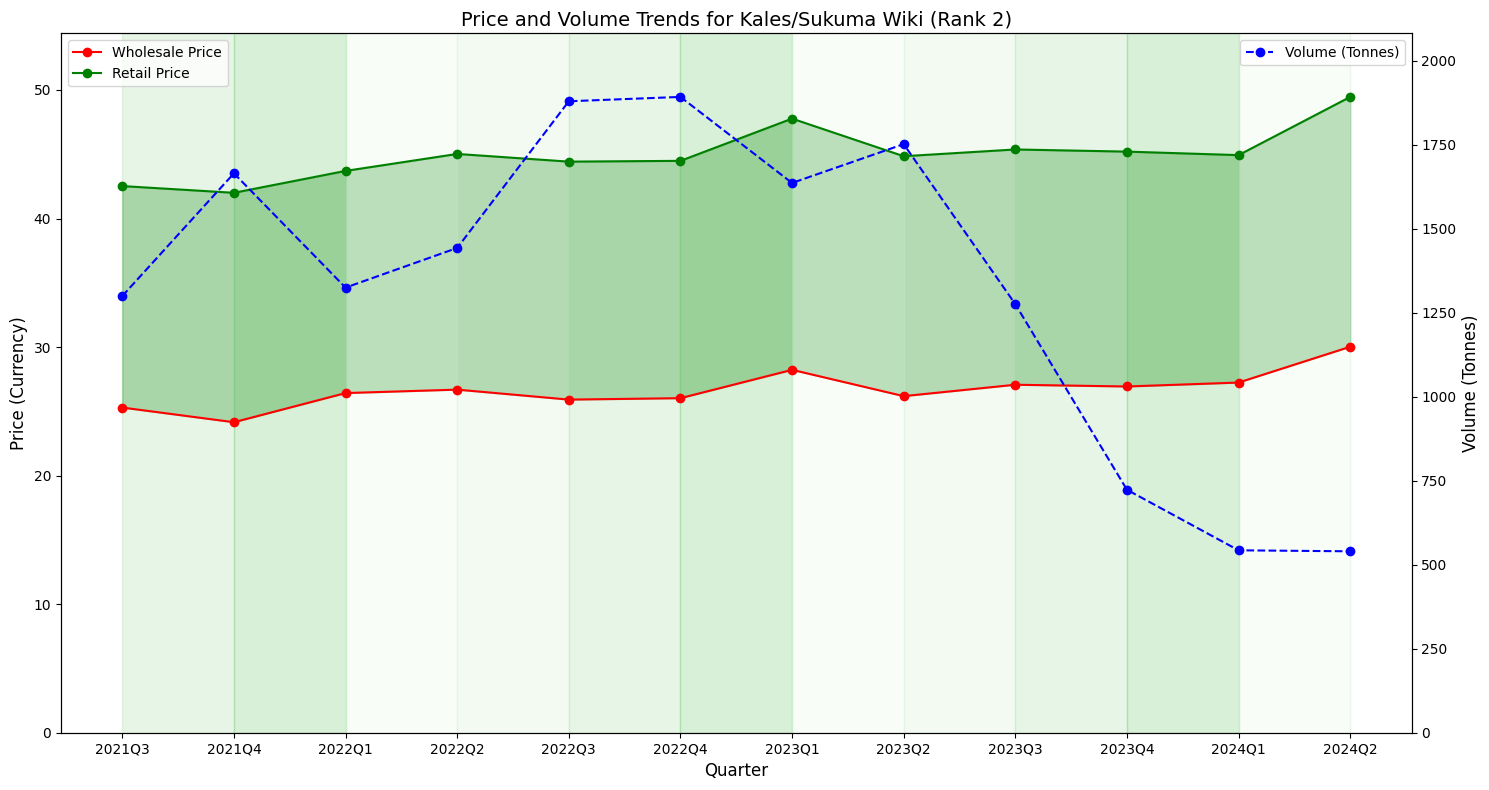

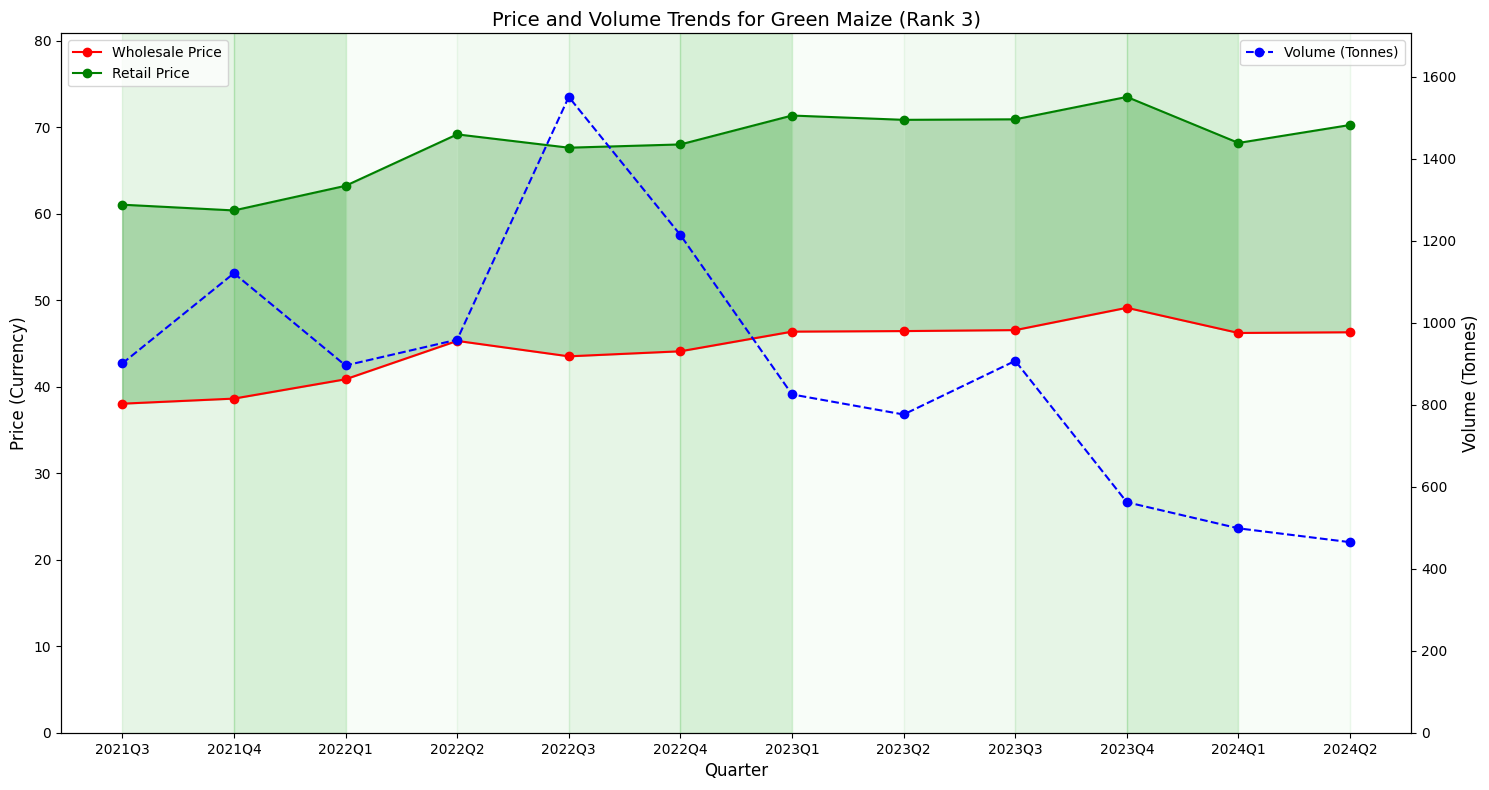

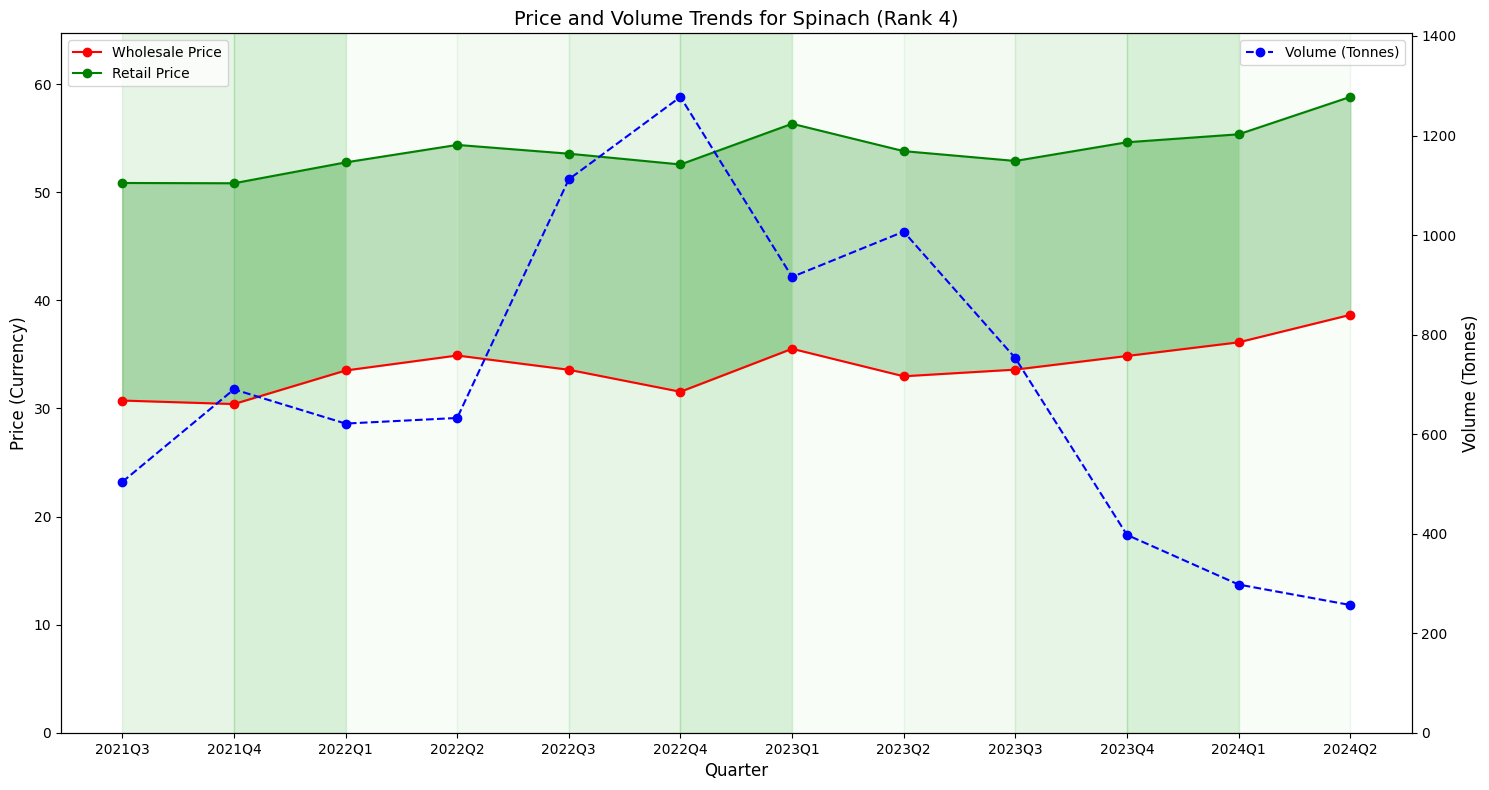

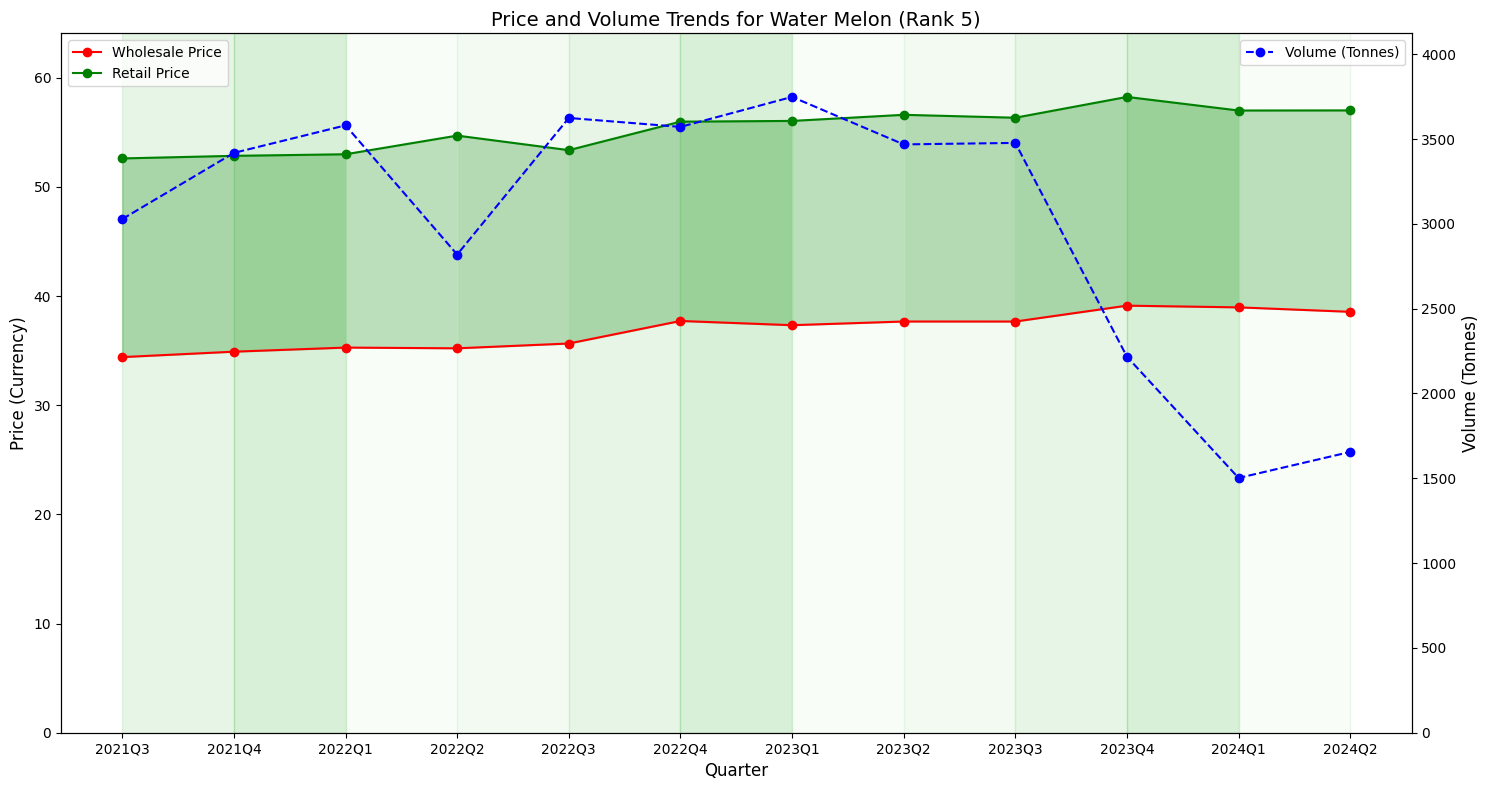

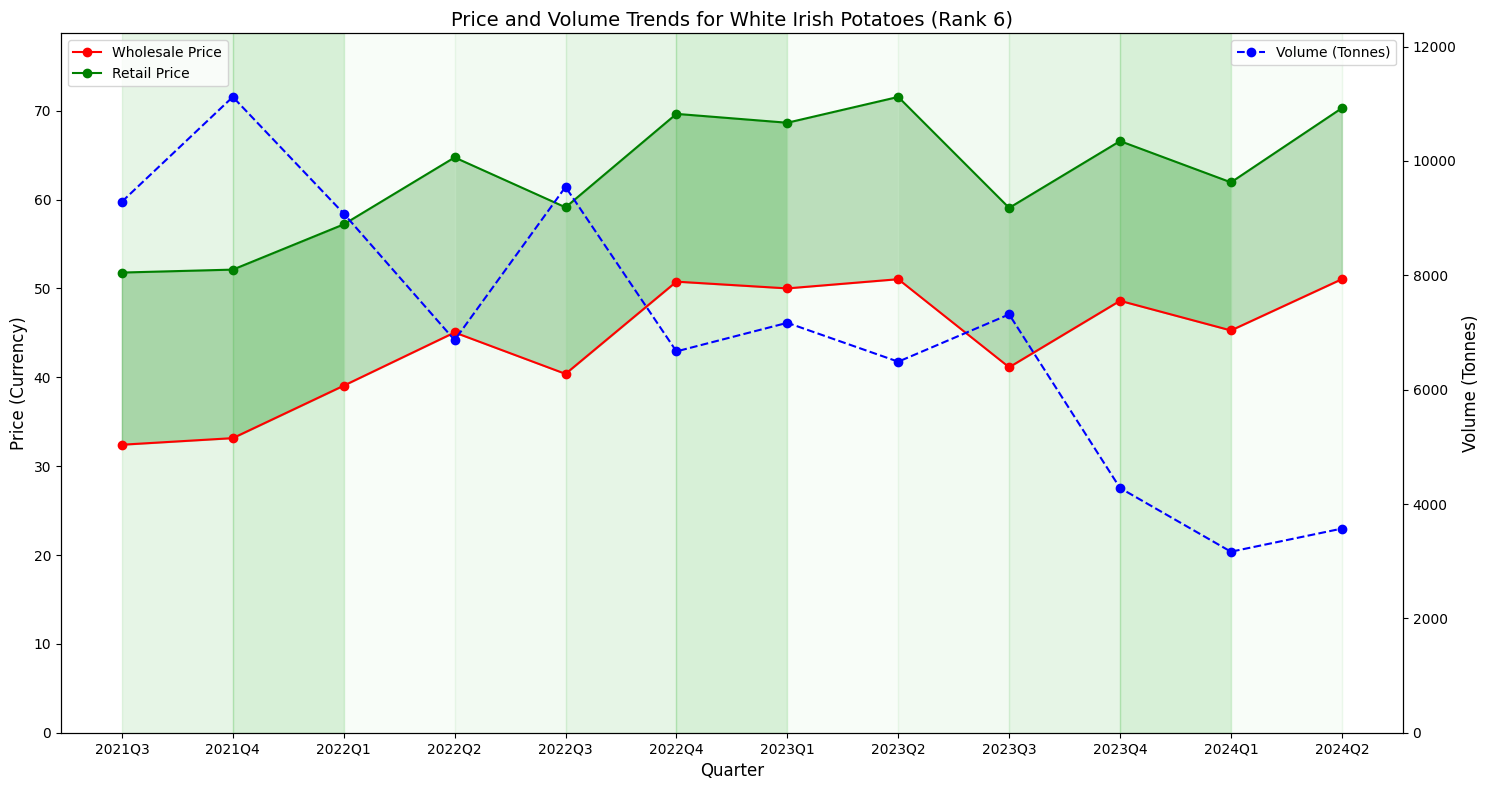

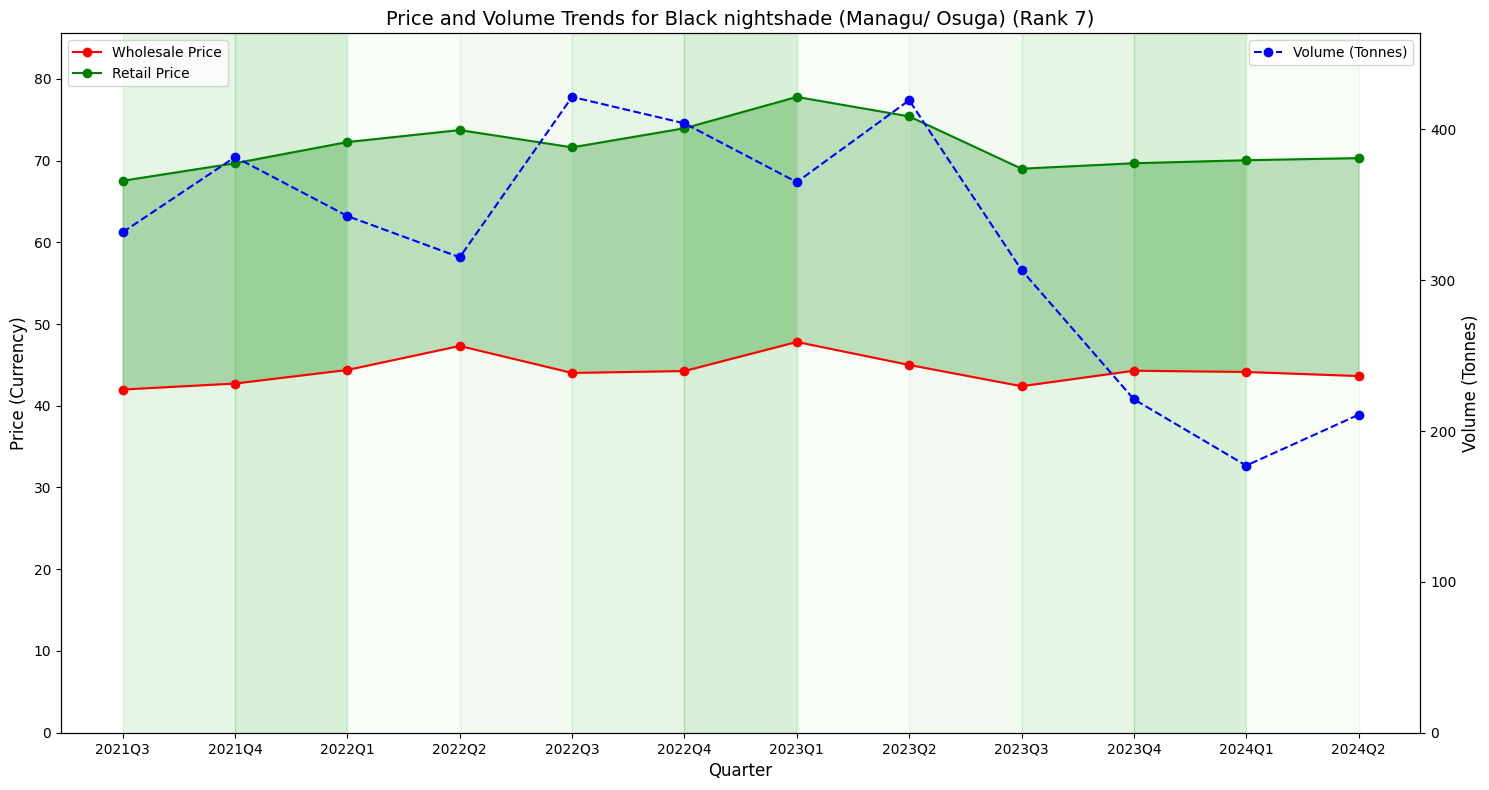

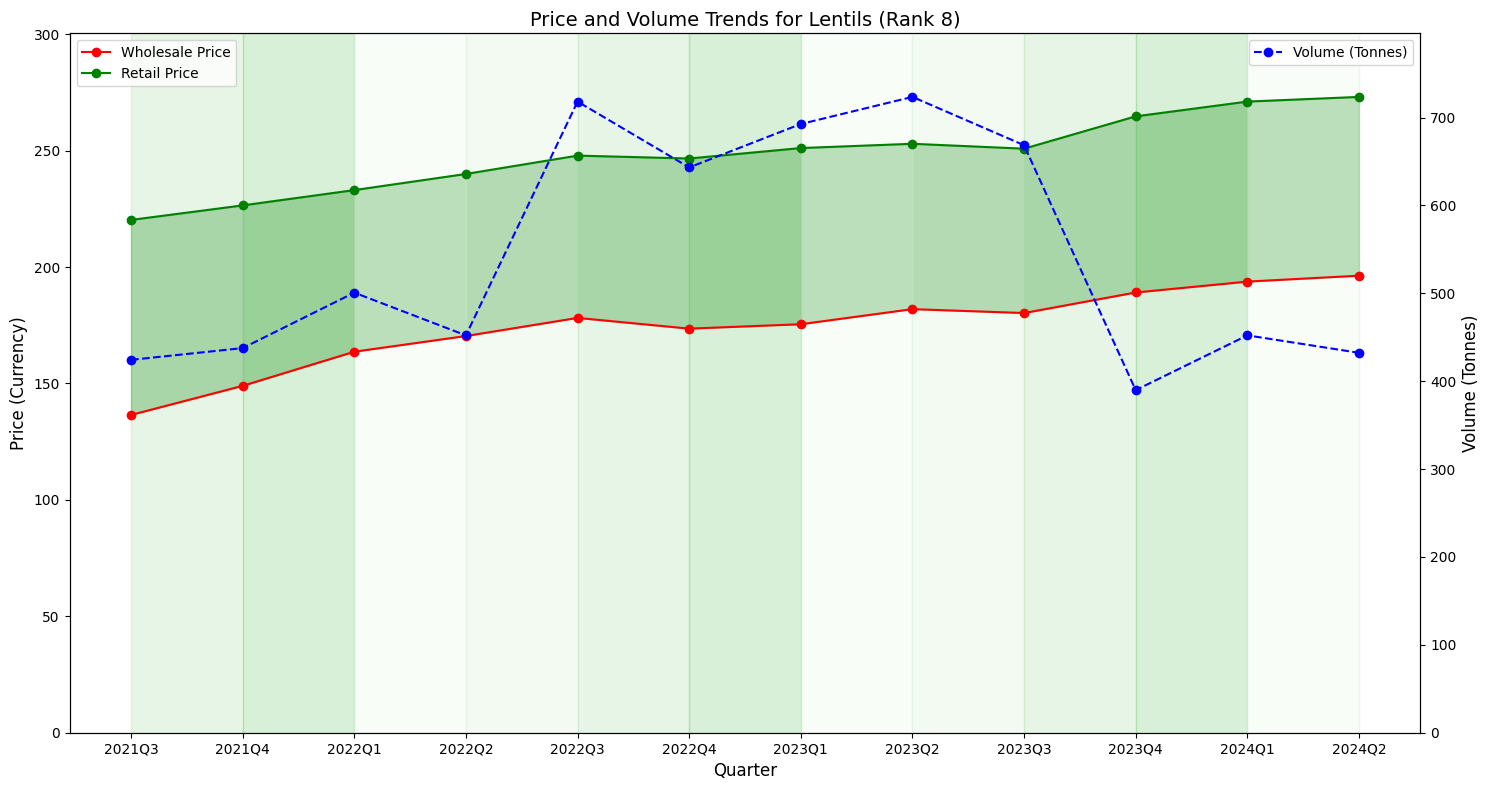

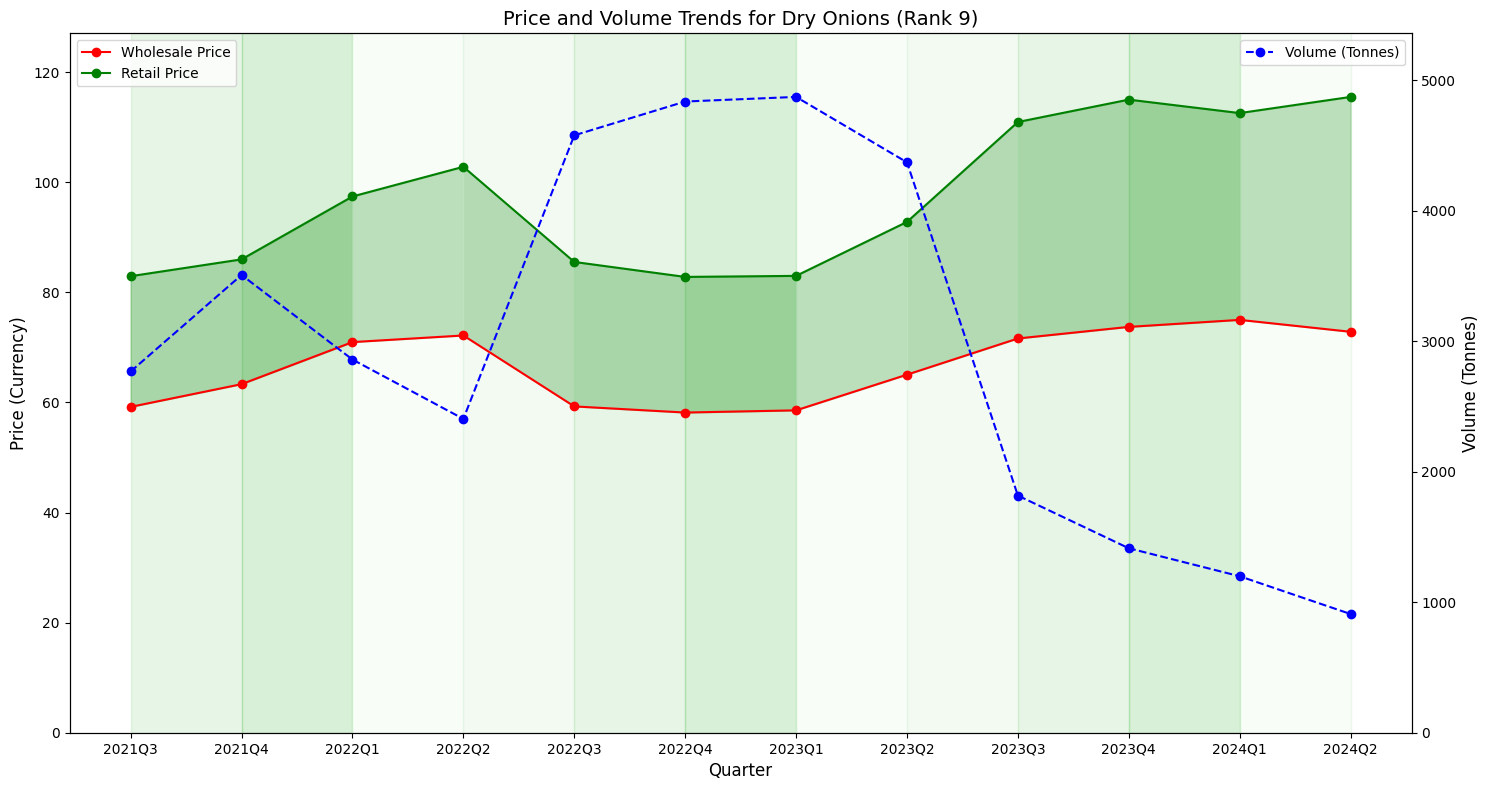

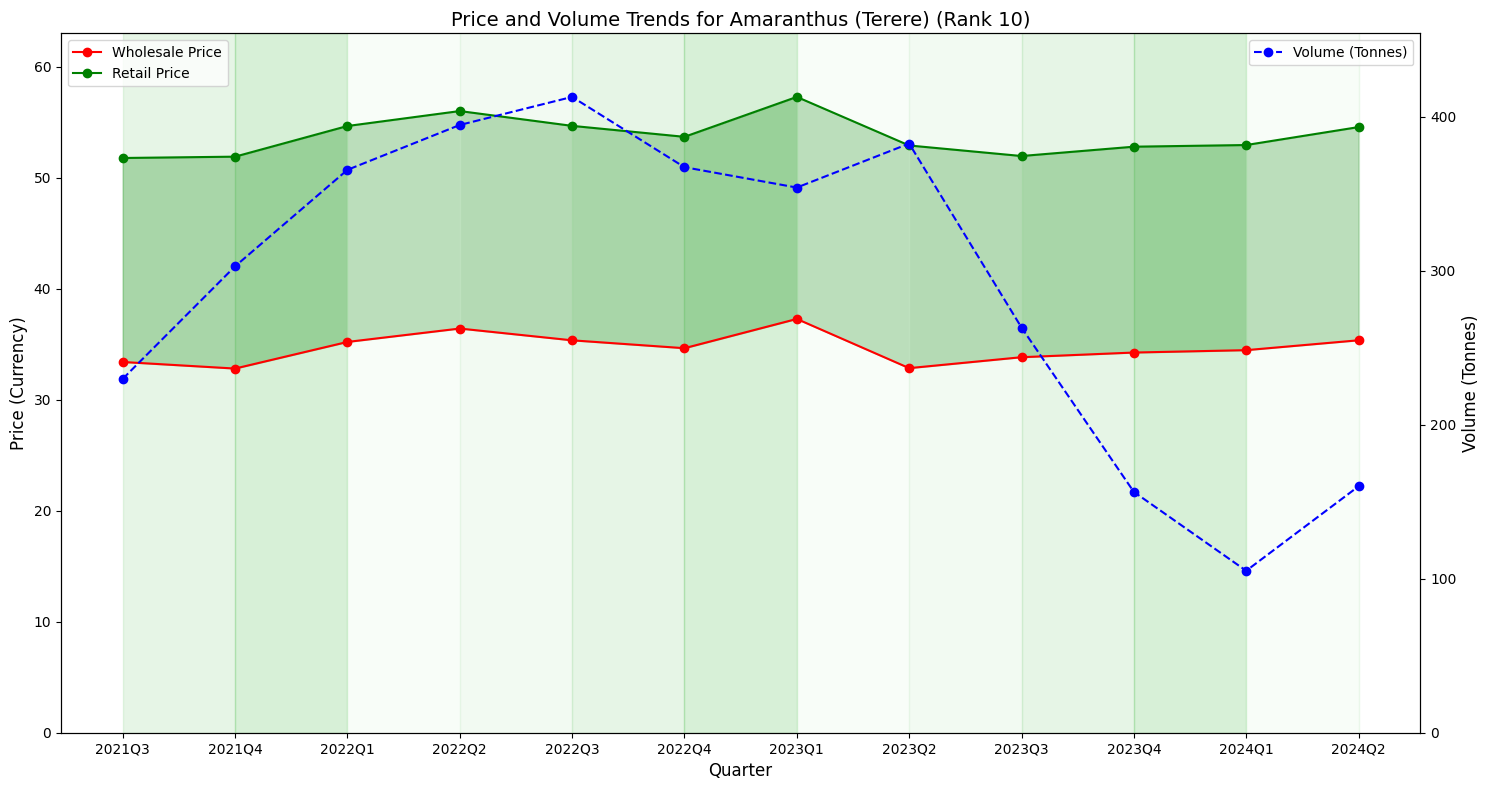

In [41]:
# Loop through the top commodities and create a plot for each
for i, commodity in enumerate(top_combined_commodities, 1):  # i is the rank (starting from 1)
    fig, ax1 = plt.subplots(figsize=(15, 8))
    
    # Filter data for the current commodity
    commodity_data = filtered_data[filtered_data['commodity'] == commodity]
    
    # Plot wholesale and retail prices on the left y-axis
    ax1.plot(commodity_data['quarter'], commodity_data['avg_wholesale_price'], color='red', marker='o', label='Wholesale Price')
    ax1.plot(commodity_data['quarter'], commodity_data['avg_retail_price'], color='green', marker='o', label='Retail Price')
    
    # Shade the area between wholesale and retail prices
    ax1.fill_between(commodity_data['quarter'], commodity_data['avg_wholesale_price'], commodity_data['avg_retail_price'], 
                     where=(commodity_data['avg_retail_price'] > commodity_data['avg_wholesale_price']), color='green', alpha=0.3)
    
    # Set labels for the first y-axis (prices)
    ax1.set_xlabel('Quarter', fontsize=12)
    ax1.set_ylabel('Price (Currency)', fontsize=12, color='black')
    
    # Add headroom to the price y-axis by calculating the max value and adding 10% padding
    max_price = max(commodity_data[['avg_wholesale_price', 'avg_retail_price']].max())
    ax1.set_ylim(0, max_price * 1.1)  # 10% headroom
    
    # Create a second y-axis for volume
    ax2 = ax1.twinx()
    ax2.plot(commodity_data['quarter'], commodity_data['total_volume_tonnes'], color='blue', linestyle='--', marker='o', label='Volume (Tonnes)')
    ax2.set_ylabel('Volume (Tonnes)', fontsize=12, color='black')
    
    # Add headroom to the volume y-axis by calculating the max value and adding 10% padding
    max_volume = commodity_data['total_volume_tonnes'].max()
    ax2.set_ylim(0, max_volume * 1.1)  # 10% headroom
    
    # Shade the background for each quarter with corresponding shades of green
    for j, quarter in enumerate(quarter_labels):
        if "Q1" in quarter:
            color = shading_colors[0]  # Lightest green for Q1
        elif "Q2" in quarter:
            color = shading_colors[1]  # Slightly darker green for Q2
        elif "Q3" in quarter:
            color = shading_colors[2]  # Darker green for Q3
        elif "Q4" in quarter:
            color = shading_colors[3]  # Darkest green for Q4
        
        ax1.axvspan(quarter, quarter_labels[j+1] if j+1 < len(quarter_labels) else quarter, color=color, alpha=0.2)
    
    # Set plot title and legend
    plt.title(f'Price and Volume Trends for {commodity} (Rank {i})', fontsize=14)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

---

##### Findings:

1. Highly Profitable Commodities: Commodities like Maize Flour, Lettuce, and Jute Plant showed extremely high profit margins, with the top-performing commodities reaching profit margins above 80% and some as high as 166%. These commodities have the potential to generate significant returns for retailers and intermediaries.

2. Commodities with Balanced Volumes and Profit Margins: Commodities like Maize Flour, Kales/Sukuma Wiki, Watermelon, and Spinach demonstrate both high volumes and strong profit margins. These are ideal for smallholder farmers and retailers as they offer both high demand and good profitability.

3. Commodities with High Volumes but Lower Margins: Commodities like Dry Maize, Green Grams, and Wheat Flour appear in the top volume categories but have relatively lower profit margins. These commodities have strong demand, but their profitability is not as high, which could be influenced by market saturation or pricing pressures.

4. Commodities with Low Volumes and Poor Margins: Commodities like Wheat Flour, Rice, Mixed Beans, and Beans (Mwezi Moja), which are ranked lower in both volume and profit, may not be ideal for smallholder farmers looking for high returns. These could be products that are too common or face pricing challenges.

5. Wide Variation in Profitability: There is a substantial variation in profitability across the commodities, with some showing over 100% profit margins, while others, particularly staple commodities like Wheat Flour and Rice, have margins under 10%. This highlights the competitive pressures on widely consumed goods.



##### Insights:

1. Profit Margin vs. Volume Tradeoff: Commodities that are high in volume tend to have lower profit margins, as seen with Dry Maize and Wheat. These products likely face competitive pricing and market saturation. In contrast, some niche or less common products like Lettuce, Jute Plant, and Spinach offer higher profit margins despite not being the highest in volume.

2. Opportunities for Smallholder Farmers: Farmers could focus on commodities like Spinach, Kales/Sukuma Wiki, and Amaranthus (Terere), which show a combination of decent volumes and good profit margins. These crops could serve both local markets and small retail businesses with favorable financial outcomes.

3. Retailers and Brokers: Market linkage players and brokers should focus on commodities with the highest combined score, such as Maize Flour, Watermelon, Spinach, and Black Nightshade (Managu). These crops will not only yield good sales due to their volume but also generate favorable profit margins, allowing brokers and retailers to scale their operations more profitably.

4. Risk of Low Margin Commodities: Commodities like Rice, Beans (Mwezi Moja), Wheat Flour, and Mixed Beans should be approached with caution. Though they may have demand due to staple consumption, the narrow profit margins can make them less attractive unless high-volume sales are guaranteed.



##### Recommendations:

1. Smallholder Farmers: Focus on crops that have a balance between high demand and strong profitability, such as Kales/Sukuma Wiki, Spinach, and Watermelon. Diversification into higher-margin crops like Lettuce and Jute Plant should be considered to boost profitability. This can allow farmers to make the most of small-scale farming by optimizing both yield and returns.

2. Market Linkage Players/Brokers: Look for commodities like Maize Flour, Watermelon, and Spinach, which offer opportunities to generate higher volumes while maintaining strong profit margins. Developing supply chains for niche or high-margin crops like Thorn Melon and Lettuce could also prove lucrative for both brokers and the farmers they connect.

3. Retailers: Retailers should prioritize stocking commodities like Maize Flour, Spinach, and Black Nightshade, which show a strong balance between demand and profitability. On the other hand, they should be cautious about staples like Wheat Flour and Rice that, while in demand, offer much lower margins and might not be worth prioritizing unless they are sold in bulk.

---

## Areas for Further Study and Opportunities:

#### 1. Regional Market Demand and Specialization

Further Study:

Commodity Demand by Region: Investigate regional variations in demand for certain commodities, and the underlying factors affecting them. While some commodities perform well in terms of volume, they might be more profitable in certain counties or markets. Analyzing the data based on regional preferences and production capacities could offer insights into where different crops can be grown most profitably.

County-Level Market Penetration: Explore why certain counties like Kirinyaga and Nairobi have higher aggregated volumes compared to others. This could provide insights into local distribution systems, infrastructure, or market inefficiencies.

Opportunity:

Specialization in High-Volume Counties: Certain regions, like Kirinyaga and Nairobi, can specialize further in high-demand commodities, benefiting from economies of scale. Identifying other underperforming regions with the potential for growth based on climate and market access can help smallholder farmers and brokers shift their focus to more promising areas.


#### 2. Niche Crop Opportunities with High Profit Margins

Further Study:

Niche Crop Profitability: Certain niche crops like Lettuce, Jute Plant, and Njugu Mawe demonstrated very high profit margins but lower volumes. Further exploration into why these crops aren't being produced at scale could reveal barriers such as climate, market access, or knowledge gaps.

Cultural and Seasonal Impact on Niche Crops: Some crops might not perform well because of cultural preferences or limited growing seasons. Studying the seasonal demand patterns and exploring alternative cultivation techniques (e.g., greenhouse farming) could unlock more opportunities for profit.

Opportunity:

Growing Niche Crops for Export Markets: Smallholder farmers can diversify into niche high-margin crops like Lettuce and Thorn Melon, particularly for export markets where demand is high. Brokers can also explore linking smallholder farmers to international markets where such crops can fetch premium prices.

#### 3. Exploring Value-Addition Opportunities

Further Study:

Value-Added Products: Investigate value-addition opportunities for low-margin, high-volume crops like Dry Maize, Rice, and Wheat Flour. Adding value through processing or branding can improve profit margins. For example, turning maize into flour or beans into canned or pre-packaged products.

Market Appetite for Processed Commodities: A study on consumer preferences for value-added products (e.g., pre-packaged or processed foods) could reveal market trends that support higher profitability for processed versions of low-margin crops.

Opportunity:

Value-Addition Initiatives: Farmers, cooperatives, and brokers can collaborate to establish small-scale processing units for commodities like maize and beans, increasing profit margins. Developing brands for organic or sustainably grown products could attract premium prices from urban consumers.

#### 4. Improved Supply Chain and Logistics for Remote Markets

Further Study:

Logistics Challenges in Low-Volume Markets: Many markets with low aggregated volumes (like Taveta, Lekuru, and Poro Market) may be suffering from poor supply chains, infrastructure issues, or market access problems. Understanding the underlying logistics challenges can help create solutions that open up these markets.

Market Accessibility Study: Investigating the role of road networks, transportation costs, and intermediaries on commodity prices and supply chain efficiency will shed light on how to reduce the gap between farm gate prices and market prices.

Opportunity:

Supply Chain Optimization: Improving transportation and storage facilities, particularly in remote areas, can enhance commodity flow and reduce post-harvest losses. Market linkage players could explore partnerships with logistics companies to develop more efficient supply routes for rural and underserved areas.


#### 5. Exploring Sustainable and Climate-Resilient Commodities

Further Study:

Climate-Resilient Crops: Some crops in the list might be more resilient to climate change (e.g., drought-resistant or heat-tolerant). Further research could identify which crops can thrive despite changing climate conditions, providing farmers with options to adapt.

Sustainable Farming Practices: Investigating the impact of sustainable farming practices on profitability, especially for smallholder farmers, could reveal new opportunities for cost-saving and enhancing yield while reducing environmental impact.

Opportunity:

Promotion of Climate-Resilient Crops: For regions experiencing extreme weather conditions, brokers and extension services can promote drought-tolerant crops such as Sorghum and Pigeon Peas that still offer reasonable returns in adverse conditions. Governments and NGOs can provide grants or training to support this shift.

#### 6. Exploring Consumer Trends and Preferences

Further Study:

Consumer Behavior Analysis: Investigating why certain crops have higher volumes but lower profitability could reveal consumer purchasing habits, cultural preferences, or market saturation. For example, are staple crops like Dry Maize and Rice being sold at low margins due to consumer price sensitivity?

Future Demand Projections: Study shifting consumer preferences due to changing dietary patterns, urbanization, or health trends (e.g., increasing demand for organic or locally-sourced produce). This will help predict which commodities will see increased demand in the coming years.

Opportunity:

Adapting to Emerging Trends: Smallholder farmers could take advantage of rising consumer demand for organic or health-conscious foods by shifting to more sustainable farming practices or growing organic versions of high-demand crops like Spinach or Amaranthus (Terere). Market linkage players can develop better marketing strategies for health-conscious consumers, positioning commodities as premium products.


#### 7. Price Stabilization Mechanisms

Further Study:

Commodity Price Volatility: Further analysis of the price volatility of highly consumed goods like Wheat, Rice, and Dry Maize could reveal opportunities to stabilize prices. Volatility can negatively affect farmers' incomes, especially if they're unable to store products long enough to take advantage of price increases.

Farmer Access to Financial Tools: Investigating the availability and use of financial tools (e.g., crop insurance, price hedging) could help smallholder farmers better manage risk, particularly for commodities that have fluctuating profit margins.

Opportunity:

Financial Tools for Farmers: Smallholder farmers and cooperatives could benefit from price stabilization programs or financial instruments that reduce the risk of price swings in low-margin commodities. Brokers can introduce contract farming or fixed-price contracts to provide farmers with a more stable income.


---

## Project Author and Details

**Author**: Edward Njiru 

**Email**: enjiru@cropcircle.ngo

**Organization**: Crop Circle Africa 

**Date**: September 2024 

---

### Copyright & License

This project and its contents are licensed under the [MIT License](https://opensource.org/licenses/MIT).

---
